# Mice TBI Segmentation Thesis
## ROI segmentation
Author: Marcello De Salvo <br>

# Table of contents<font><a class='anchor' id='top'></a>
1. [Importing Libraries](#lib)
2. [Problem Definition](#problem)
3. [Data Description](#data)
4. [Configuration](#conf)
5. [Data Visualization](#visual)
6. [Loss Function](#loss)  
7. [Data Loader](#load)
8. [Model](#model)
9. [Results](#results)
10. [Evaluation](#eval)

# 1. Libraries <a class='anchor' id='lib'></a> [↑](#top)

In [6]:
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize as resz
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import time

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

import evaluation.inference
importlib.reload(evaluation.inference)
from evaluation.inference import FullVolumeEvaluation
from evaluation.postprocessing import ipsi_contra_division_callback, morphology_refinement_callback

# tensorflow
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import plot_model

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import seaborn as sns
sns.set_theme(style="whitegrid")

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

# Import mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')


Num GPUs Available:  1
2.10.0


# 2. Problem definiton<a class='anchor' id='problem'></a> [↑](#top)
**Skullstripping of mice brains**

Each pixel in the image has to be assigned one of the following labels: <br>
- Background (label 0)
- Lesion (red, label 1)
- Cortex contra (green, label 2)
- Cortex ispi (blue, label 3)
- Hippo contra (yellow, label 4)
- Hippo ipsi (light blue, label 5)
- CC contra (light brown, label 10)
- CC ipsi (light green, label 11)
- Ventricle ipsi (dark blue, label 12)
- Ventricle contra (light blue, label 13)
- Third Ventricle (green, label 14)
- EC contra (pink, label 15)
- EC ipsi (purple, label 16)

# 3. Image data descriptions <a class='anchor' id='data'></a> [↑](#top)

All multimodal scans are available as  NIfTI files (.nii.gz), a commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T2 (Rare)**
2. **FLASH**
3. **DTI**

Data were acquired directly in this institute.
All the imaging datasets have been segmented manually.

# 4. Configuration <a class='anchor' id='conf'></a> [↑](#top)

In [7]:
# PRE PROCESSING
import time
# All labels [0,1,2,3,4,5,10,11,12,13,14,15,16]
# Labels currently used [0,1,12,13,14]
config ={
    'k': 5,
    'dataset_path': '..\dataset_roi',
    'input_shape': (112,112,112),
    'target_resolution': (0.1,0.1,0.1),
    'labels': [0,1,3,13,21], # 0: background, 1: lesion, 3: contra-ventricle, 13: ipsi-ventricle, 21: third ventricle
    'mapping': {0:0, 1:1, 3:2, 13:2, 21:3}, # 0: background, 1: ventricles, 2: cortex, 3: hippocampus -> 4 classes
    'num_classes': 4, # 4 classes
    'in_channels': 1,
    'batch_size': 4,
    'epochs': 100,
    'lr': 1e-3,
    'model_name': "multi_task_k_fold" + "_ep" + str(500) + time.strftime("_%d-%m-%Y_%H-%M"),
    'mice_sampling_rate': 0,
    'rats_sampling_rate': 5,
}

### Custom Losses
The term "smooth" is typically a small positive value that is added to the numerator and denominator of the Dice coefficient formula. Its purpose is to prevent division by zero.<br>
I'll use the **Soft Dice Loss** as explained here: https://www.jeremyjordan.me/semantic-segmentation/

In [8]:
import evaluation.metrics
importlib.reload(evaluation.metrics)
from evaluation.metrics import *

import evaluation.losses
importlib.reload(evaluation.losses)
from evaluation.losses import *

metrics = [accuracy_coefficient(), precision_coefficient(), sensitivity_coefficient(), specificity_coefficient(), dice_coefficient(), iou_coefficient(), volume_similarity_coefficient()]

# append to metric a class_dice_coef for each class
for i in range(config['num_classes']):
    metrics.append(dice_coefficient(class_index=i, exclude_background=False))

# 7. Data Loader <a class='anchor' id='load'></a> [↑](#top)
Loading all data into memory is not a good idea since the data are too big to fit in.<br>
So we will create a DataGenerators class to load data on the fly as explained [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [11]:
import utils.loader
importlib.reload(utils.loader)
from utils.loader import *

# Loading manually the rats of different time points
rodent_dataset = RodentDatasets(
    labels=config['labels'],
)

rodent_dataset.add_dataset(config['dataset_path'], 'T2W-Rats', sub_folder='Anat')

# Extract ids   
train_and_test_ids = rodent_dataset.get_subjects_list()

# Extract unique subjects by checking the first 4 characters of the second element of the tuple (e.g. RAT1_5w -> RAT1)
id_char_length = 4
rats_unique_ids = list(set([x[1][:id_char_length] for x in train_and_test_ids]))

# Print
print('---- ')
# Order the unique rats ids
rats_unique_ids.sort()
print('Unique rats ids: ', rats_unique_ids)

Added 20 subjects from T2W-Rats
---- 
Unique rats ids:  ['RAT1', 'RAT2', 'RAT3', 'RAT4', 'RAT5']


In [12]:
import importlib
import preprocessing.preprocessor
importlib.reload(preprocessing.preprocessor)
from preprocessing.preprocessor import Preprocessor, Resample, Reorient, Normalize, CorrectX10, MapLabels, RandomCropping, RandomAffine, GaussianBlur, Noise, Flip, Padder
from preprocessing.generator import MultiTaskGenerator

# ref image for reorientation
ref_img = nib.load(os.path.join('../example', 'RARE', 'TBI_fm_19_49', 'Anat', 'TBI_fm_19_49_N4.nii.gz'))

augmented = Preprocessor([
    MapLabels(config['labels'], mapping=config['mapping']),
    CorrectX10(),
    Reorient(ref_img),
    RandomAffine(rotation_range=[-5,5], scale_range=[0.9,1.05], probability=0.3),
    GaussianBlur([0,0.6], probability=0.3),
    Noise([0,0.05], probability=0.3),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Normalize(),
    RandomCropping(config['input_shape'], mode='random', std=None),
    Flip(axis_list=[0], probability=0.5),
])

preprocessor =  Preprocessor([
    MapLabels(config['labels'], mapping=config['mapping']),
    CorrectX10(),
    Reorient(ref_img),
    Resample(target_resolution=config['target_resolution'], interpolation=0),
    Normalize(),
    RandomCropping(config['input_shape'], mode='random', std=None),
    Flip(axis_list=[0], probability=0.5),
])

# 8. Model | 3D U-Net <a class='anchor' id='model'></a> [↑](#top)

In [15]:
import models.networks
importlib.reload(models.networks)
from models.networks import *

# Example usage:
filters = [16, 32, 64, 128, 256]
model = mt_r_net_3d(config['input_shape'], config['in_channels'], config['num_classes'], filters, attention=True, residual=True)

## Overview

In [ ]:
# Print summary of the model giving the input shape to function
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                12, 1)]                                                           
                                                                                                  
 conv3d_10 (Conv3D)             (None, 112, 112, 11  448         ['input_1[0][0]']                
                                2, 16)                                                            
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 112, 112, 11  64         ['conv3d_10[0][0]']              
 rmalization)                   2, 16)                                                        

## Training

In [8]:
roi_loss = diceCELoss(smooth=1e-5, batch_wise=True, gamma=0.8)
skullstrip_loss = diceBCELoss(alpha=0.6, smooth=1e-5, batch_wise=True)

losses = {
    'regions': roi_loss,
    'brain_mask': skullstrip_loss,
}

loss_weights = {
    'regions': 1,
    'brain_mask': 1,
}

metrics = {
    'regions': metrics,
    'brain_mask': dice_coefficient(class_index=0, exclude_background=False),
}

In [9]:
def get_train_validation_rats(fold):  
    # get the validation rat
    val_rat = rats_unique_ids[fold]
    print('Validation rat: ', val_rat)

    train_rats = [x for x in rats_unique_ids if x != val_rat]

    # Extract thet time points of the selected rats
    val_rats_ids = [x for x in train_and_test_ids if x[1][:id_char_length] == val_rat]
    train_rats_ids = [x for x in train_and_test_ids if x[1][:id_char_length] in train_rats]
    return train_rats_ids, val_rats_ids

In [10]:
from evaluation.k_fold import *

def k_fold_loop(model_callback, fve_callbacks, config, train_and_test_ids, metrics_dictionary):
    history_k, fve_evaluations = run_k_fold_training(model_callback, fve_callbacks, config, train_and_test_ids, metrics_dictionary)
    return history_k, fve_evaluations

def run_k_fold_training(model_callback, fve_callbacks, config, train_and_test_ids, metrics_dictionary):
    history_k = []
    kfold = KFold(n_splits=config['k'], shuffle=True, random_state=42)
    
    # Create list of lists to store the metrics for each evaluation based on the number of callbacks
    fve_evaluations = [[] for _ in range(len(fve_callbacks))]

    for fold, (train_ids_k, val_ids_k) in enumerate(kfold.split(train_and_test_ids)):

        # Get the train and validation rats
        rats_train_ids_k, rats_val_ids_k = get_train_validation_rats(fold)

        # Multiply the train and validation rats by the sampling rate
        train_ids_k = rats_train_ids_k * config['rats_sampling_rate']
        val_ids_k = rats_val_ids_k * config['rats_sampling_rate']
        
        print('Trainig on: ', len(train_ids_k), ' samples')
        print('Validating on: ', len(val_ids_k), ' samples')
        
        steps = len(train_ids_k) // config['batch_size']
        val_steps = len(val_ids_k) // config['batch_size']

        train_gen = MultiTaskGenerator(train_ids_k, rodent_dataset, config, config['batch_size'], preprocessor=augmented, shuffle=True)
        val_gen = MultiTaskGenerator(val_ids_k, rodent_dataset, config, config['batch_size'], preprocessor=preprocessor, shuffle=True)

        print_fold_info(fold, train_ids_k, val_ids_k)

        path = create_output_dirs(config, fold)
        save_train_val_ids(train_ids_k, val_ids_k, path, fold)

        callbacks, checkpoint_path = create_callbacks(fold, config)
        model = model_callback()
        k_history = model.fit(train_gen, validation_data=val_gen, epochs=config['epochs'], steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)
        _k_history = k_history.history
        
        history_k.append(_k_history)
        model.load_weights(checkpoint_path).expect_partial()
        model.save(f'{path}/model_fold_{fold}.h5')


        plot_loss(_k_history, fold, config)
        plot_metrics(_k_history, fold, config)
        save_history(_k_history, fold, config)

        # Evaluate the model on the full volumes for mice
        for fve_callback in fve_callbacks:
            fold_dataframe = fve_callback(model, rats_val_ids_k, config, fold)
            fve_evaluations[fve_callbacks.index(fve_callback)].append(fold_dataframe)

    return history_k, fve_evaluations

def model_callback():
    # Load a pre-trained model form ../results
    # model = mt_r_net_3d(config['input_shape'], config['in_channels'], config['num_classes'], filters, attention=True, residual=True)
    model = load_model('../results/mice_rnet_pretrained/mice_rnet_pretrained.h5', 
                       custom_objects={'mt_r_net_3d': mt_r_net_3d, 
                                       'diceCELoss': diceCELoss, 'diceBCELoss': diceBCELoss, 'loss':losses,
                                       'mean_accuracy': accuracy_coefficient, 'mean_precision': precision_coefficient, 'mean_sensitivity': sensitivity_coefficient, 
                                       'mean_specificity': specificity_coefficient, 'mean_dice': dice_coefficient, 'mean_iou': iou_coefficient, 
                                       'mean_volume_similarity': volume_similarity_coefficient, 'class_0_dice': dice_coefficient(class_index=0, exclude_background=False),
                                        'class_1_dice': dice_coefficient(class_index=1, exclude_background=False), 'class_2_dice': dice_coefficient(class_index=2, exclude_background=False),
                                        'class_3_dice': dice_coefficient(class_index=3, exclude_background=False)})

    model.summary()
        
    # compile the model
    model.compile(optimizer=Nadam(learning_rate=config['lr']), loss=losses, loss_weights=loss_weights, metrics=metrics)
    return model

def fve_callback_regions(model, val_ids_k, config, fold):
    inferenceProcessor = Preprocessor([
        CorrectX10(),
        MapLabels(labels=config['labels']),
        Resample(target_resolution=config['target_resolution'], interpolation=0),
        Reorient(ref_img),
        Normalize(),
    ])
    full_volume_eval = FullVolumeEvaluation(model, val_ids_k, config, rodent_dataset, strides=[28,56], preprocessor=inferenceProcessor, 
                                            roi_postprocess_callback=ipsi_contra_division_callback(use_centroids=False),
                                            path='../results/'+config['model_name']+'/fold_'+str(fold)+'/'+'regions/')
    fold_dataframe = full_volume_eval.evaluate()
    return fold_dataframe

def fve_callback_skullstrip(model, val_ids_k, config, fold):
    inferenceProcessor = Preprocessor([
        CorrectX10(),
        Resample(target_resolution=config['target_resolution'], interpolation=0),
        Reorient(ref_img),
        Normalize(),
    ])
    full_volume_eval = FullVolumeEvaluation(model, val_ids_k, config, rodent_dataset, strides=[28,56], preprocessor=inferenceProcessor, 
                                            brain_mask_postprocess_callback=morphology_refinement_callback(), path='../results/'+config['model_name']+'/fold_'+str(fold)+'/'+'brain_mask/')
    fold_dataframe = full_volume_eval.evaluate(evaluate_brain_mask=True)
    return fold_dataframe

Validation rat:  RAT1
Trainig on:  80  samples
Validating on:  20  samples
Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (112, 112, 112)
- Batch size: 4
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True

Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (112, 112, 112)
- Batch size: 4
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True


FOLD 0
Training on 80 examples (17 unique IDs)
Unique Train IDs: ['RAT2_14Days_CCI' 'RAT2_30Days_CCI' 'RAT2_60Days_CCI' 'RAT3_14Days_CCI'
 'RAT3_30Days_CCI' 'RAT3_60Days_CCI' 'RAT3_7Days_CCI' 'RAT4_14Days_CCI'
 'RAT4_30Days_CCI' 'RAT4_60Days_CCI' 'RAT4_7Days_CCI' 'RAT5_14Days_CCI'
 'RAT5_30Days_CCI' 'RAT5_45Days_CCI' 'RAT5_60Days_CCI' 'RAT5_7Days_CCI'
 'T2w-RATS']
------------------------------
Validating on 20 examples (5 unique IDs)
Unique Validation IDs: ['RAT1_14Days_CCI' 'RAT1_30Days_CCI' 'RAT1_60Days_CCI' 'RAT1_7Days_CCI'
 'T2w-RATS']

Epoch 1/100
20/20 [=============

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 199s 7s/step - loss: 0.5663 - regions_loss: 0.2347 - brain_mask_loss: 0.2495 - regions_mean_accuracy: 0.9857 - regions_mean_precision: 0.1452 - regions_mean_sensitivity: 0.0655 - regions_mean_specificity: 0.9796 - regions_mean_dice: 0.0427 - regions_mean_iou: 0.0240 - regions_mean_volume_similarity: 0.3894 - regions_class_0_dice: 0.9039 - regions_class_1_dice: 0.1010 - regions_class_2_dice: 0.0216 - regions_class_3_dice: 0.0055 - brain_mask_class_0_dice: 0.7777 - val_loss: 3.5642 - val_regions_loss: 2.0304 - val_brain_mask_loss: 1.4520 - val_regions_mean_accuracy: 0.7995 - val_regions_mean_precision: 0.0151 - val_regions_mean_sensitivity: 0.2899 - val_regions_mean_specificity: 0.7066 - val_regions_mean_dice: 0.0255 - val_regions_mean_iou: 0.0130 - val_regions_mean_volume_similarity: 0.1905 - val_regions_class_0_dice: 0.2081 - val_regions_class_1_dice: 0.0390 - val_regions_class_2_dice: 0.0352 - val_regions_class_3_dice: 0.0023 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 121s 6s/step - loss: 0.4043 - regions_loss: 0.1474 - brain_mask_loss: 0.1754 - regions_mean_accuracy: 0.9964 - regions_mean_precision: 0.2526 - regions_mean_sensitivity: 0.1873 - regions_mean_specificity: 0.9968 - regions_mean_dice: 0.1971 - regions_mean_iou: 0.1372 - regions_mean_volume_similarity: 0.6239 - regions_class_0_dice: 0.9889 - regions_class_1_dice: 0.4712 - regions_class_2_dice: 0.1190 - regions_class_3_dice: 0.0010 - brain_mask_class_0_dice: 0.8453 - val_loss: 2.7284 - val_regions_loss: 2.0888 - val_brain_mask_loss: 0.5585 - val_regions_mean_accuracy: 0.7983 - val_regions_mean_precision: 0.0086 - val_regions_mean_sensitivity: 0.2950 - val_regions_mean_specificity: 0.6925 - val_regions_mean_dice: 0.0130 - val_regions_mean_iou: 0.0066 - val_regions_mean_volume_similarity: 0.2235 - val_regions_class_0_dice: 0.1279 - val_regions_class_1_dice: 0.0253 - val_regions_class_2_dice: 0.0129 - val_regions_class_3_dice: 8.9250e-04 - val_brain_ma

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 120s 6s/step - loss: 0.3878 - regions_loss: 0.1322 - brain_mask_loss: 0.1748 - regions_mean_accuracy: 0.9976 - regions_mean_precision: 0.3026 - regions_mean_sensitivity: 0.2511 - regions_mean_specificity: 0.9983 - regions_mean_dice: 0.2519 - regions_mean_iou: 0.1681 - regions_mean_volume_similarity: 0.5345 - regions_class_0_dice: 0.9932 - regions_class_1_dice: 0.4745 - regions_class_2_dice: 0.2811 - regions_class_3_dice: 1.3761e-09 - brain_mask_class_0_dice: 0.8416 - val_loss: 1.8628 - val_regions_loss: 1.4279 - val_brain_mask_loss: 0.3546 - val_regions_mean_accuracy: 0.8469 - val_regions_mean_precision: 0.0321 - val_regions_mean_sensitivity: 0.3368 - val_regions_mean_specificity: 0.7539 - val_regions_mean_dice: 0.0511 - val_regions_mean_iou: 0.0271 - val_regions_mean_volume_similarity: 0.1759 - val_regions_class_0_dice: 0.3794 - val_regions_class_1_dice: 0.0258 - val_regions_class_2_dice: 0.1266 - val_regions_class_3_dice: 8.3244e-04 - val_brai

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 122s 6s/step - loss: 0.3463 - regions_loss: 0.1134 - brain_mask_loss: 0.1536 - regions_mean_accuracy: 0.9979 - regions_mean_precision: 0.3973 - regions_mean_sensitivity: 0.3486 - regions_mean_specificity: 0.9984 - regions_mean_dice: 0.3514 - regions_mean_iou: 0.2606 - regions_mean_volume_similarity: 0.5860 - regions_class_0_dice: 0.9941 - regions_class_1_dice: 0.7117 - regions_class_2_dice: 0.3425 - regions_class_3_dice: 3.7208e-09 - brain_mask_class_0_dice: 0.8683 - val_loss: 0.9282 - val_regions_loss: 0.2649 - val_brain_mask_loss: 0.5843 - val_regions_mean_accuracy: 0.9772 - val_regions_mean_precision: 0.1282 - val_regions_mean_sensitivity: 0.1520 - val_regions_mean_specificity: 0.9598 - val_regions_mean_dice: 0.0579 - val_regions_mean_iou: 0.0308 - val_regions_mean_volume_similarity: 0.1554 - val_regions_class_0_dice: 0.9053 - val_regions_class_1_dice: 0.0683 - val_regions_class_2_dice: 0.1031 - val_regions_class_3_dice: 0.0023 - val_brain_ma

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 121s 6s/step - loss: 0.2817 - regions_loss: 0.1171 - brain_mask_loss: 0.0859 - regions_mean_accuracy: 0.9980 - regions_mean_precision: 0.3698 - regions_mean_sensitivity: 0.3313 - regions_mean_specificity: 0.9985 - regions_mean_dice: 0.3240 - regions_mean_iou: 0.2330 - regions_mean_volume_similarity: 0.5198 - regions_class_0_dice: 0.9943 - regions_class_1_dice: 0.5516 - regions_class_2_dice: 0.4202 - regions_class_3_dice: 4.9998e-06 - brain_mask_class_0_dice: 0.9275 - val_loss: 0.5364 - val_regions_loss: 0.1744 - val_brain_mask_loss: 0.2836 - val_regions_mean_accuracy: 0.9945 - val_regions_mean_precision: 0.2157 - val_regions_mean_sensitivity: 0.1232 - val_regions_mean_specificity: 0.9954 - val_regions_mean_dice: 0.1497 - val_regions_mean_iou: 0.0860 - val_regions_mean_volume_similarity: 0.6932 - val_regions_class_0_dice: 0.9786 - val_regions_class_1_dice: 0.1841 - val_regions_class_2_dice: 0.2649 - val_regions_class_3_dice: 5.1727e-05 - val_brai

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 123s 6s/step - loss: 0.2977 - regions_loss: 0.1182 - brain_mask_loss: 0.1018 - regions_mean_accuracy: 0.9975 - regions_mean_precision: 0.3684 - regions_mean_sensitivity: 0.3358 - regions_mean_specificity: 0.9982 - regions_mean_dice: 0.3287 - regions_mean_iou: 0.2395 - regions_mean_volume_similarity: 0.5118 - regions_class_0_dice: 0.9930 - regions_class_1_dice: 0.5437 - regions_class_2_dice: 0.4424 - regions_class_3_dice: 3.4268e-05 - brain_mask_class_0_dice: 0.9130 - val_loss: 0.3721 - val_regions_loss: 0.1688 - val_brain_mask_loss: 0.1258 - val_regions_mean_accuracy: 0.9892 - val_regions_mean_precision: 0.2711 - val_regions_mean_sensitivity: 0.4492 - val_regions_mean_specificity: 0.9822 - val_regions_mean_dice: 0.2629 - val_regions_mean_iou: 0.1664 - val_regions_mean_volume_similarity: 0.4665 - val_regions_class_0_dice: 0.9670 - val_regions_class_1_dice: 0.2696 - val_regions_class_2_dice: 0.4784 - val_regions_class_3_dice: 0.0406 - val_brain_ma

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 124s 6s/step - loss: 0.2864 - regions_loss: 0.1101 - brain_mask_loss: 0.0990 - regions_mean_accuracy: 0.9980 - regions_mean_precision: 0.4165 - regions_mean_sensitivity: 0.3512 - regions_mean_specificity: 0.9987 - regions_mean_dice: 0.3600 - regions_mean_iou: 0.2561 - regions_mean_volume_similarity: 0.5343 - regions_class_0_dice: 0.9945 - regions_class_1_dice: 0.5486 - regions_class_2_dice: 0.5302 - regions_class_3_dice: 0.0013 - brain_mask_class_0_dice: 0.9150 - val_loss: 0.3413 - val_regions_loss: 0.1602 - val_brain_mask_loss: 0.1041 - val_regions_mean_accuracy: 0.9925 - val_regions_mean_precision: 0.3243 - val_regions_mean_sensitivity: 0.3708 - val_regions_mean_specificity: 0.9896 - val_regions_mean_dice: 0.2105 - val_regions_mean_iou: 0.1254 - val_regions_mean_volume_similarity: 0.4425 - val_regions_class_0_dice: 0.9826 - val_regions_class_1_dice: 0.3390 - val_regions_class_2_dice: 0.2491 - val_regions_class_3_dice: 0.0434 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 124s 6s/step - loss: 0.2458 - regions_loss: 0.1042 - brain_mask_loss: 0.0647 - regions_mean_accuracy: 0.9981 - regions_mean_precision: 0.4875 - regions_mean_sensitivity: 0.3967 - regions_mean_specificity: 0.9985 - regions_mean_dice: 0.3990 - regions_mean_iou: 0.2900 - regions_mean_volume_similarity: 0.5955 - regions_class_0_dice: 0.9947 - regions_class_1_dice: 0.6016 - regions_class_2_dice: 0.5243 - regions_class_3_dice: 0.0710 - brain_mask_class_0_dice: 0.9431 - val_loss: 0.2531 - val_regions_loss: 0.1389 - val_brain_mask_loss: 0.0376 - val_regions_mean_accuracy: 0.9950 - val_regions_mean_precision: 0.4155 - val_regions_mean_sensitivity: 0.4700 - val_regions_mean_specificity: 0.9934 - val_regions_mean_dice: 0.2920 - val_regions_mean_iou: 0.1777 - val_regions_mean_volume_similarity: 0.4231 - val_regions_class_0_dice: 0.9884 - val_regions_class_1_dice: 0.3634 - val_regions_class_2_dice: 0.3363 - val_regions_class_3_dice: 0.1763 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 123s 6s/step - loss: 0.2367 - regions_loss: 0.0962 - brain_mask_loss: 0.0642 - regions_mean_accuracy: 0.9982 - regions_mean_precision: 0.5502 - regions_mean_sensitivity: 0.4615 - regions_mean_specificity: 0.9985 - regions_mean_dice: 0.4648 - regions_mean_iou: 0.3254 - regions_mean_volume_similarity: 0.7333 - regions_class_0_dice: 0.9948 - regions_class_1_dice: 0.5212 - regions_class_2_dice: 0.5669 - regions_class_3_dice: 0.3063 - brain_mask_class_0_dice: 0.9431 - val_loss: 0.2113 - val_regions_loss: 0.1001 - val_brain_mask_loss: 0.0352 - val_regions_mean_accuracy: 0.9977 - val_regions_mean_precision: 0.6145 - val_regions_mean_sensitivity: 0.3966 - val_regions_mean_specificity: 0.9985 - val_regions_mean_dice: 0.4339 - val_regions_mean_iou: 0.2961 - val_regions_mean_volume_similarity: 0.6215 - val_regions_class_0_dice: 0.9952 - val_regions_class_1_dice: 0.5011 - val_regions_class_2_dice: 0.5622 - val_regions_class_3_dice: 0.2383 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 120s 6s/step - loss: 0.1883 - regions_loss: 0.0656 - brain_mask_loss: 0.0488 - regions_mean_accuracy: 0.9986 - regions_mean_precision: 0.6989 - regions_mean_sensitivity: 0.6314 - regions_mean_specificity: 0.9989 - regions_mean_dice: 0.6405 - regions_mean_iou: 0.4895 - regions_mean_volume_similarity: 0.8285 - regions_class_0_dice: 0.9962 - regions_class_1_dice: 0.7066 - regions_class_2_dice: 0.6533 - regions_class_3_dice: 0.5617 - brain_mask_class_0_dice: 0.9570 - val_loss: 0.1996 - val_regions_loss: 0.0910 - val_brain_mask_loss: 0.0351 - val_regions_mean_accuracy: 0.9977 - val_regions_mean_precision: 0.5856 - val_regions_mean_sensitivity: 0.5028 - val_regions_mean_specificity: 0.9984 - val_regions_mean_dice: 0.4928 - val_regions_mean_iou: 0.3514 - val_regions_mean_volume_similarity: 0.6860 - val_regions_class_0_dice: 0.9957 - val_regions_class_1_dice: 0.2926 - val_regions_class_2_dice: 0.4987 - val_regions_class_3_dice: 0.6872 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 122s 6s/step - loss: 0.2215 - regions_loss: 0.0686 - brain_mask_loss: 0.0808 - regions_mean_accuracy: 0.9984 - regions_mean_precision: 0.6758 - regions_mean_sensitivity: 0.6400 - regions_mean_specificity: 0.9987 - regions_mean_dice: 0.6249 - regions_mean_iou: 0.4761 - regions_mean_volume_similarity: 0.7937 - regions_class_0_dice: 0.9954 - regions_class_1_dice: 0.6614 - regions_class_2_dice: 0.6567 - regions_class_3_dice: 0.5567 - brain_mask_class_0_dice: 0.9317 - val_loss: 0.1819 - val_regions_loss: 0.0748 - val_brain_mask_loss: 0.0351 - val_regions_mean_accuracy: 0.9984 - val_regions_mean_precision: 0.6757 - val_regions_mean_sensitivity: 0.4983 - val_regions_mean_specificity: 0.9991 - val_regions_mean_dice: 0.6372 - val_regions_mean_iou: 0.5066 - val_regions_mean_volume_similarity: 0.8231 - val_regions_class_0_dice: 0.9962 - val_regions_class_1_dice: 0.4828 - val_regions_class_2_dice: 0.7336 - val_regions_class_3_dice: 0.6951 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 122s 6s/step - loss: 0.1534 - regions_loss: 0.0525 - brain_mask_loss: 0.0303 - regions_mean_accuracy: 0.9988 - regions_mean_precision: 0.7296 - regions_mean_sensitivity: 0.7134 - regions_mean_specificity: 0.9990 - regions_mean_dice: 0.7081 - regions_mean_iou: 0.5731 - regions_mean_volume_similarity: 0.8754 - regions_class_0_dice: 0.9969 - regions_class_1_dice: 0.7399 - regions_class_2_dice: 0.7281 - regions_class_3_dice: 0.6564 - brain_mask_class_0_dice: 0.9743 - val_loss: 0.1634 - val_regions_loss: 0.0631 - val_brain_mask_loss: 0.0299 - val_regions_mean_accuracy: 0.9985 - val_regions_mean_precision: 0.7695 - val_regions_mean_sensitivity: 0.5595 - val_regions_mean_specificity: 0.9991 - val_regions_mean_dice: 0.6405 - val_regions_mean_iou: 0.4942 - val_regions_mean_volume_similarity: 0.8172 - val_regions_class_0_dice: 0.9971 - val_regions_class_1_dice: 0.4602 - val_regions_class_2_dice: 0.7591 - val_regions_class_3_dice: 0.7021 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 121s 6s/step - loss: 0.1669 - regions_loss: 0.0578 - brain_mask_loss: 0.0395 - regions_mean_accuracy: 0.9987 - regions_mean_precision: 0.7180 - regions_mean_sensitivity: 0.6834 - regions_mean_specificity: 0.9990 - regions_mean_dice: 0.6765 - regions_mean_iou: 0.5313 - regions_mean_volume_similarity: 0.8288 - regions_class_0_dice: 0.9967 - regions_class_1_dice: 0.6352 - regions_class_2_dice: 0.6853 - regions_class_3_dice: 0.7092 - brain_mask_class_0_dice: 0.9655 - val_loss: 0.1582 - val_regions_loss: 0.0638 - val_brain_mask_loss: 0.0250 - val_regions_mean_accuracy: 0.9981 - val_regions_mean_precision: 0.7629 - val_regions_mean_sensitivity: 0.5849 - val_regions_mean_specificity: 0.9991 - val_regions_mean_dice: 0.6539 - val_regions_mean_iou: 0.5073 - val_regions_mean_volume_similarity: 0.7895 - val_regions_class_0_dice: 0.9963 - val_regions_class_1_dice: 0.4828 - val_regions_class_2_dice: 0.7147 - val_regions_class_3_dice: 0.7641 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 124s 6s/step - loss: 0.1598 - regions_loss: 0.0538 - brain_mask_loss: 0.0370 - regions_mean_accuracy: 0.9987 - regions_mean_precision: 0.7611 - regions_mean_sensitivity: 0.6910 - regions_mean_specificity: 0.9991 - regions_mean_dice: 0.7062 - regions_mean_iou: 0.5627 - regions_mean_volume_similarity: 0.8562 - regions_class_0_dice: 0.9965 - regions_class_1_dice: 0.7098 - regions_class_2_dice: 0.7244 - regions_class_3_dice: 0.6844 - brain_mask_class_0_dice: 0.9692 - val_loss: 0.1448 - val_regions_loss: 0.0505 - val_brain_mask_loss: 0.0255 - val_regions_mean_accuracy: 0.9982 - val_regions_mean_precision: 0.7191 - val_regions_mean_sensitivity: 0.7684 - val_regions_mean_specificity: 0.9982 - val_regions_mean_dice: 0.7372 - val_regions_mean_iou: 0.5913 - val_regions_mean_volume_similarity: 0.9199 - val_regions_class_0_dice: 0.9966 - val_regions_class_1_dice: 0.7131 - val_regions_class_2_dice: 0.7607 - val_regions_class_3_dice: 0.7377 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 122s 6s/step - loss: 0.1366 - regions_loss: 0.0414 - brain_mask_loss: 0.0294 - regions_mean_accuracy: 0.9990 - regions_mean_precision: 0.8062 - regions_mean_sensitivity: 0.7656 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.7749 - regions_mean_iou: 0.6390 - regions_mean_volume_similarity: 0.9118 - regions_class_0_dice: 0.9974 - regions_class_1_dice: 0.7964 - regions_class_2_dice: 0.7759 - regions_class_3_dice: 0.7523 - brain_mask_class_0_dice: 0.9749 - val_loss: 0.1366 - val_regions_loss: 0.0465 - val_brain_mask_loss: 0.0246 - val_regions_mean_accuracy: 0.9990 - val_regions_mean_precision: 0.8466 - val_regions_mean_sensitivity: 0.6766 - val_regions_mean_specificity: 0.9994 - val_regions_mean_dice: 0.7406 - val_regions_mean_iou: 0.5942 - val_regions_mean_volume_similarity: 0.8522 - val_regions_class_0_dice: 0.9980 - val_regions_class_1_dice: 0.7180 - val_regions_class_2_dice: 0.7386 - val_regions_class_3_dice: 0.7654 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 121s 6s/step - loss: 0.1332 - regions_loss: 0.0433 - brain_mask_loss: 0.0274 - regions_mean_accuracy: 0.9991 - regions_mean_precision: 0.7865 - regions_mean_sensitivity: 0.7534 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.7586 - regions_mean_iou: 0.6302 - regions_mean_volume_similarity: 0.8882 - regions_class_0_dice: 0.9976 - regions_class_1_dice: 0.7304 - regions_class_2_dice: 0.7850 - regions_class_3_dice: 0.7604 - brain_mask_class_0_dice: 0.9761 - val_loss: 0.1300 - val_regions_loss: 0.0500 - val_brain_mask_loss: 0.0178 - val_regions_mean_accuracy: 0.9981 - val_regions_mean_precision: 0.8445 - val_regions_mean_sensitivity: 0.6706 - val_regions_mean_specificity: 0.9987 - val_regions_mean_dice: 0.7375 - val_regions_mean_iou: 0.5914 - val_regions_mean_volume_similarity: 0.8665 - val_regions_class_0_dice: 0.9967 - val_regions_class_1_dice: 0.6897 - val_regions_class_2_dice: 0.8018 - val_regions_class_3_dice: 0.7209 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 122s 6s/step - loss: 0.1215 - regions_loss: 0.0404 - brain_mask_loss: 0.0206 - regions_mean_accuracy: 0.9992 - regions_mean_precision: 0.8161 - regions_mean_sensitivity: 0.7588 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.7713 - regions_mean_iou: 0.6471 - regions_mean_volume_similarity: 0.8899 - regions_class_0_dice: 0.9979 - regions_class_1_dice: 0.7281 - regions_class_2_dice: 0.7891 - regions_class_3_dice: 0.7967 - brain_mask_class_0_dice: 0.9815 - val_loss: 0.1278 - val_regions_loss: 0.0446 - val_brain_mask_loss: 0.0230 - val_regions_mean_accuracy: 0.9987 - val_regions_mean_precision: 0.8429 - val_regions_mean_sensitivity: 0.7081 - val_regions_mean_specificity: 0.9992 - val_regions_mean_dice: 0.7534 - val_regions_mean_iou: 0.6207 - val_regions_mean_volume_similarity: 0.8710 - val_regions_class_0_dice: 0.9976 - val_regions_class_1_dice: 0.6282 - val_regions_class_2_dice: 0.8097 - val_regions_class_3_dice: 0.8223 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 122s 6s/step - loss: 0.1154 - regions_loss: 0.0349 - brain_mask_loss: 0.0207 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8280 - regions_mean_sensitivity: 0.7906 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8041 - regions_mean_iou: 0.6853 - regions_mean_volume_similarity: 0.9250 - regions_class_0_dice: 0.9981 - regions_class_1_dice: 0.8022 - regions_class_2_dice: 0.8023 - regions_class_3_dice: 0.8079 - brain_mask_class_0_dice: 0.9819 - val_loss: 0.1260 - val_regions_loss: 0.0457 - val_brain_mask_loss: 0.0209 - val_regions_mean_accuracy: 0.9986 - val_regions_mean_precision: 0.8398 - val_regions_mean_sensitivity: 0.7064 - val_regions_mean_specificity: 0.9992 - val_regions_mean_dice: 0.7566 - val_regions_mean_iou: 0.6238 - val_regions_mean_volume_similarity: 0.8922 - val_regions_class_0_dice: 0.9972 - val_regions_class_1_dice: 0.5915 - val_regions_class_2_dice: 0.8214 - val_regions_class_3_dice: 0.8569 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 120s 6s/step - loss: 0.1284 - regions_loss: 0.0416 - brain_mask_loss: 0.0296 - regions_mean_accuracy: 0.9992 - regions_mean_precision: 0.7921 - regions_mean_sensitivity: 0.7661 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.7641 - regions_mean_iou: 0.6349 - regions_mean_volume_similarity: 0.8872 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.7815 - regions_class_2_dice: 0.7690 - regions_class_3_dice: 0.7419 - brain_mask_class_0_dice: 0.9744 - val_loss: 0.1214 - val_regions_loss: 0.0420 - val_brain_mask_loss: 0.0223 - val_regions_mean_accuracy: 0.9989 - val_regions_mean_precision: 0.8039 - val_regions_mean_sensitivity: 0.7397 - val_regions_mean_specificity: 0.9991 - val_regions_mean_dice: 0.7653 - val_regions_mean_iou: 0.6374 - val_regions_mean_volume_similarity: 0.9304 - val_regions_class_0_dice: 0.9980 - val_regions_class_1_dice: 0.6729 - val_regions_class_2_dice: 0.8329 - val_regions_class_3_dice: 0.7900 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 120s 6s/step - loss: 0.1191 - regions_loss: 0.0419 - brain_mask_loss: 0.0219 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.7831 - regions_mean_sensitivity: 0.7449 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.7565 - regions_mean_iou: 0.6373 - regions_mean_volume_similarity: 0.8924 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.7181 - regions_class_2_dice: 0.7893 - regions_class_3_dice: 0.7623 - brain_mask_class_0_dice: 0.9796 - val_loss: 0.1132 - val_regions_loss: 0.0397 - val_brain_mask_loss: 0.0185 - val_regions_mean_accuracy: 0.9989 - val_regions_mean_precision: 0.8630 - val_regions_mean_sensitivity: 0.7333 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.7832 - val_regions_mean_iou: 0.6584 - val_regions_mean_volume_similarity: 0.9074 - val_regions_class_0_dice: 0.9975 - val_regions_class_1_dice: 0.6690 - val_regions_class_2_dice: 0.8346 - val_regions_class_3_dice: 0.8460 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 122s 6s/step - loss: 0.1116 - regions_loss: 0.0396 - brain_mask_loss: 0.0177 - regions_mean_accuracy: 0.9992 - regions_mean_precision: 0.8010 - regions_mean_sensitivity: 0.7800 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.7795 - regions_mean_iou: 0.6538 - regions_mean_volume_similarity: 0.9010 - regions_class_0_dice: 0.9979 - regions_class_1_dice: 0.7582 - regions_class_2_dice: 0.7898 - regions_class_3_dice: 0.7906 - brain_mask_class_0_dice: 0.9837 - val_loss: 0.1127 - val_regions_loss: 0.0405 - val_brain_mask_loss: 0.0182 - val_regions_mean_accuracy: 0.9989 - val_regions_mean_precision: 0.7936 - val_regions_mean_sensitivity: 0.7594 - val_regions_mean_specificity: 0.9990 - val_regions_mean_dice: 0.7755 - val_regions_mean_iou: 0.6653 - val_regions_mean_volume_similarity: 0.9525 - val_regions_class_0_dice: 0.9980 - val_regions_class_1_dice: 0.6302 - val_regions_class_2_dice: 0.8596 - val_regions_class_3_dice: 0.8368 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 122s 6s/step - loss: 0.1025 - regions_loss: 0.0327 - brain_mask_loss: 0.0181 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.8335 - regions_mean_sensitivity: 0.7992 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8134 - regions_mean_iou: 0.7059 - regions_mean_volume_similarity: 0.9221 - regions_class_0_dice: 0.9984 - regions_class_1_dice: 0.7980 - regions_class_2_dice: 0.8230 - regions_class_3_dice: 0.8192 - brain_mask_class_0_dice: 0.9835 - val_loss: 0.1084 - val_regions_loss: 0.0395 - val_brain_mask_loss: 0.0174 - val_regions_mean_accuracy: 0.9986 - val_regions_mean_precision: 0.8271 - val_regions_mean_sensitivity: 0.7531 - val_regions_mean_specificity: 0.9989 - val_regions_mean_dice: 0.7860 - val_regions_mean_iou: 0.6607 - val_regions_mean_volume_similarity: 0.9334 - val_regions_class_0_dice: 0.9980 - val_regions_class_1_dice: 0.6991 - val_regions_class_2_dice: 0.8320 - val_regions_class_3_dice: 0.8268 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 125s 6s/step - loss: 0.0962 - regions_loss: 0.0276 - brain_mask_loss: 0.0173 - regions_mean_accuracy: 0.9994 - regions_mean_precision: 0.8623 - regions_mean_sensitivity: 0.8393 - regions_mean_specificity: 0.9995 - regions_mean_dice: 0.8472 - regions_mean_iou: 0.7397 - regions_mean_volume_similarity: 0.9560 - regions_class_0_dice: 0.9983 - regions_class_1_dice: 0.8694 - regions_class_2_dice: 0.8289 - regions_class_3_dice: 0.8435 - brain_mask_class_0_dice: 0.9843 - val_loss: 0.1080 - val_regions_loss: 0.0379 - val_brain_mask_loss: 0.0189 - val_regions_mean_accuracy: 0.9986 - val_regions_mean_precision: 0.8449 - val_regions_mean_sensitivity: 0.7761 - val_regions_mean_specificity: 0.9988 - val_regions_mean_dice: 0.8002 - val_regions_mean_iou: 0.6766 - val_regions_mean_volume_similarity: 0.9250 - val_regions_class_0_dice: 0.9975 - val_regions_class_1_dice: 0.7218 - val_regions_class_2_dice: 0.8334 - val_regions_class_3_dice: 0.8455 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 126s 6s/step - loss: 0.1000 - regions_loss: 0.0320 - brain_mask_loss: 0.0181 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8480 - regions_mean_sensitivity: 0.8150 - regions_mean_specificity: 0.9993 - regions_mean_dice: 0.8231 - regions_mean_iou: 0.7098 - regions_mean_volume_similarity: 0.9331 - regions_class_0_dice: 0.9980 - regions_class_1_dice: 0.8312 - regions_class_2_dice: 0.8314 - regions_class_3_dice: 0.8068 - brain_mask_class_0_dice: 0.9840 - val_loss: 0.1019 - val_regions_loss: 0.0356 - val_brain_mask_loss: 0.0165 - val_regions_mean_accuracy: 0.9991 - val_regions_mean_precision: 0.8843 - val_regions_mean_sensitivity: 0.7515 - val_regions_mean_specificity: 0.9993 - val_regions_mean_dice: 0.8023 - val_regions_mean_iou: 0.6834 - val_regions_mean_volume_similarity: 0.8995 - val_regions_class_0_dice: 0.9983 - val_regions_class_1_dice: 0.6890 - val_regions_class_2_dice: 0.8715 - val_regions_class_3_dice: 0.8462 - val_brain_mask_c

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_0\assets


20/20 [==============================] - 121s 6s/step - loss: 0.0879 - regions_loss: 0.0262 - brain_mask_loss: 0.0152 - regions_mean_accuracy: 0.9993 - regions_mean_precision: 0.8654 - regions_mean_sensitivity: 0.8531 - regions_mean_specificity: 0.9994 - regions_mean_dice: 0.8565 - regions_mean_iou: 0.7528 - regions_mean_volume_similarity: 0.9606 - regions_class_0_dice: 0.9983 - regions_class_1_dice: 0.8841 - regions_class_2_dice: 0.8464 - regions_class_3_dice: 0.8391 - brain_mask_class_0_dice: 0.9862 - val_loss: 0.1007 - val_regions_loss: 0.0404 - val_brain_mask_loss: 0.0139 - val_regions_mean_accuracy: 0.9988 - val_regions_mean_precision: 0.8379 - val_regions_mean_sensitivity: 0.7425 - val_regions_mean_specificity: 0.9991 - val_regions_mean_dice: 0.7777 - val_regions_mean_iou: 0.6566 - val_regions_mean_volume_similarity: 0.8956 - val_regions_class_0_dice: 0.9981 - val_regions_class_1_dice: 0.6193 - val_regions_class_2_dice: 0.8578 - val_regions_class_3_dice: 0.8560 - val_brain_mask_c

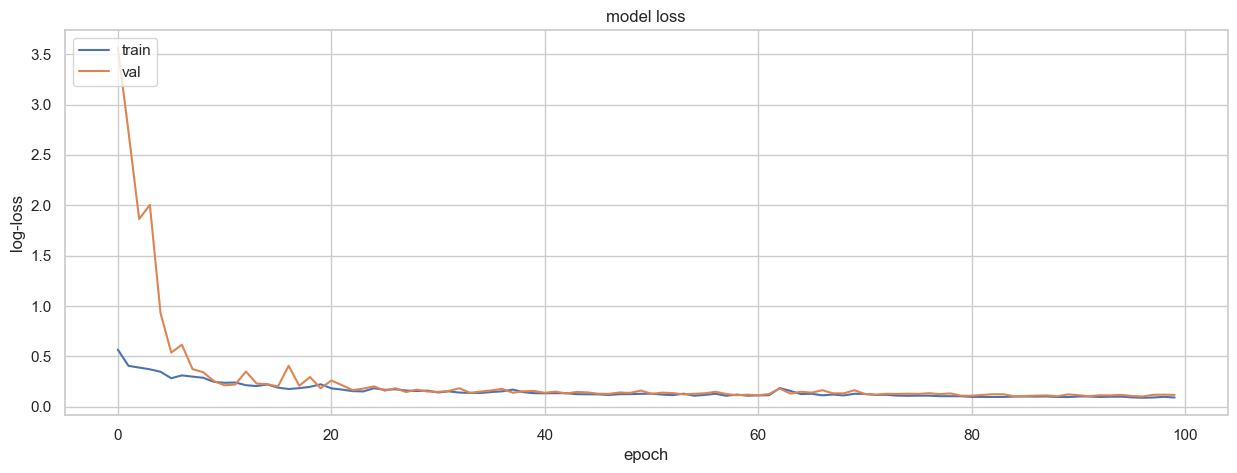

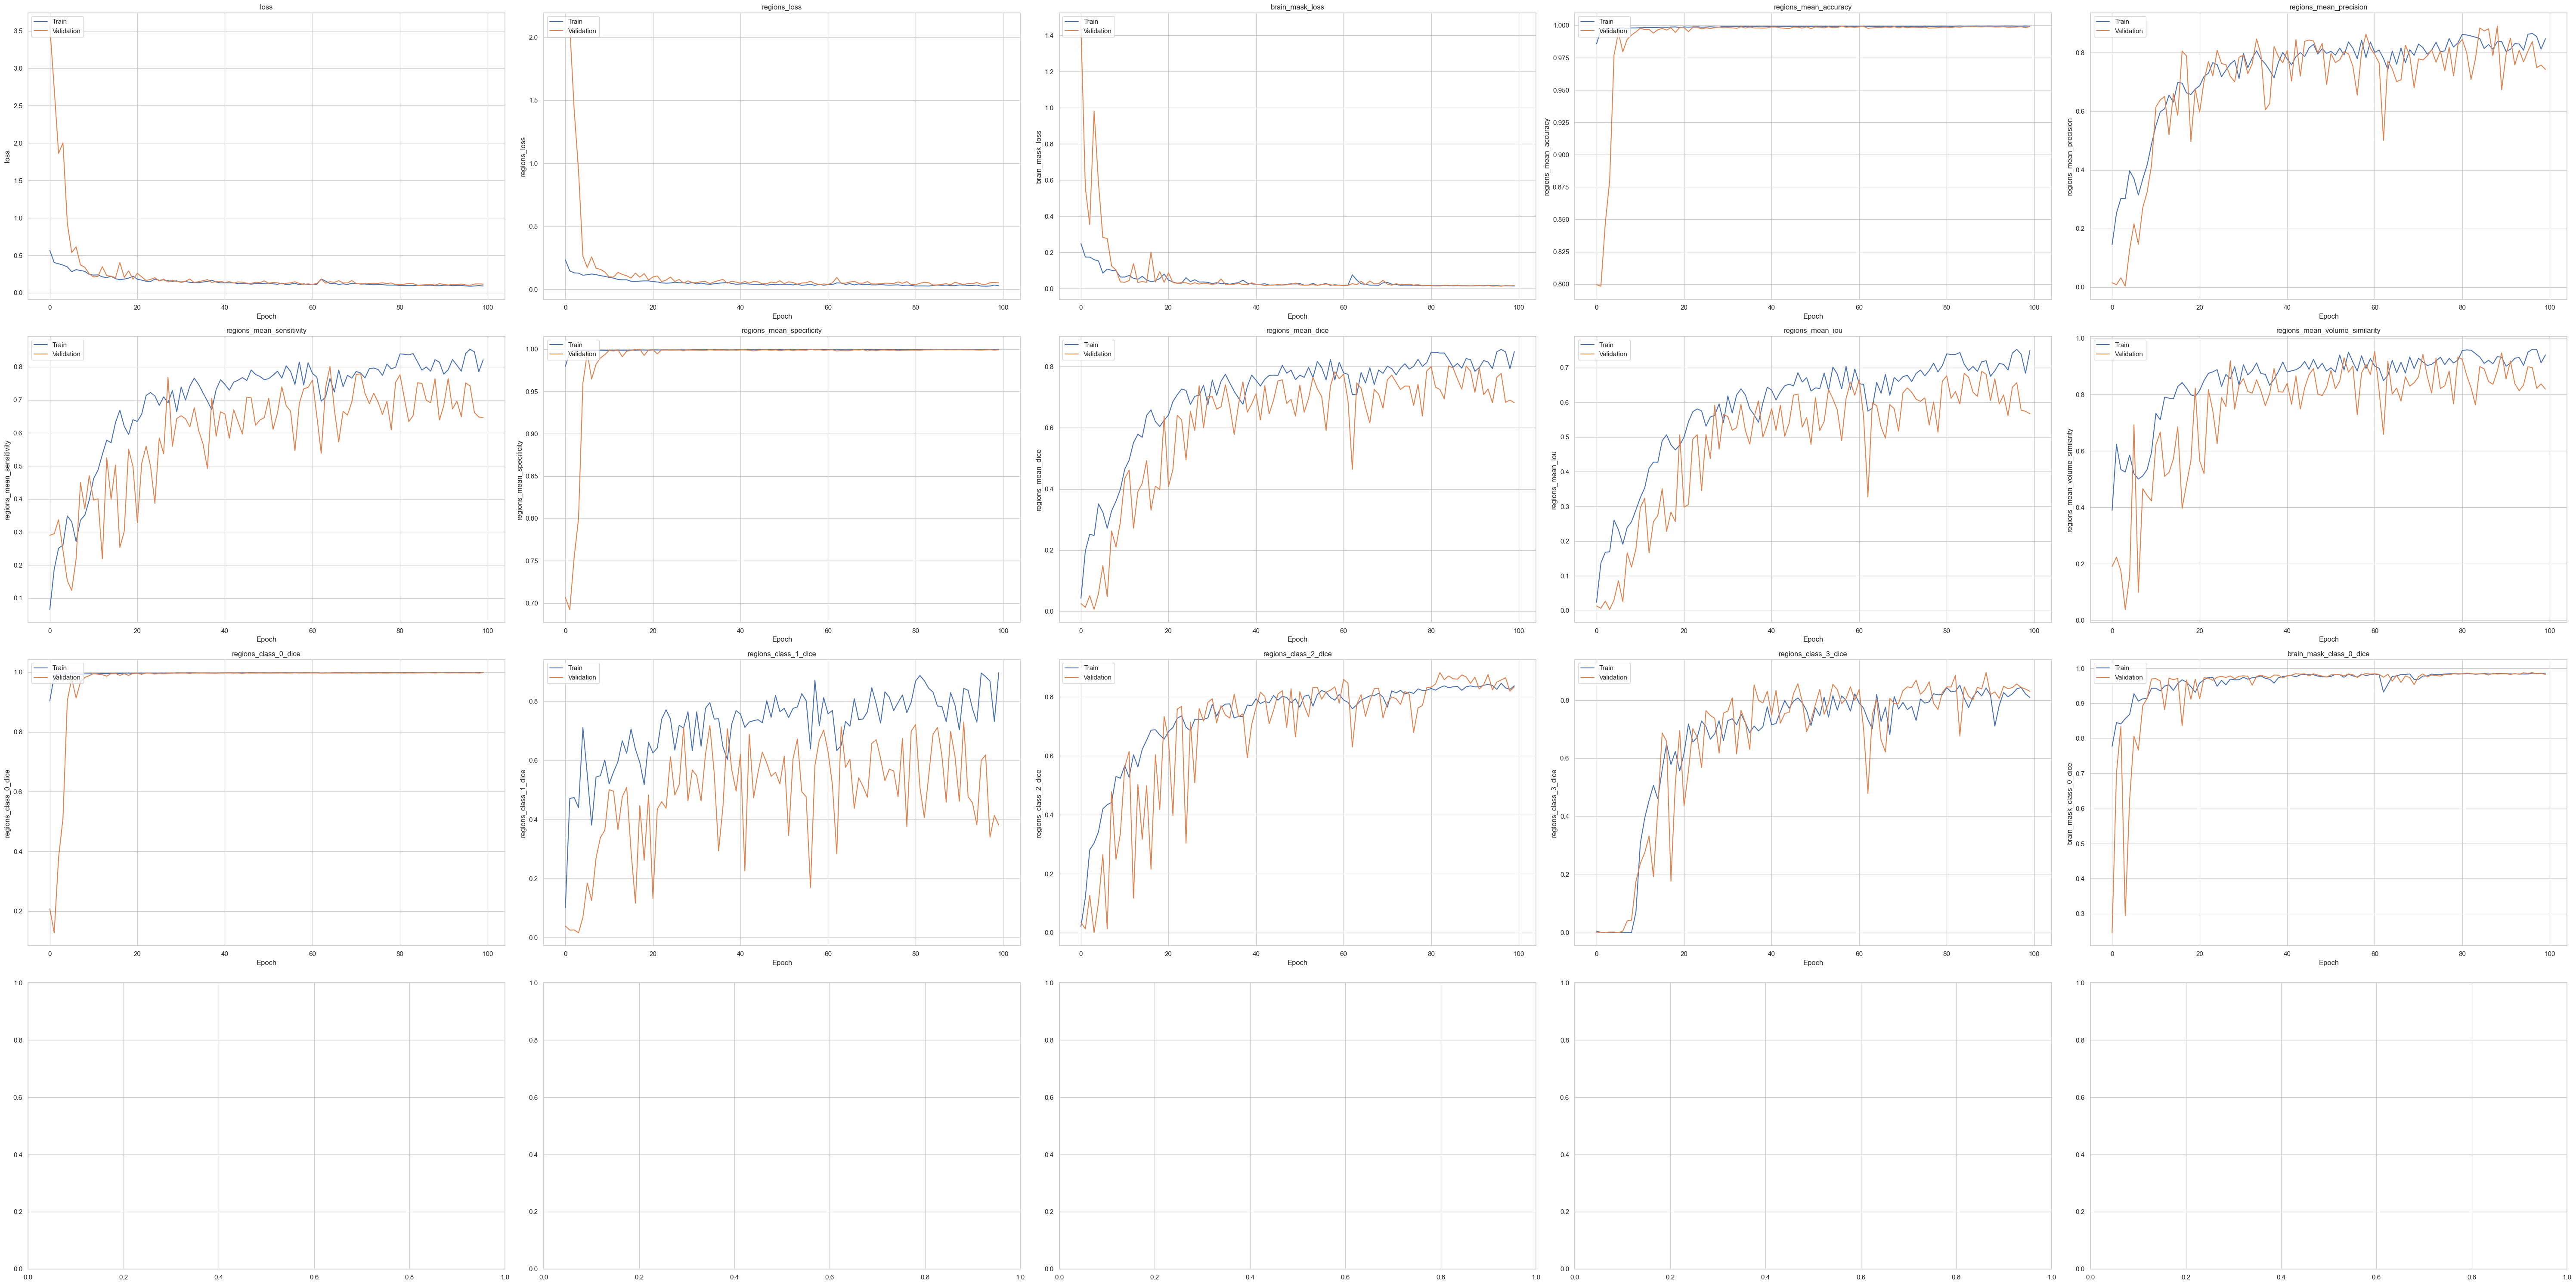

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:643: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:643: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:643: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:643: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\S

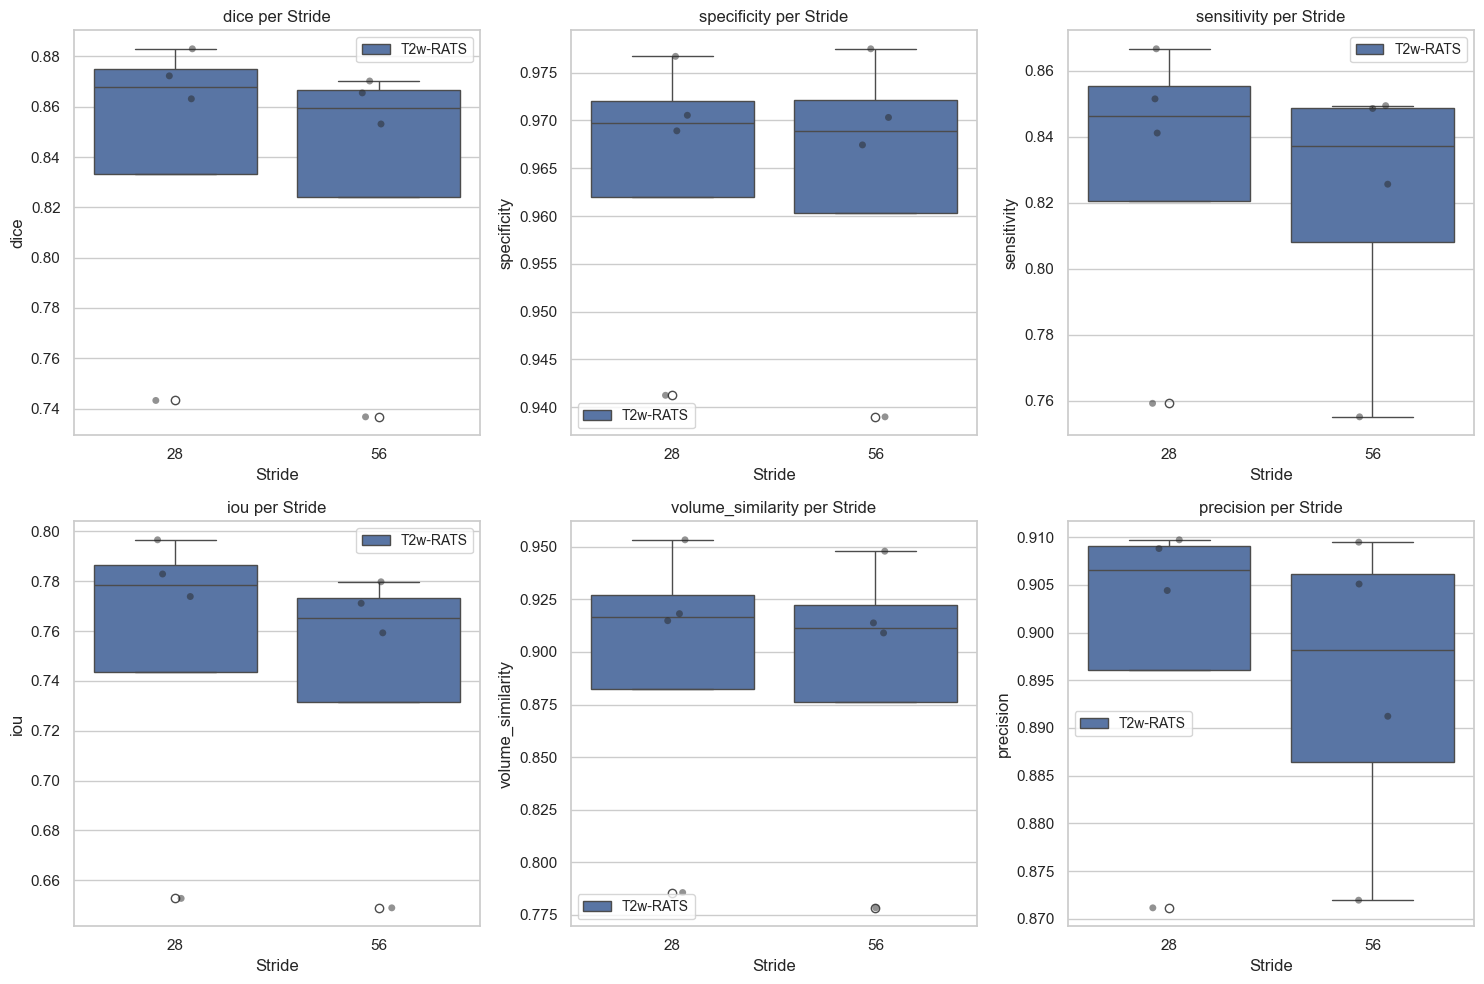

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:643: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:643: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:643: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\inference.py:643: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.


c:\Users\fmoro\SegmentationProject\S

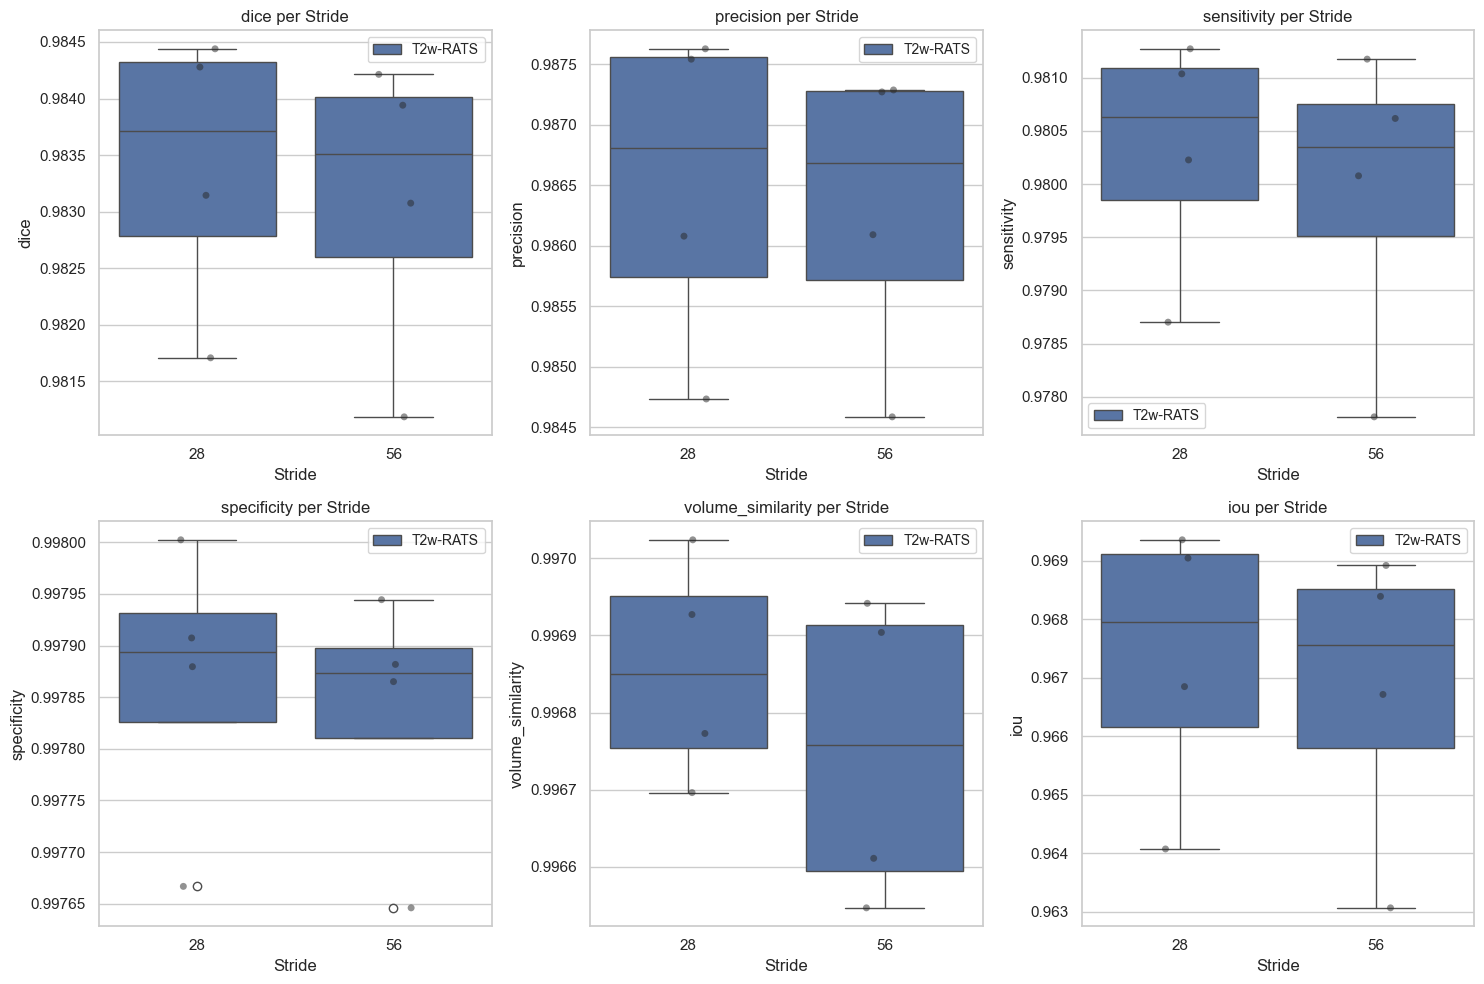

Validation rat:  RAT2
Trainig on:  85  samples
Validating on:  15  samples
Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (112, 112, 112)
- Batch size: 4
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True

Generator configuration:
- Dataset path: ..\dataset_roi
- Dimensions: (112, 112, 112)
- Batch size: 4
- Number of input channels: 1
- Number of classes: 4
- Shuffle: True


FOLD 1
Training on 85 examples (18 unique IDs)
Unique Train IDs: ['RAT1_14Days_CCI' 'RAT1_30Days_CCI' 'RAT1_60Days_CCI' 'RAT1_7Days_CCI'
 'RAT3_14Days_CCI' 'RAT3_30Days_CCI' 'RAT3_60Days_CCI' 'RAT3_7Days_CCI'
 'RAT4_14Days_CCI' 'RAT4_30Days_CCI' 'RAT4_60Days_CCI' 'RAT4_7Days_CCI'
 'RAT5_14Days_CCI' 'RAT5_30Days_CCI' 'RAT5_45Days_CCI' 'RAT5_60Days_CCI'
 'RAT5_7Days_CCI' 'T2w-RATS']
------------------------------
Validating on 15 examples (4 unique IDs)
Unique Validation IDs: ['RAT2_14Days_CCI' 'RAT2_30Days_CCI' 'RAT2_60Days_CCI' 'T2w-RATS']

Epoch 1/100
21/21 [==============

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_1\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_1\assets


21/21 [==============================] - 151s 6s/step - loss: 0.5505 - regions_loss: 0.1997 - brain_mask_loss: 0.2696 - regions_mean_accuracy: 0.9914 - regions_mean_precision: 0.1338 - regions_mean_sensitivity: 0.1022 - regions_mean_specificity: 0.9879 - regions_mean_dice: 0.0529 - regions_mean_iou: 0.0286 - regions_mean_volume_similarity: 0.3624 - regions_class_0_dice: 0.9567 - regions_class_1_dice: 0.0756 - regions_class_2_dice: 0.0169 - regions_class_3_dice: 0.0663 - brain_mask_class_0_dice: 0.7537 - val_loss: 3.2909 - val_regions_loss: 1.5665 - val_brain_mask_loss: 1.6444 - val_regions_mean_accuracy: 0.8434 - val_regions_mean_precision: 0.0092 - val_regions_mean_sensitivity: 0.2329 - val_regions_mean_specificity: 0.7880 - val_regions_mean_dice: 0.0168 - val_regions_mean_iou: 0.0086 - val_regions_mean_volume_similarity: 0.4198 - val_regions_class_0_dice: 0.5302 - val_regions_class_1_dice: 0.0475 - val_regions_class_2_dice: 6.4267e-04 - val_regions_class_3_dice: 0.0022 - val_brain_ma

INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_1\assets


INFO:tensorflow:Assets written to: ../results/multi_task_k_fold_ep500_27-06-2024_14-13/checkpoint\fold_1\assets


21/21 [==============================] - 123s 6s/step - loss: 0.3914 - regions_loss: 0.1430 - brain_mask_loss: 0.1692 - regions_mean_accuracy: 0.9962 - regions_mean_precision: 0.3212 - regions_mean_sensitivity: 0.2482 - regions_mean_specificity: 0.9958 - regions_mean_dice: 0.2114 - regions_mean_iou: 0.1302 - regions_mean_volume_similarity: 0.5200 - regions_class_0_dice: 0.9899 - regions_class_1_dice: 0.3099 - regions_class_2_dice: 0.1195 - regions_class_3_dice: 0.2048 - brain_mask_class_0_dice: 0.8459 - val_loss: 2.7571 - val_regions_loss: 1.2098 - val_brain_mask_loss: 1.4689 - val_regions_mean_accuracy: 0.8954 - val_regions_mean_precision: 0.0064 - val_regions_mean_sensitivity: 0.1641 - val_regions_mean_specificity: 0.8448 - val_regions_mean_dice: 0.0123 - val_regions_mean_iou: 0.0063 - val_regions_mean_volume_similarity: 0.0245 - val_regions_class_0_dice: 0.6884 - val_regions_class_1_dice: 0.0370 - val_regions_class_2_dice: 2.0571e-10 - val_regions_class_3_dice: 7.2498e-10 - val_brai

In [11]:
fve_callbacks = [fve_callback_regions, fve_callback_skullstrip]

# Call k_fold_loop to start the training
history_k, fve_evaluations = k_fold_loop(model_callback, fve_callbacks, config, train_and_test_ids, metrics)

Best metrics for each fold
|- Fold 0 -----------------
|- Best epoch: 76
|- val_regions_mean_accuracy: 0.9993815422058105
|- val_regions_mean_precision: 0.8997864723205566
|- val_regions_mean_sensitivity: 0.8287255167961121
|- val_regions_mean_specificity: 0.9995590448379517
|- val_regions_mean_dice: 0.8613046407699585
|- val_regions_mean_iou: 0.7583054304122925
|- val_regions_mean_volume_similarity: 0.9498388171195984
|- val_regions_class_0_dice: 0.998799204826355
|- val_regions_class_1_dice: 0.8494979739189148
|- val_regions_class_2_dice: 0.8955062031745911
|- val_regions_class_3_dice: 0.8389098048210144
|- Fold 1 -----------------
|- Best epoch: 90
|- val_regions_mean_accuracy: 0.9989750385284424
|- val_regions_mean_precision: 0.9012389779090881
|- val_regions_mean_sensitivity: 0.8313865661621094
|- val_regions_mean_specificity: 0.9992637038230896
|- val_regions_mean_dice: 0.8636496067047119
|- val_regions_mean_iou: 0.7645477652549744
|- val_regions_mean_volume_similarity: 0.9573528

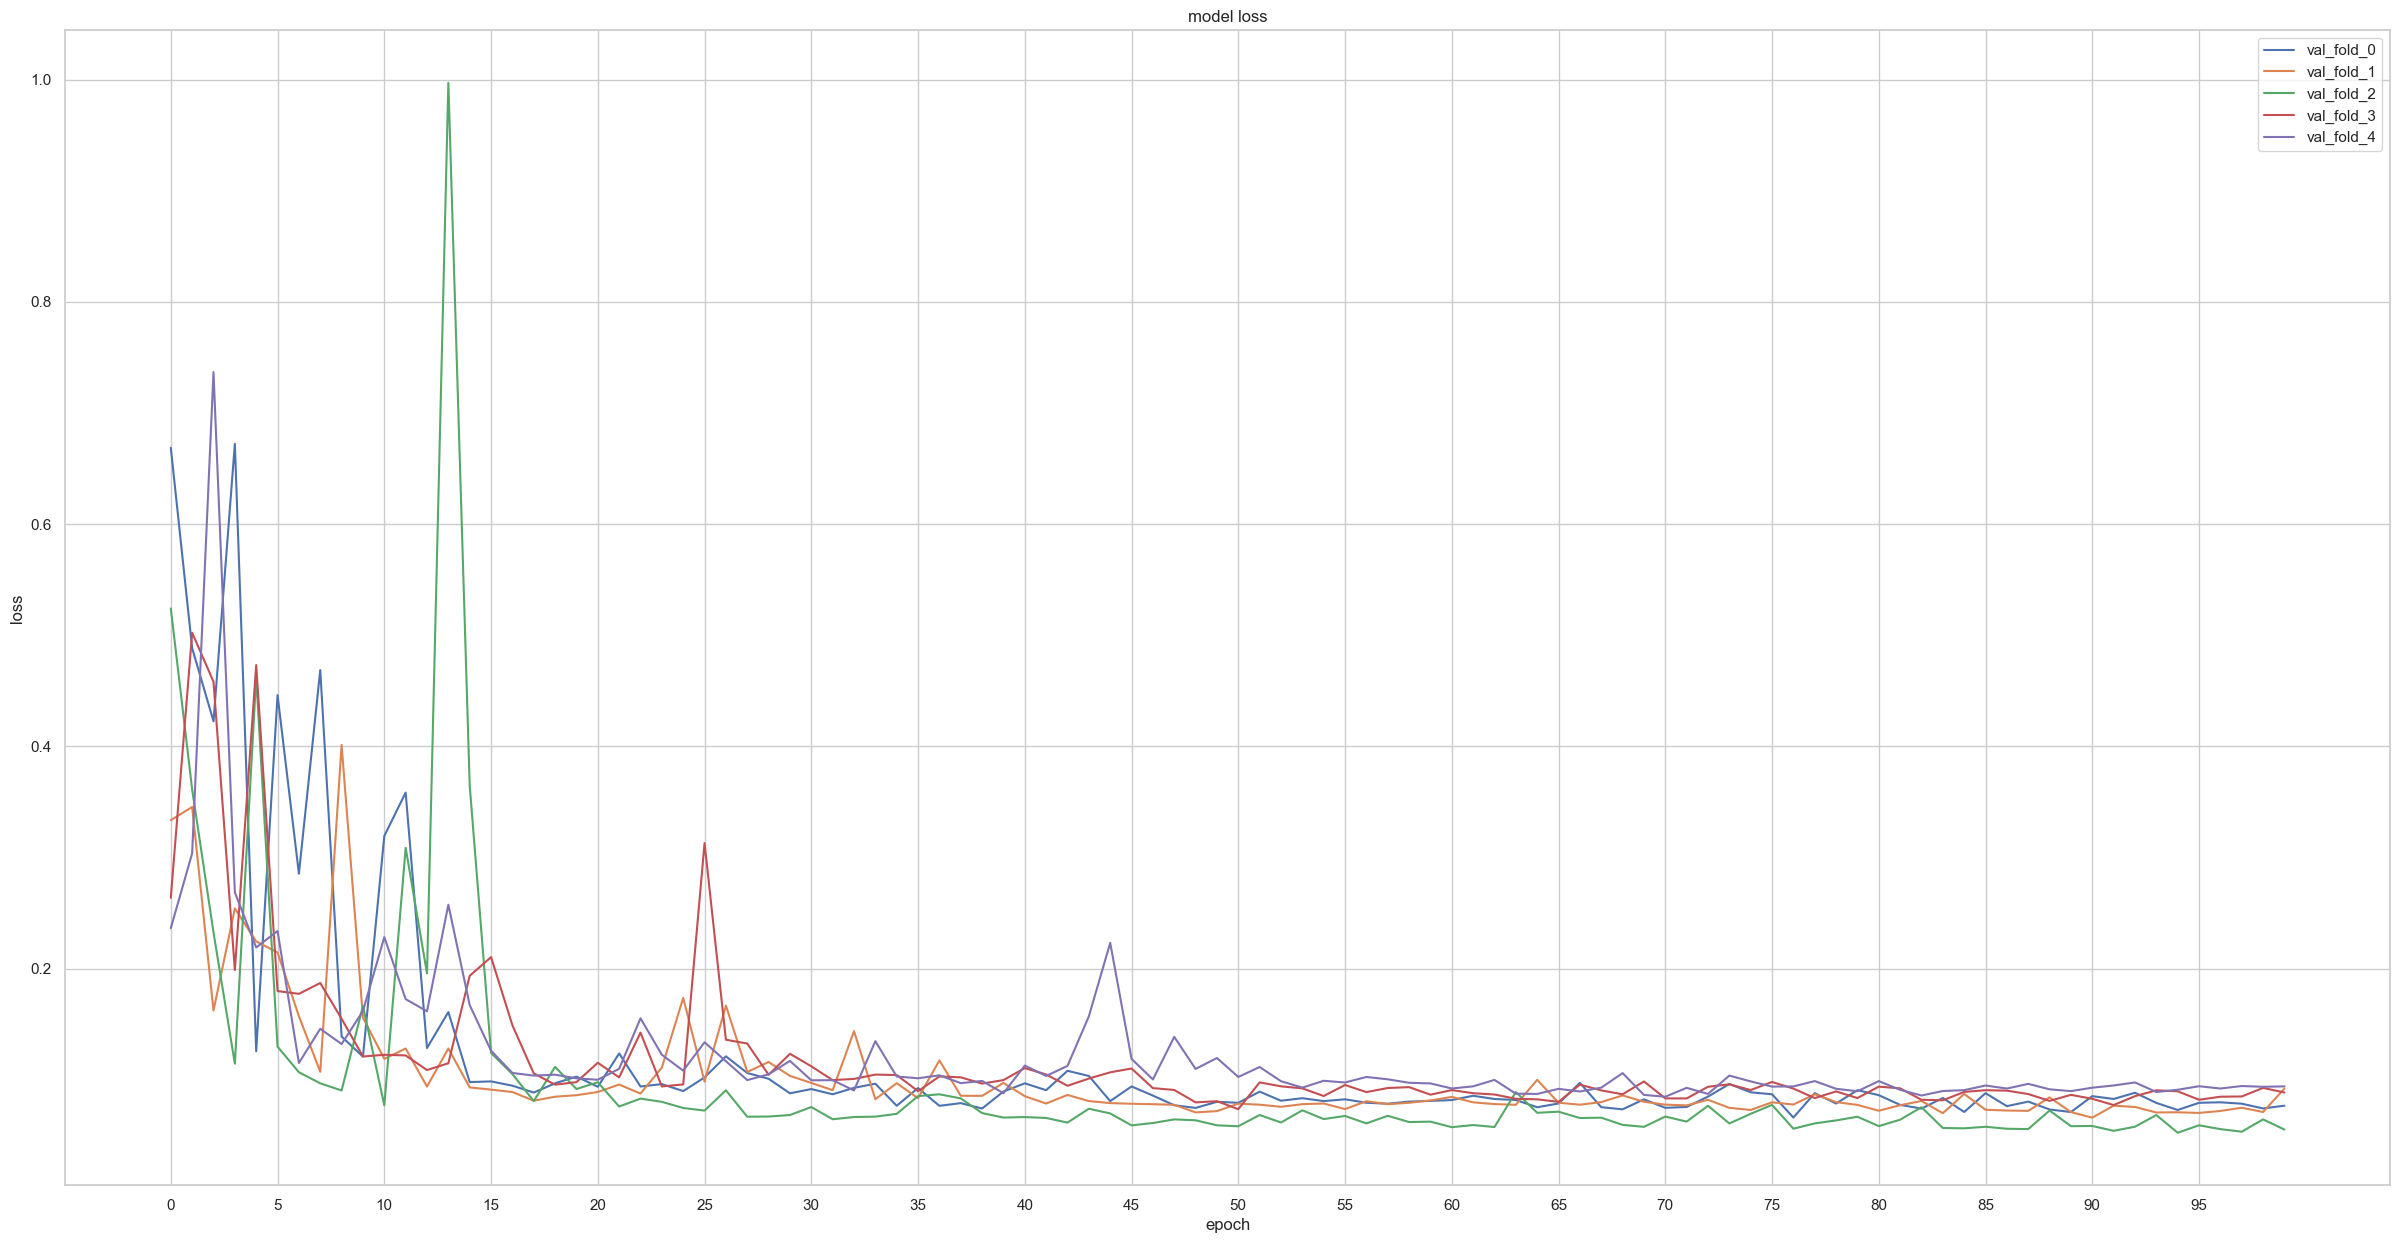

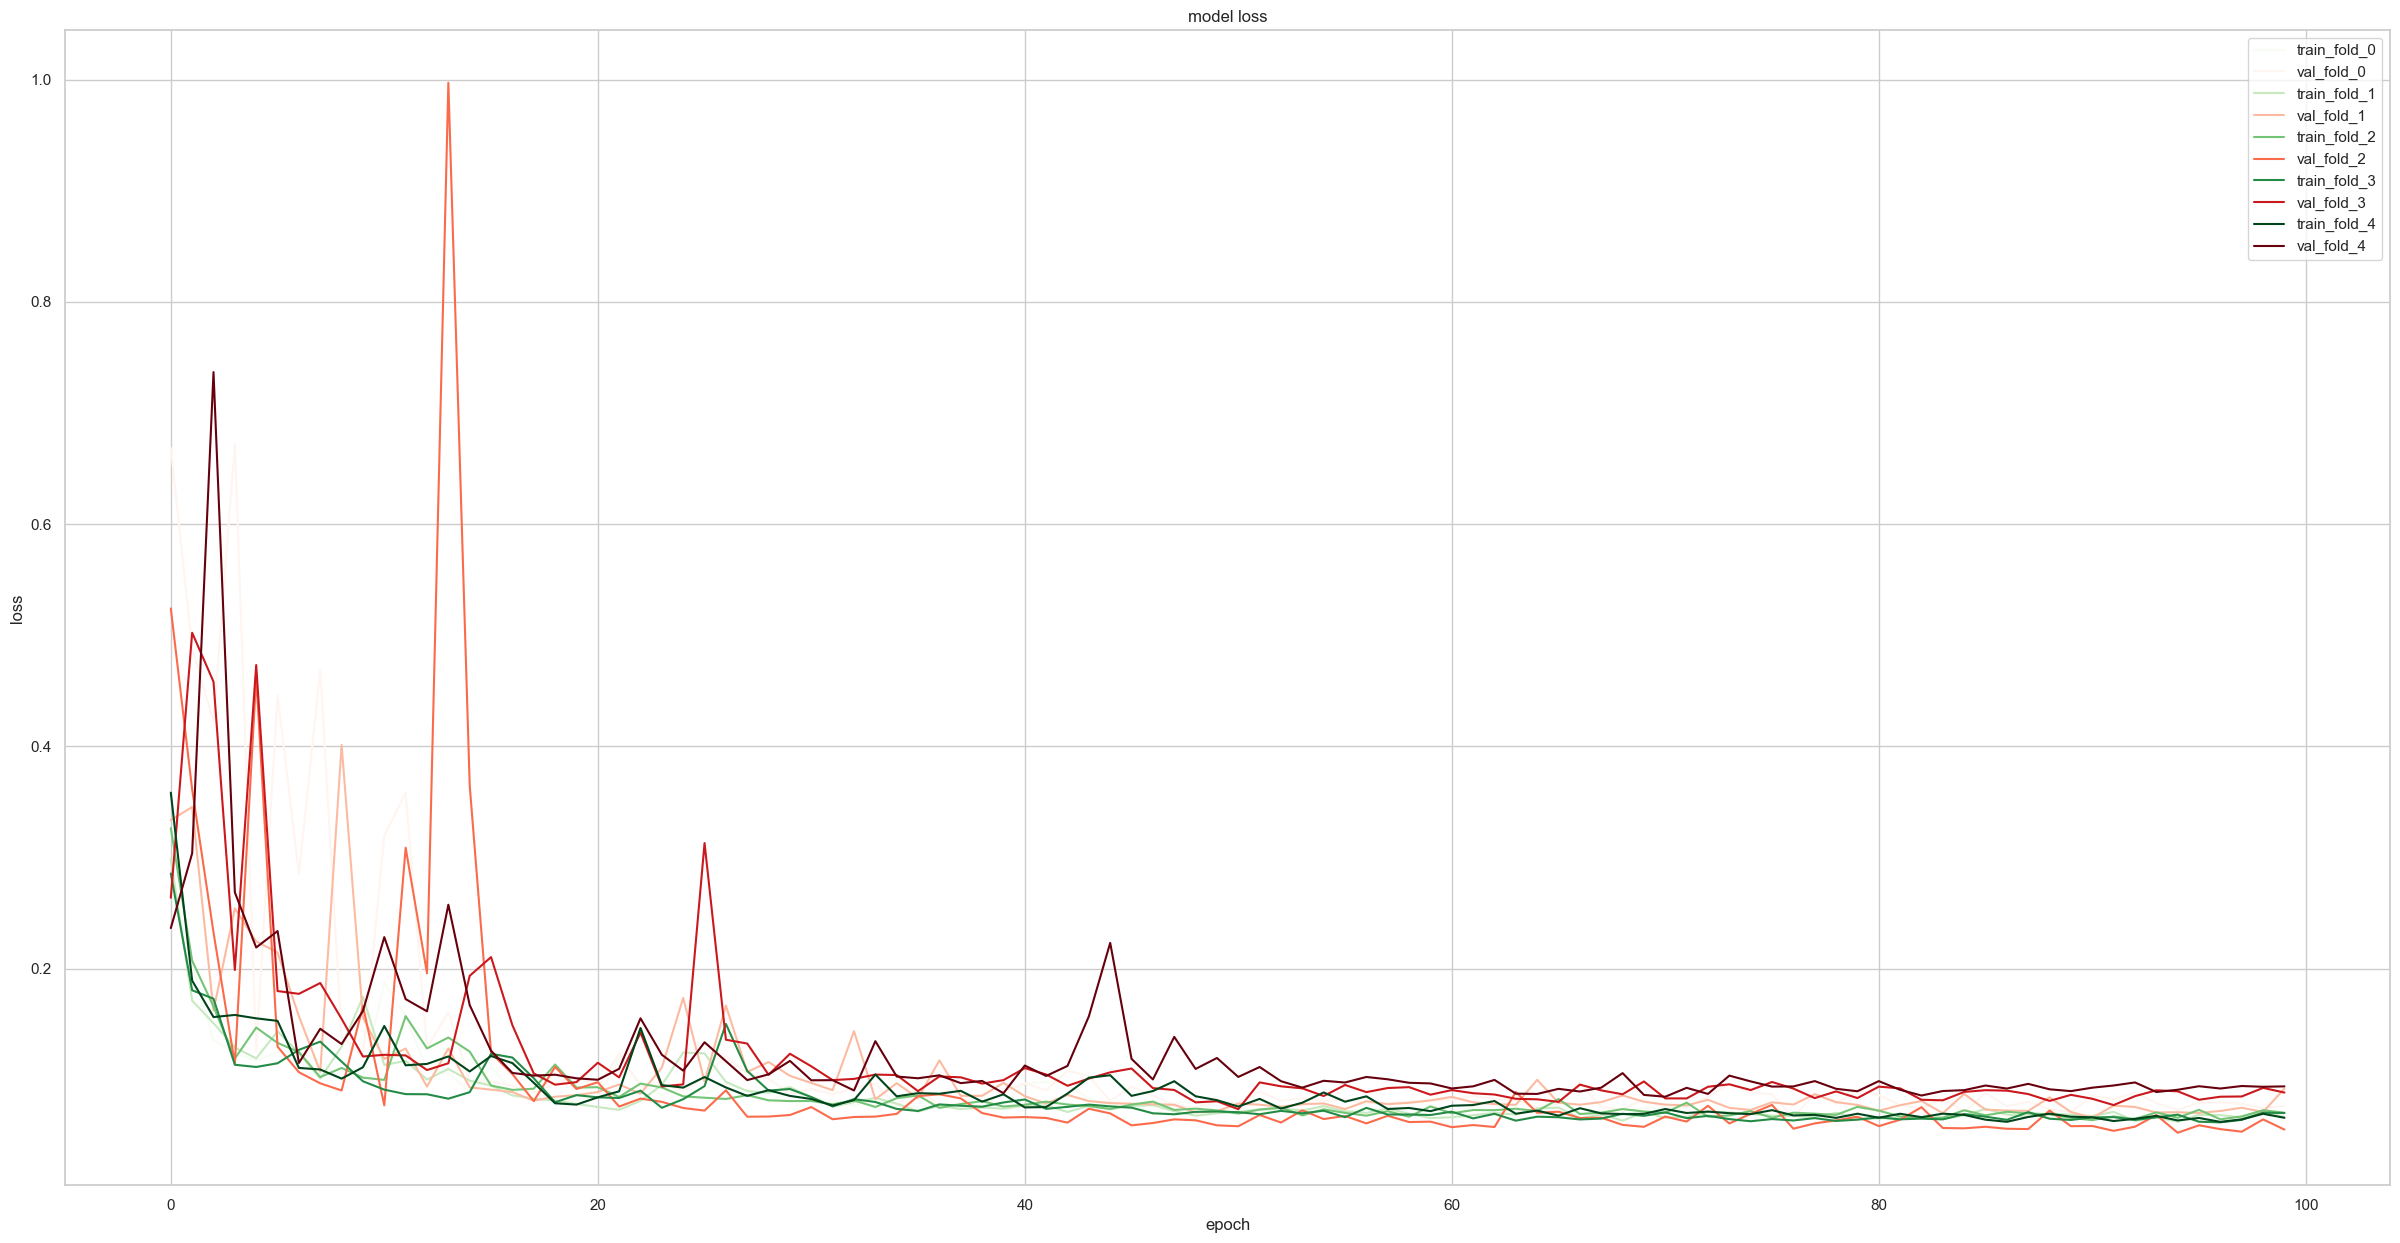

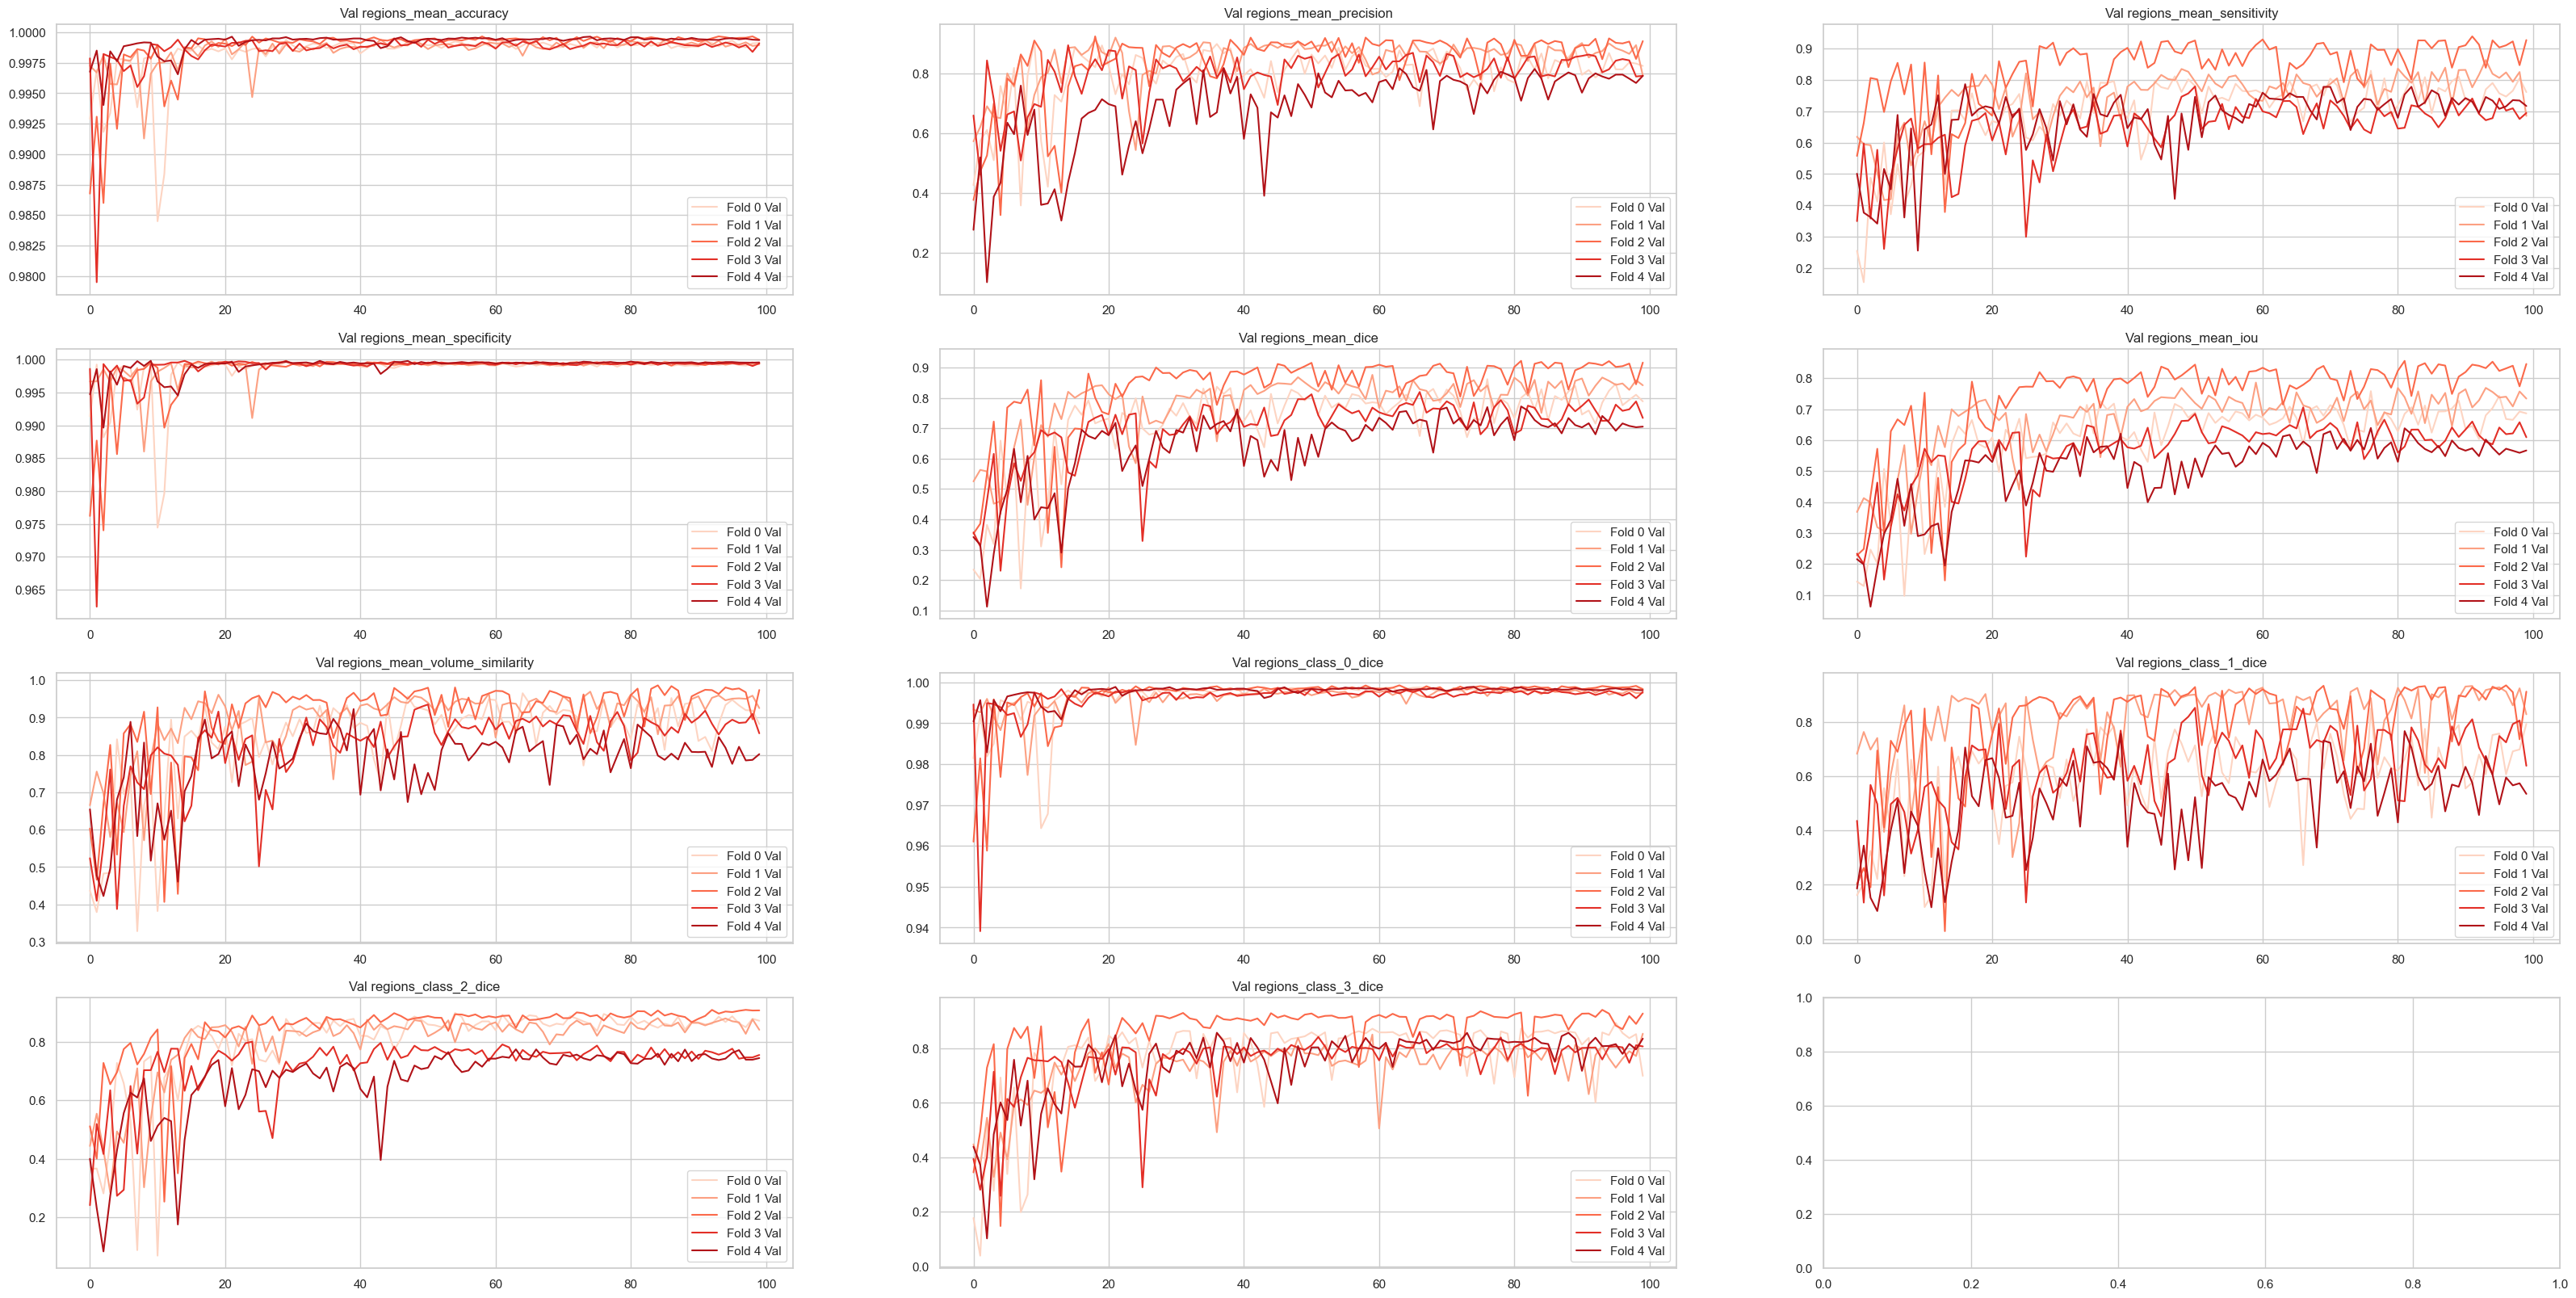

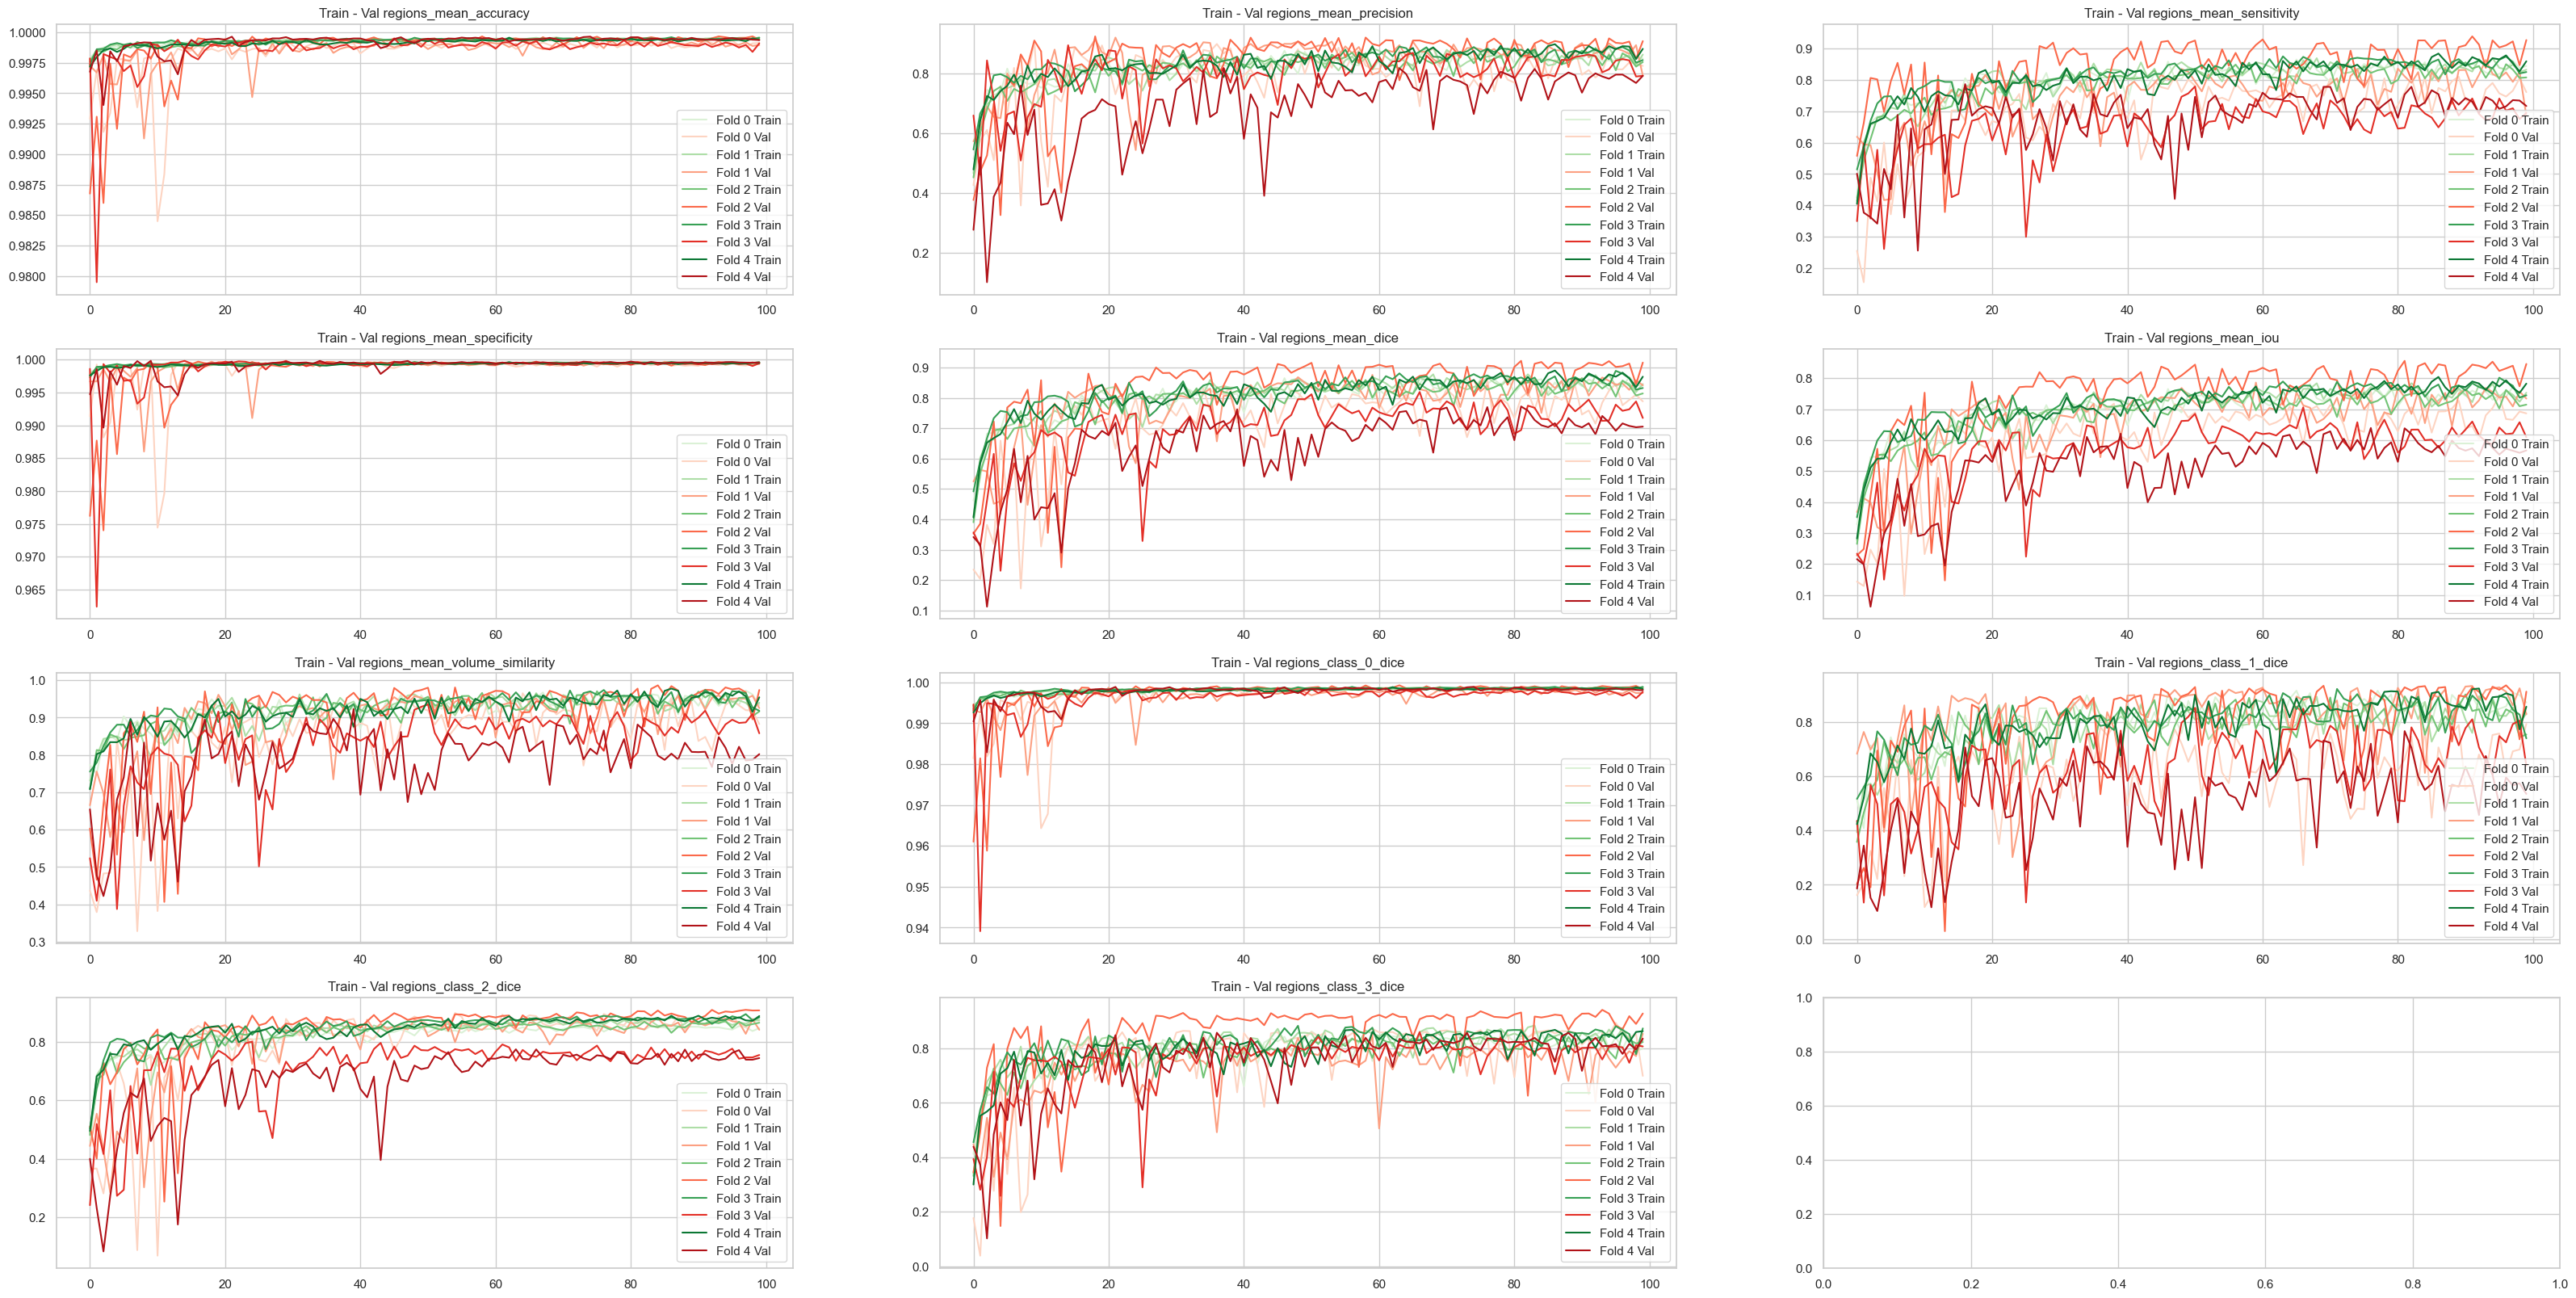

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




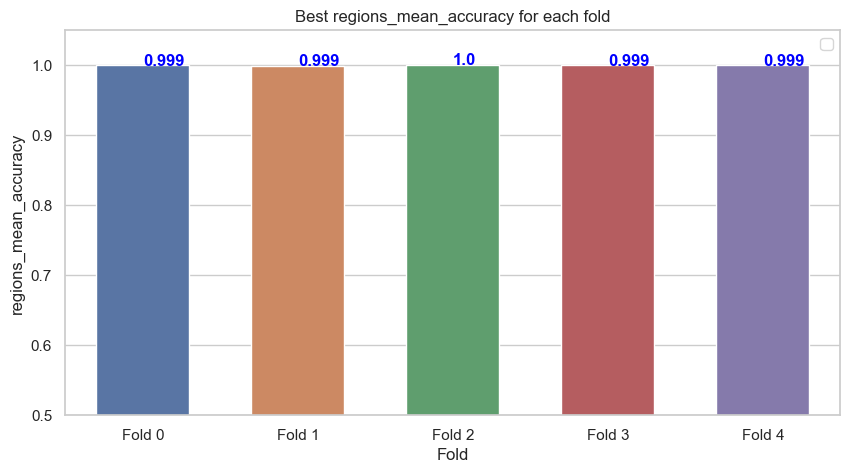

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




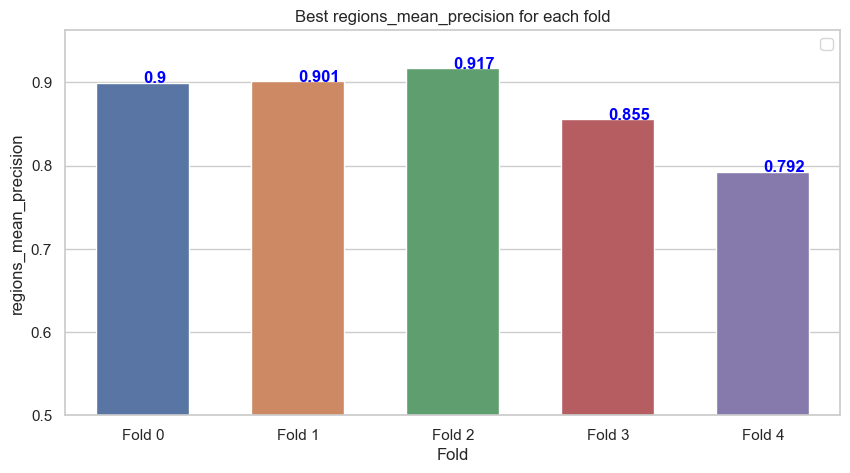

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




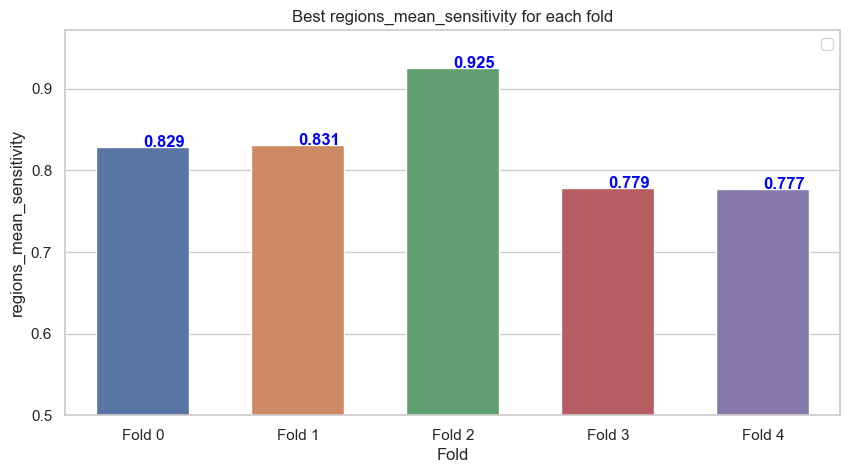

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




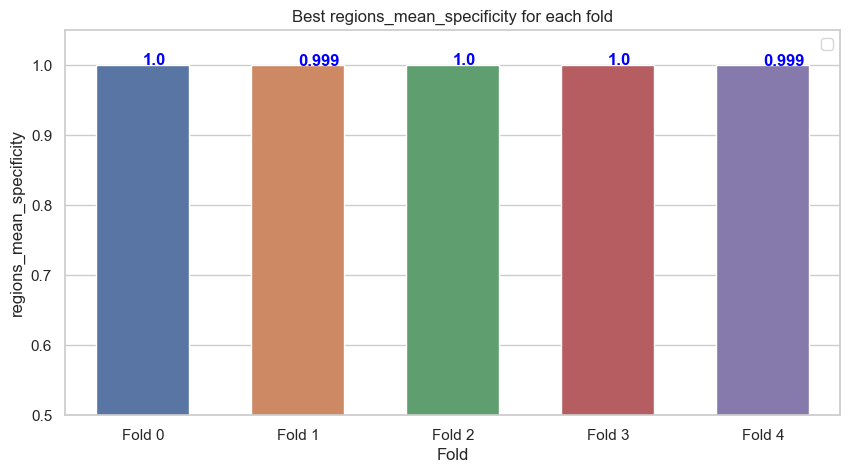

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




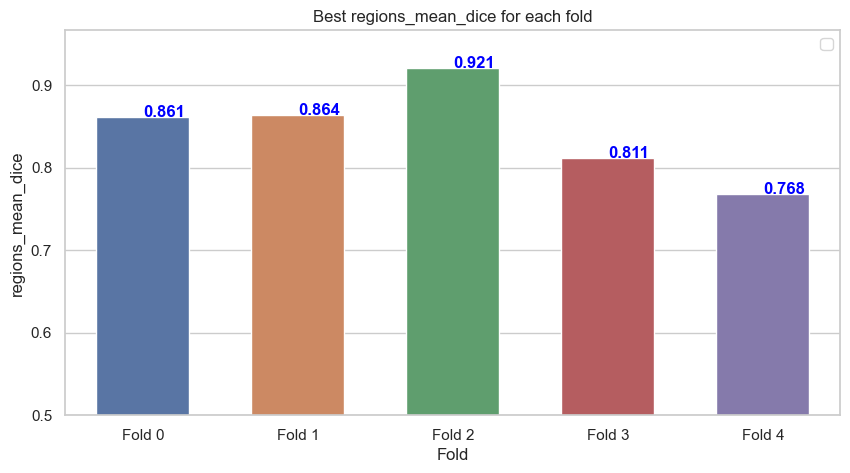

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




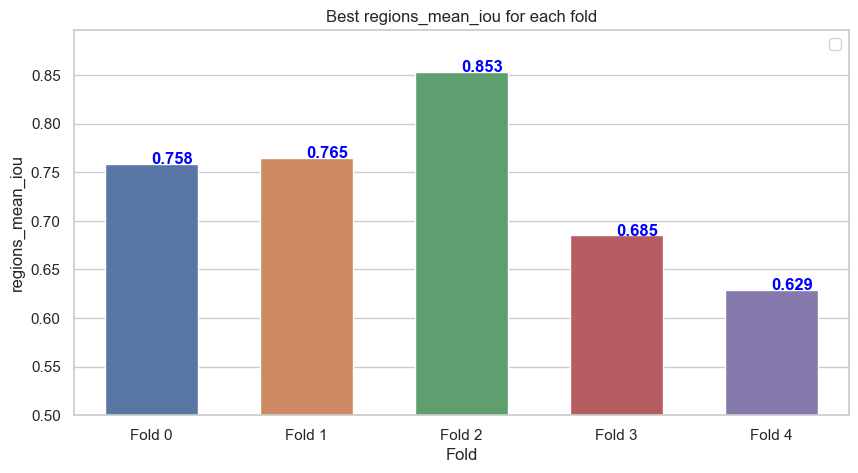

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




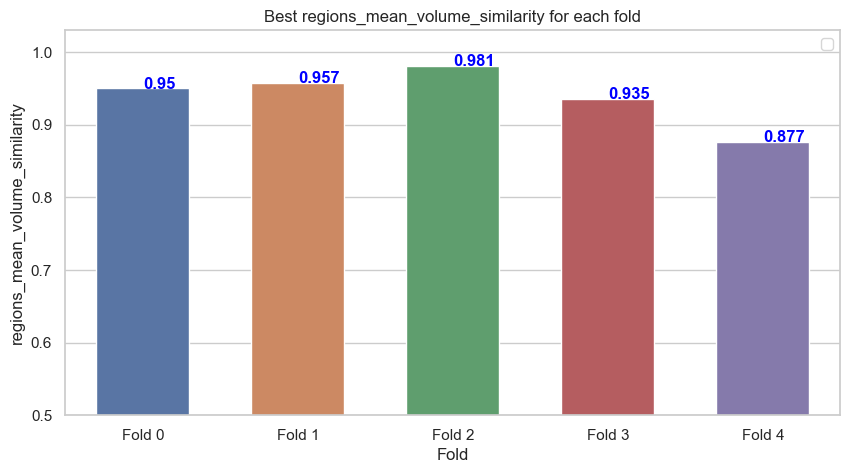

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




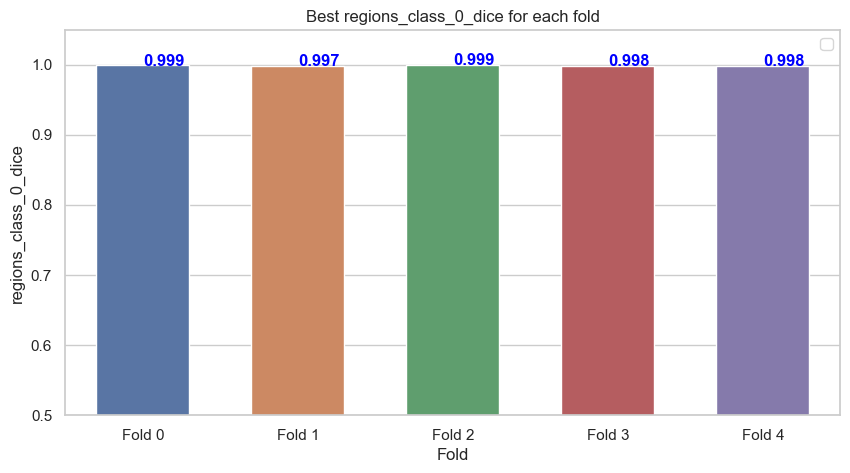

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




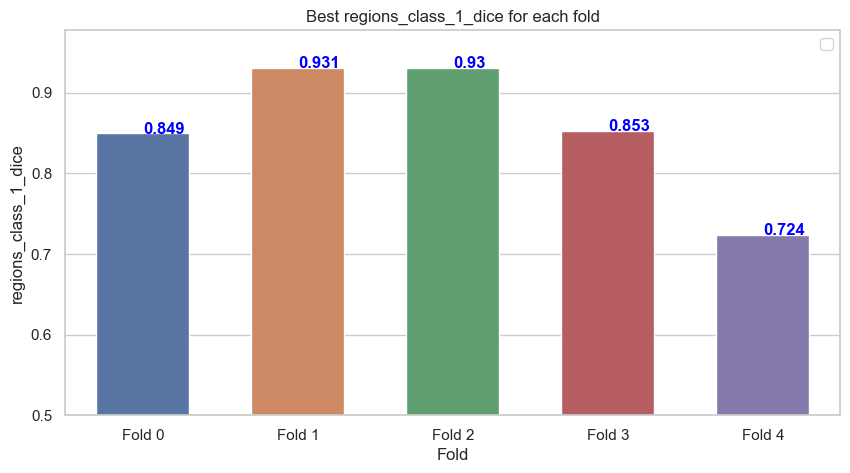

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




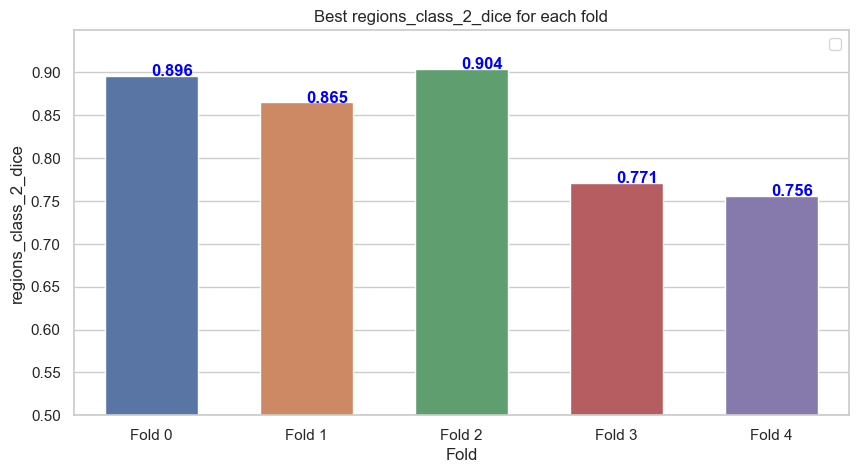

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




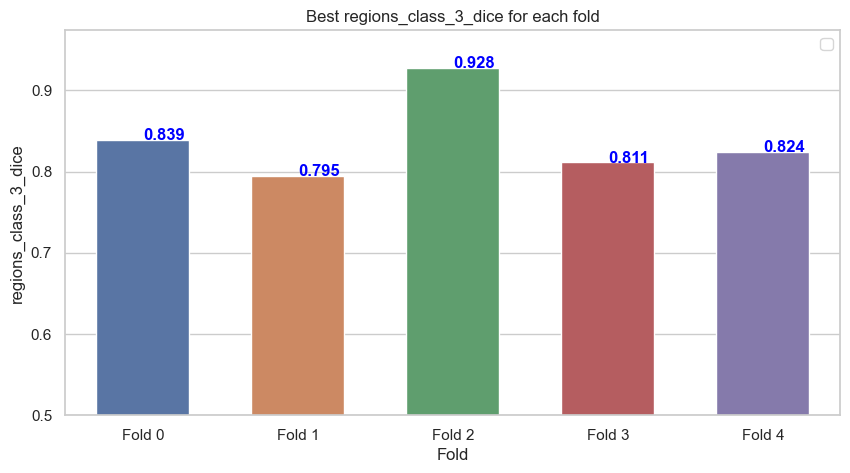

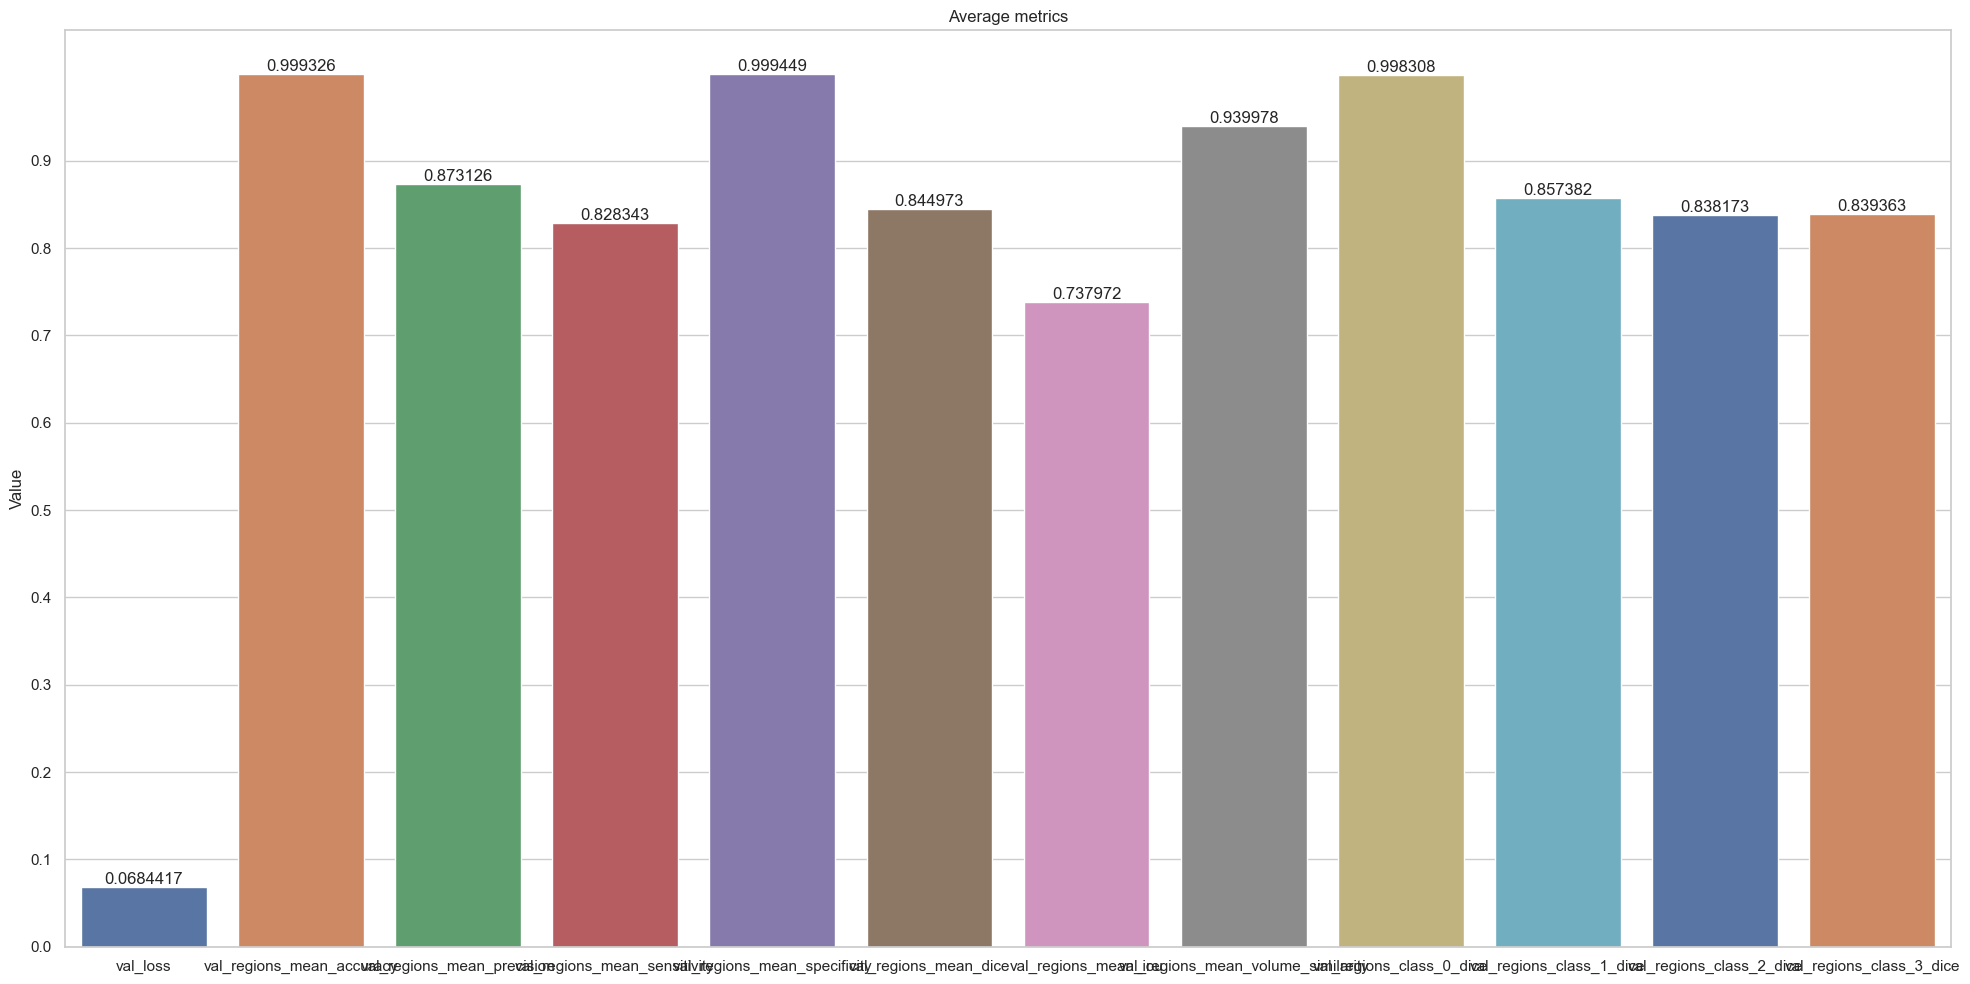

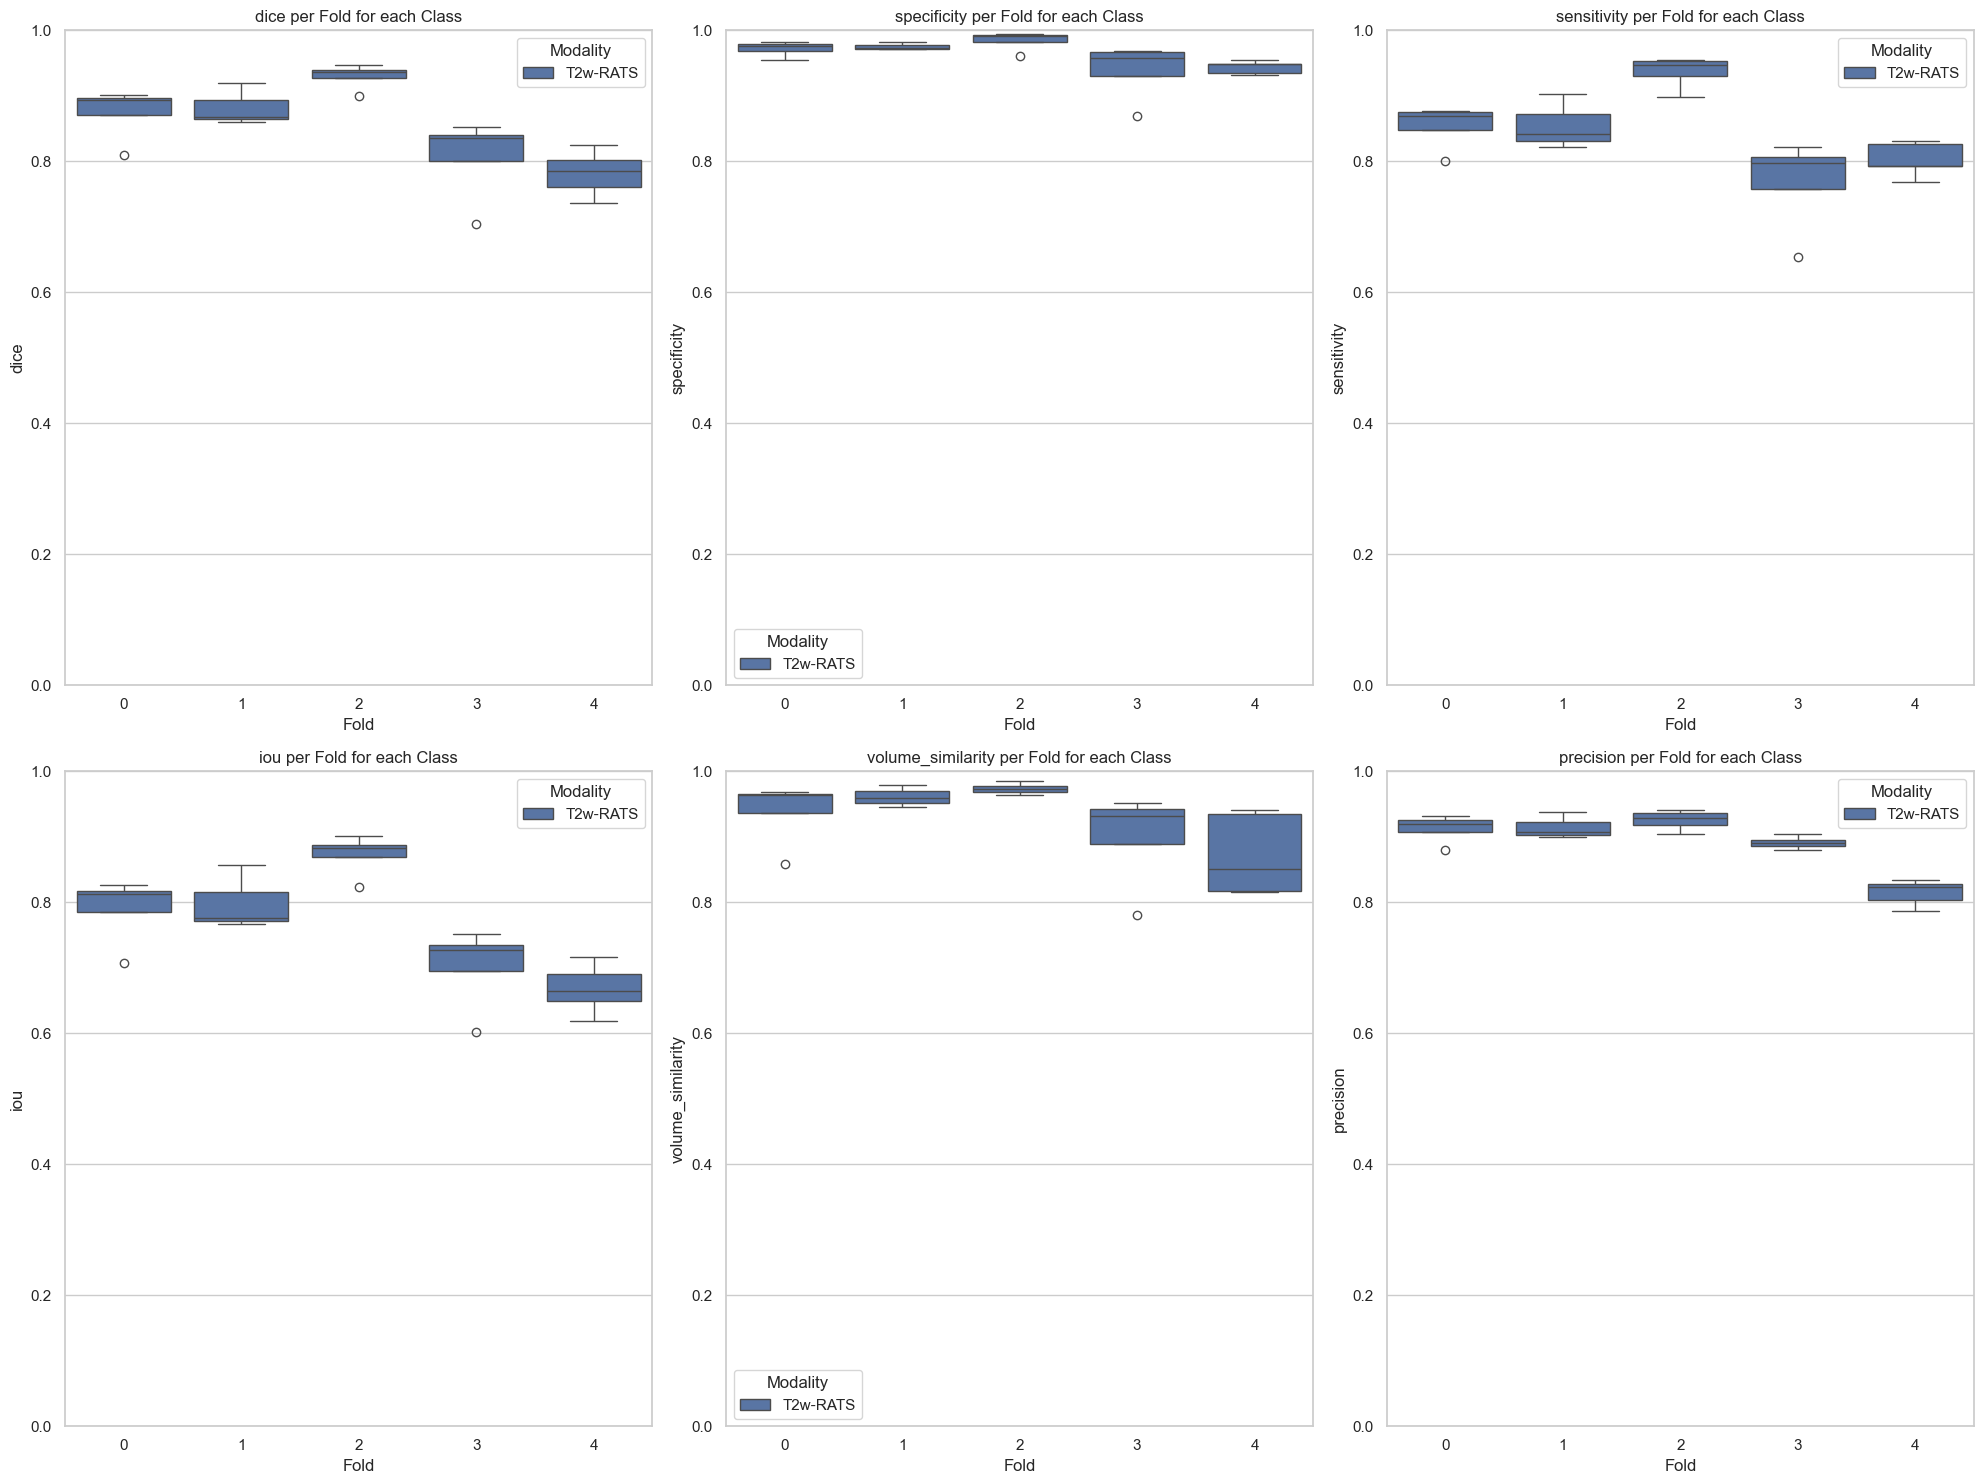

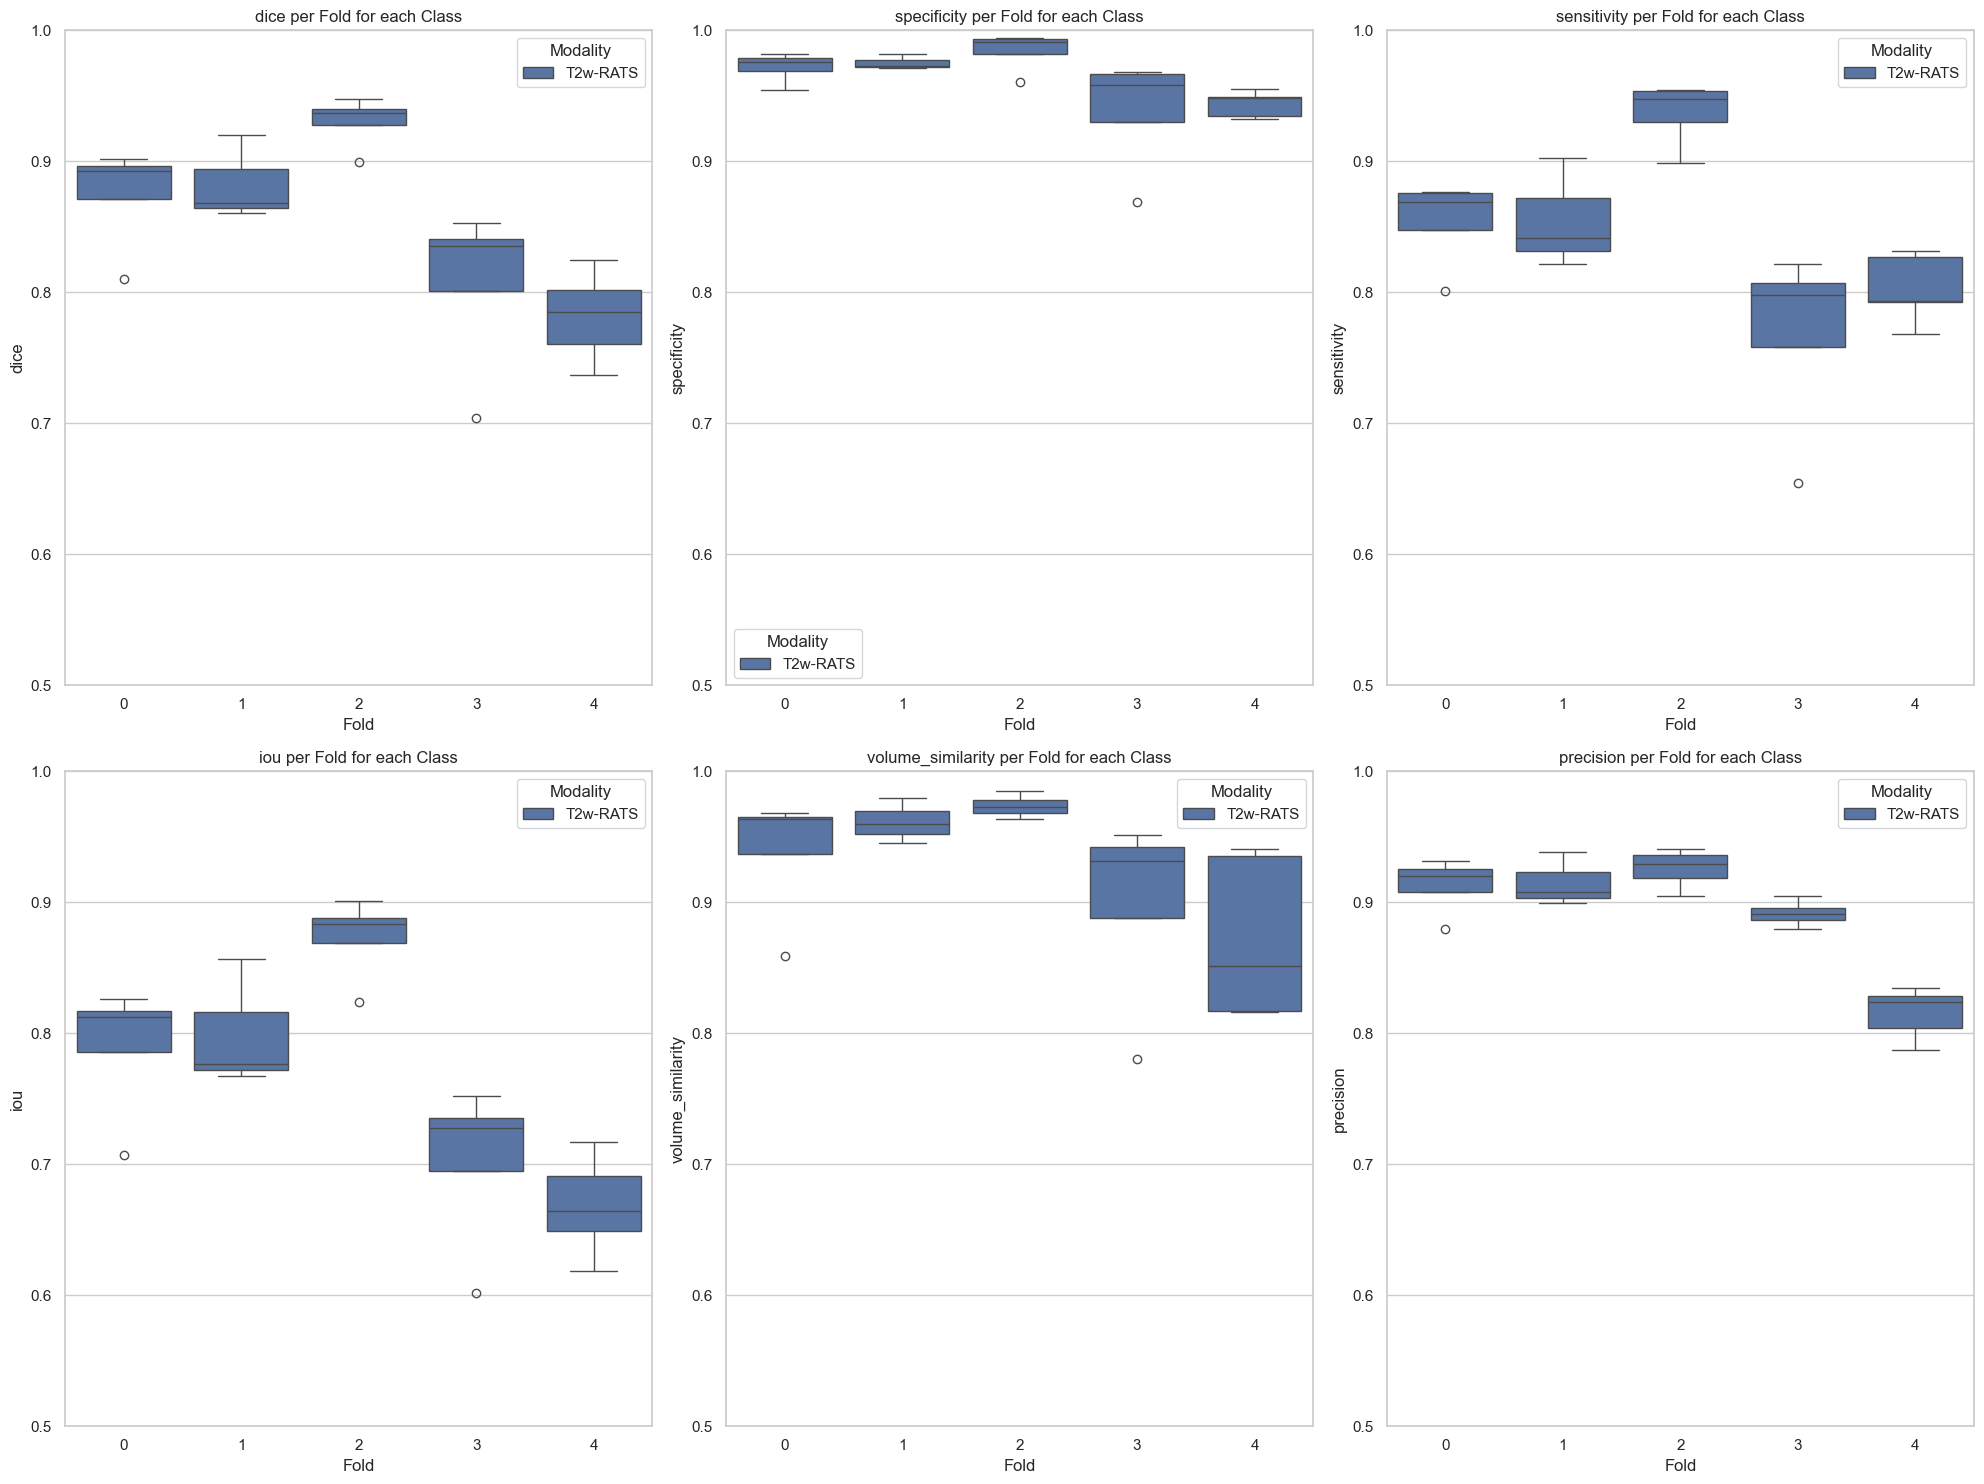

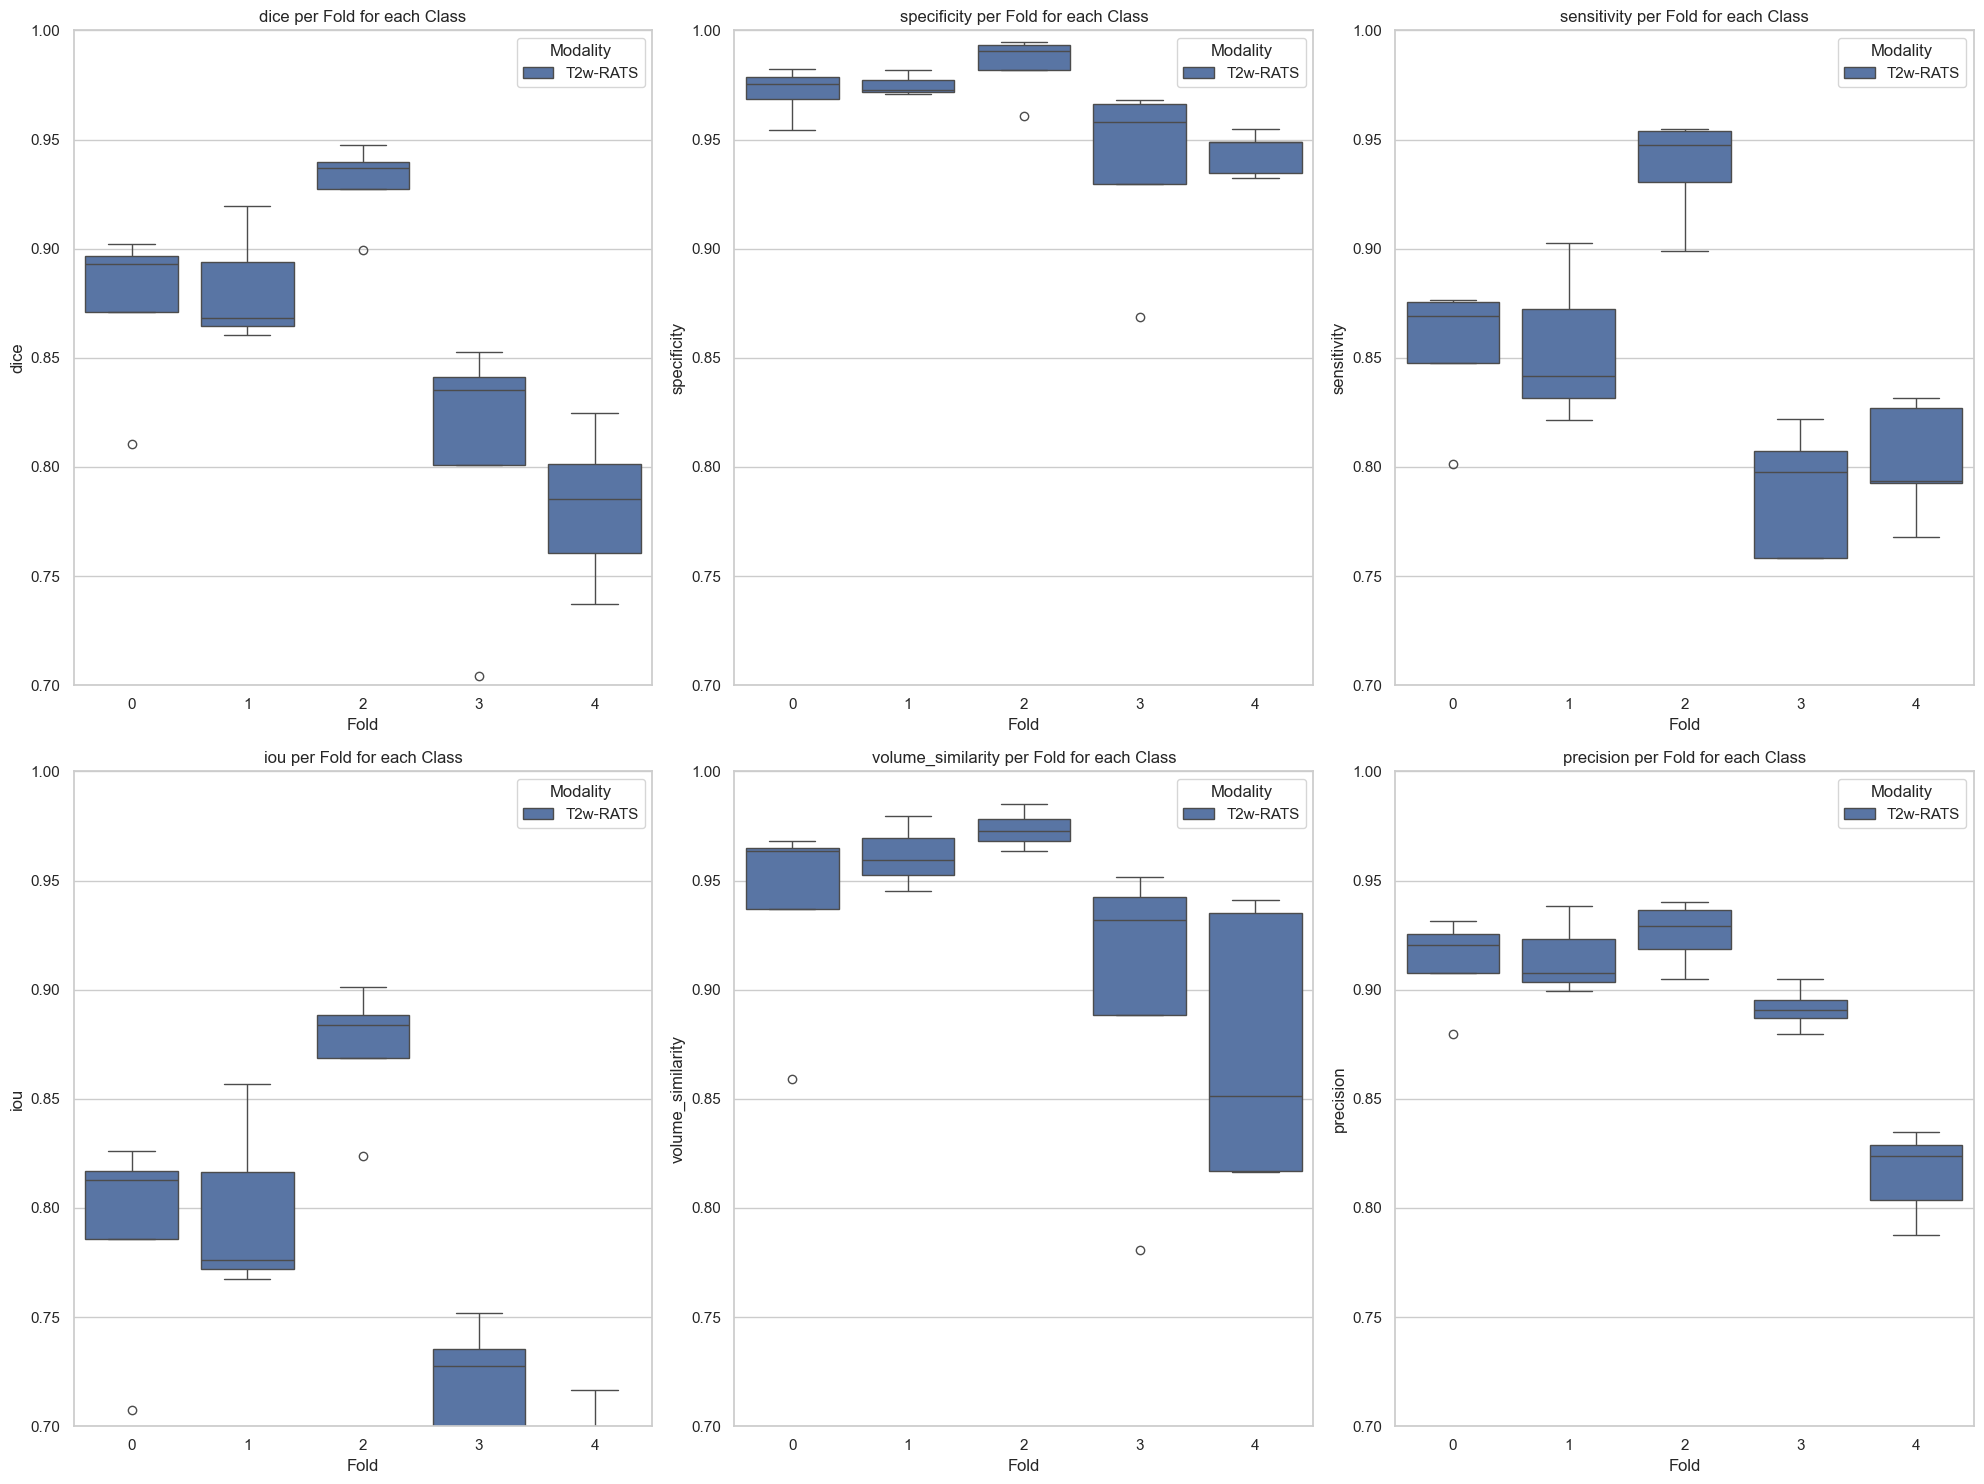

Best metrics for each fold
|- Fold 0 -----------------
|- Best epoch: 76
|- val_brain_mask_class_0_dice: 0.9854360818862915
|- Fold 1 -----------------
|- Best epoch: 90
|- val_brain_mask_class_0_dice: 0.9893025755882263
|- Fold 2 -----------------
|- Best epoch: 94
|- val_brain_mask_class_0_dice: 0.9878783226013184
|- Fold 3 -----------------
|- Best epoch: 50
|- val_brain_mask_class_0_dice: 0.9868232011795044
|- Fold 4 -----------------
|- Best epoch: 70
|- val_brain_mask_class_0_dice: 0.9878859519958496
Average metrics for each fold
Average metrics
|- AVG VAL - val_loss: 0.0684416800737381
|- AVG VAL - val_brain_mask_class_0_dice: 0.9874652266502381
+---+-----------------+-------------------+--------+----------+--------------------+--------------------+------+
|   |     Subject     |      Metric       | Stride | Modality |      Class: 0      |        Mean        | Fold |
+---+-----------------+-------------------+--------+----------+--------------------+--------------------+------+


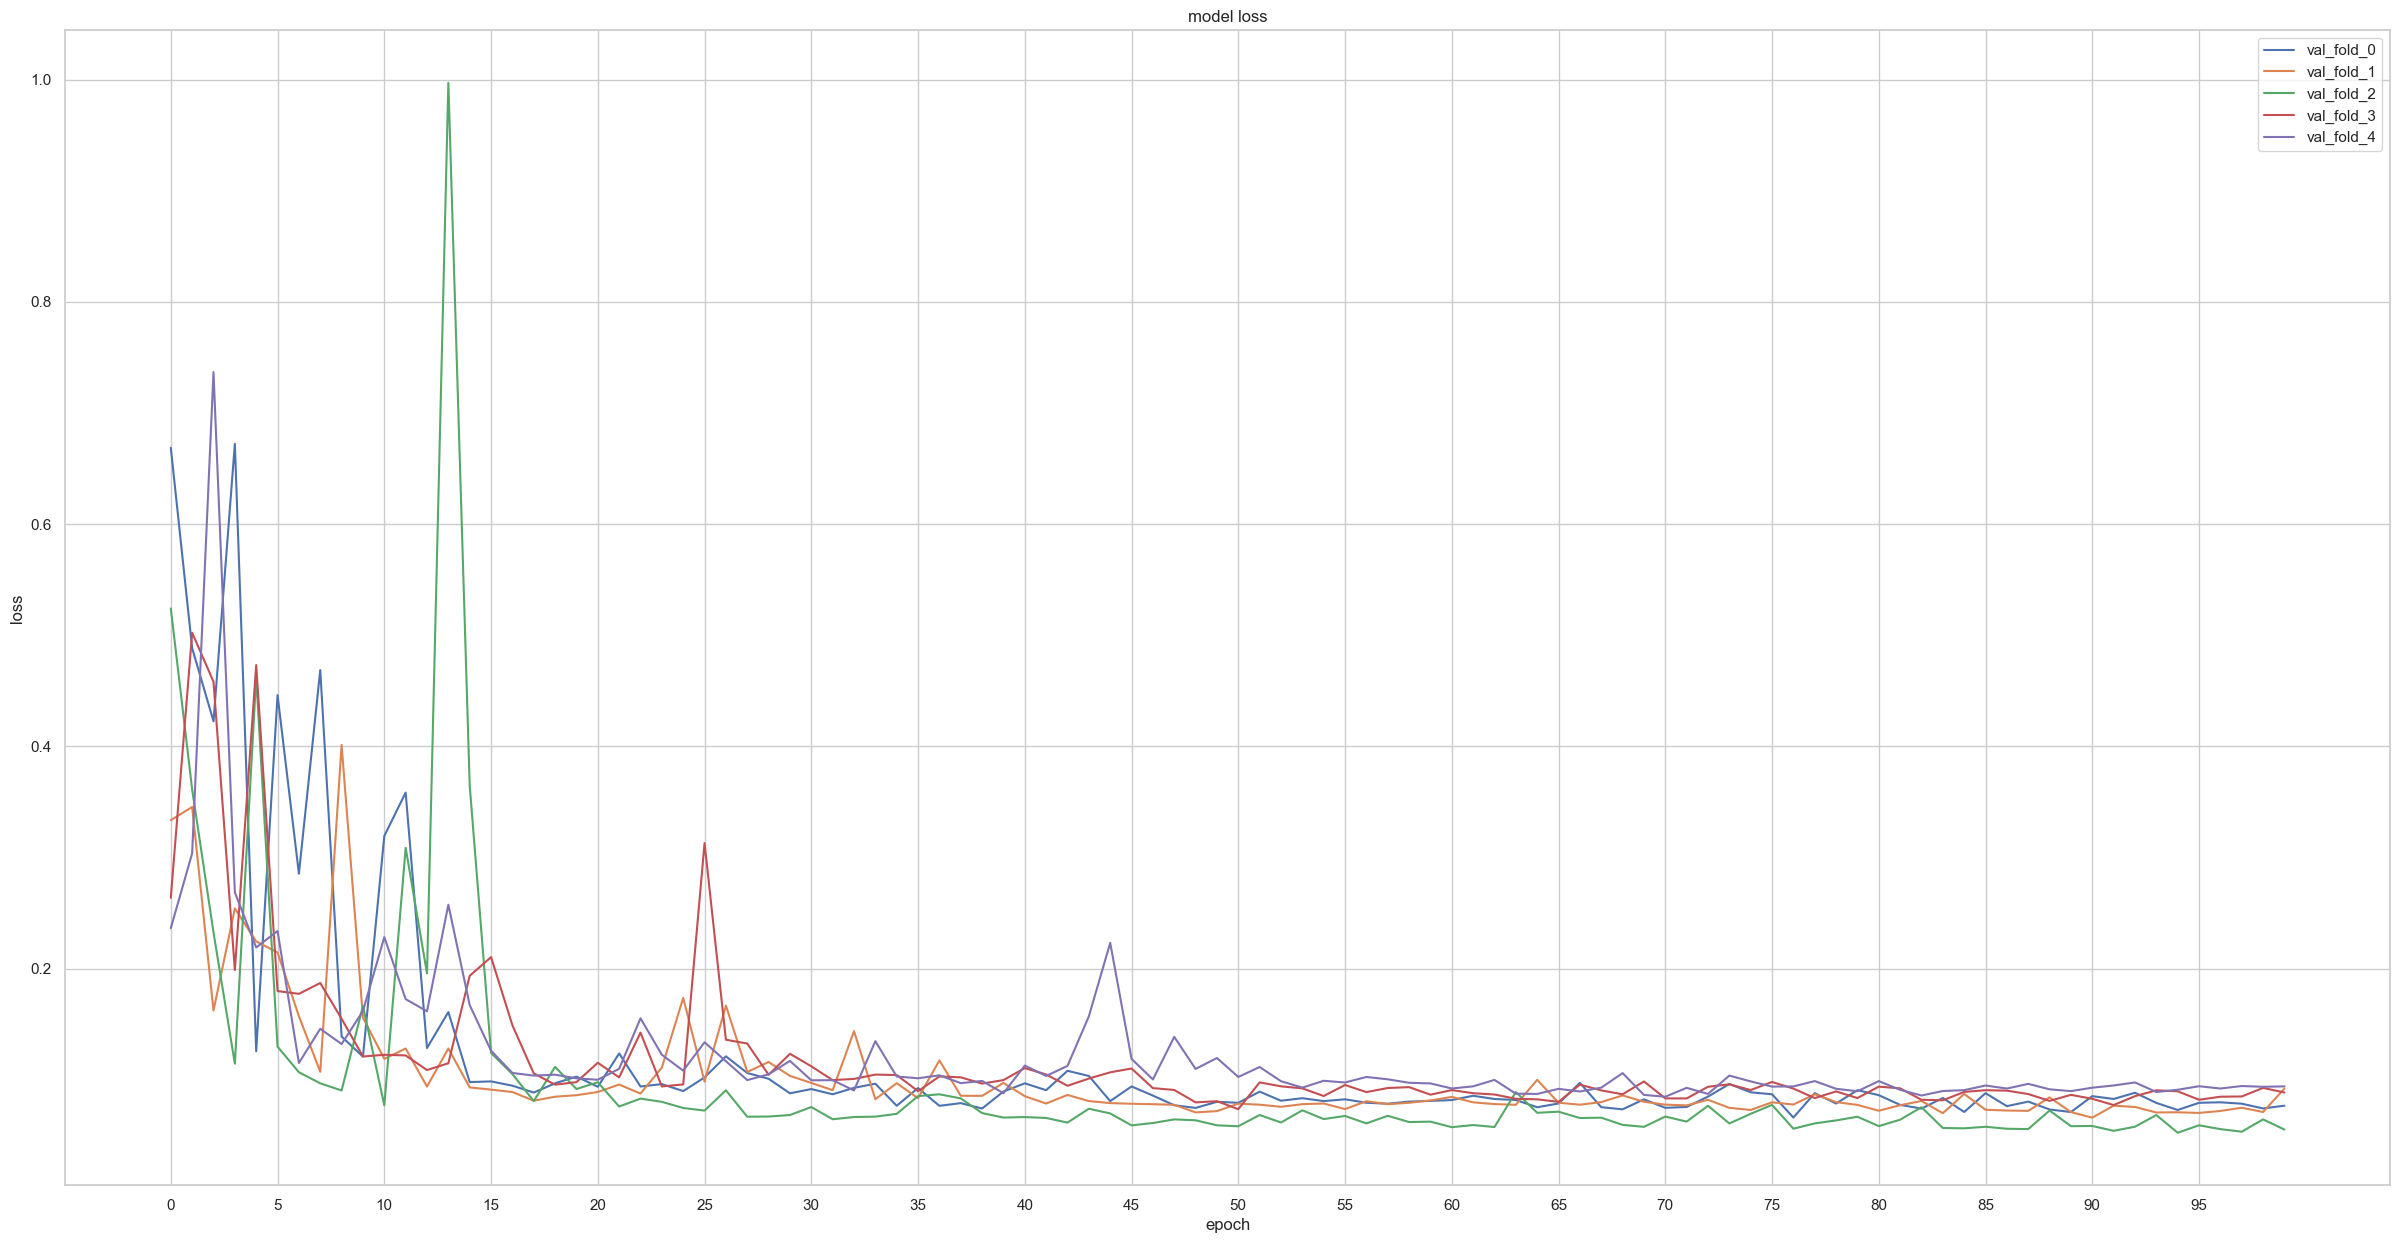

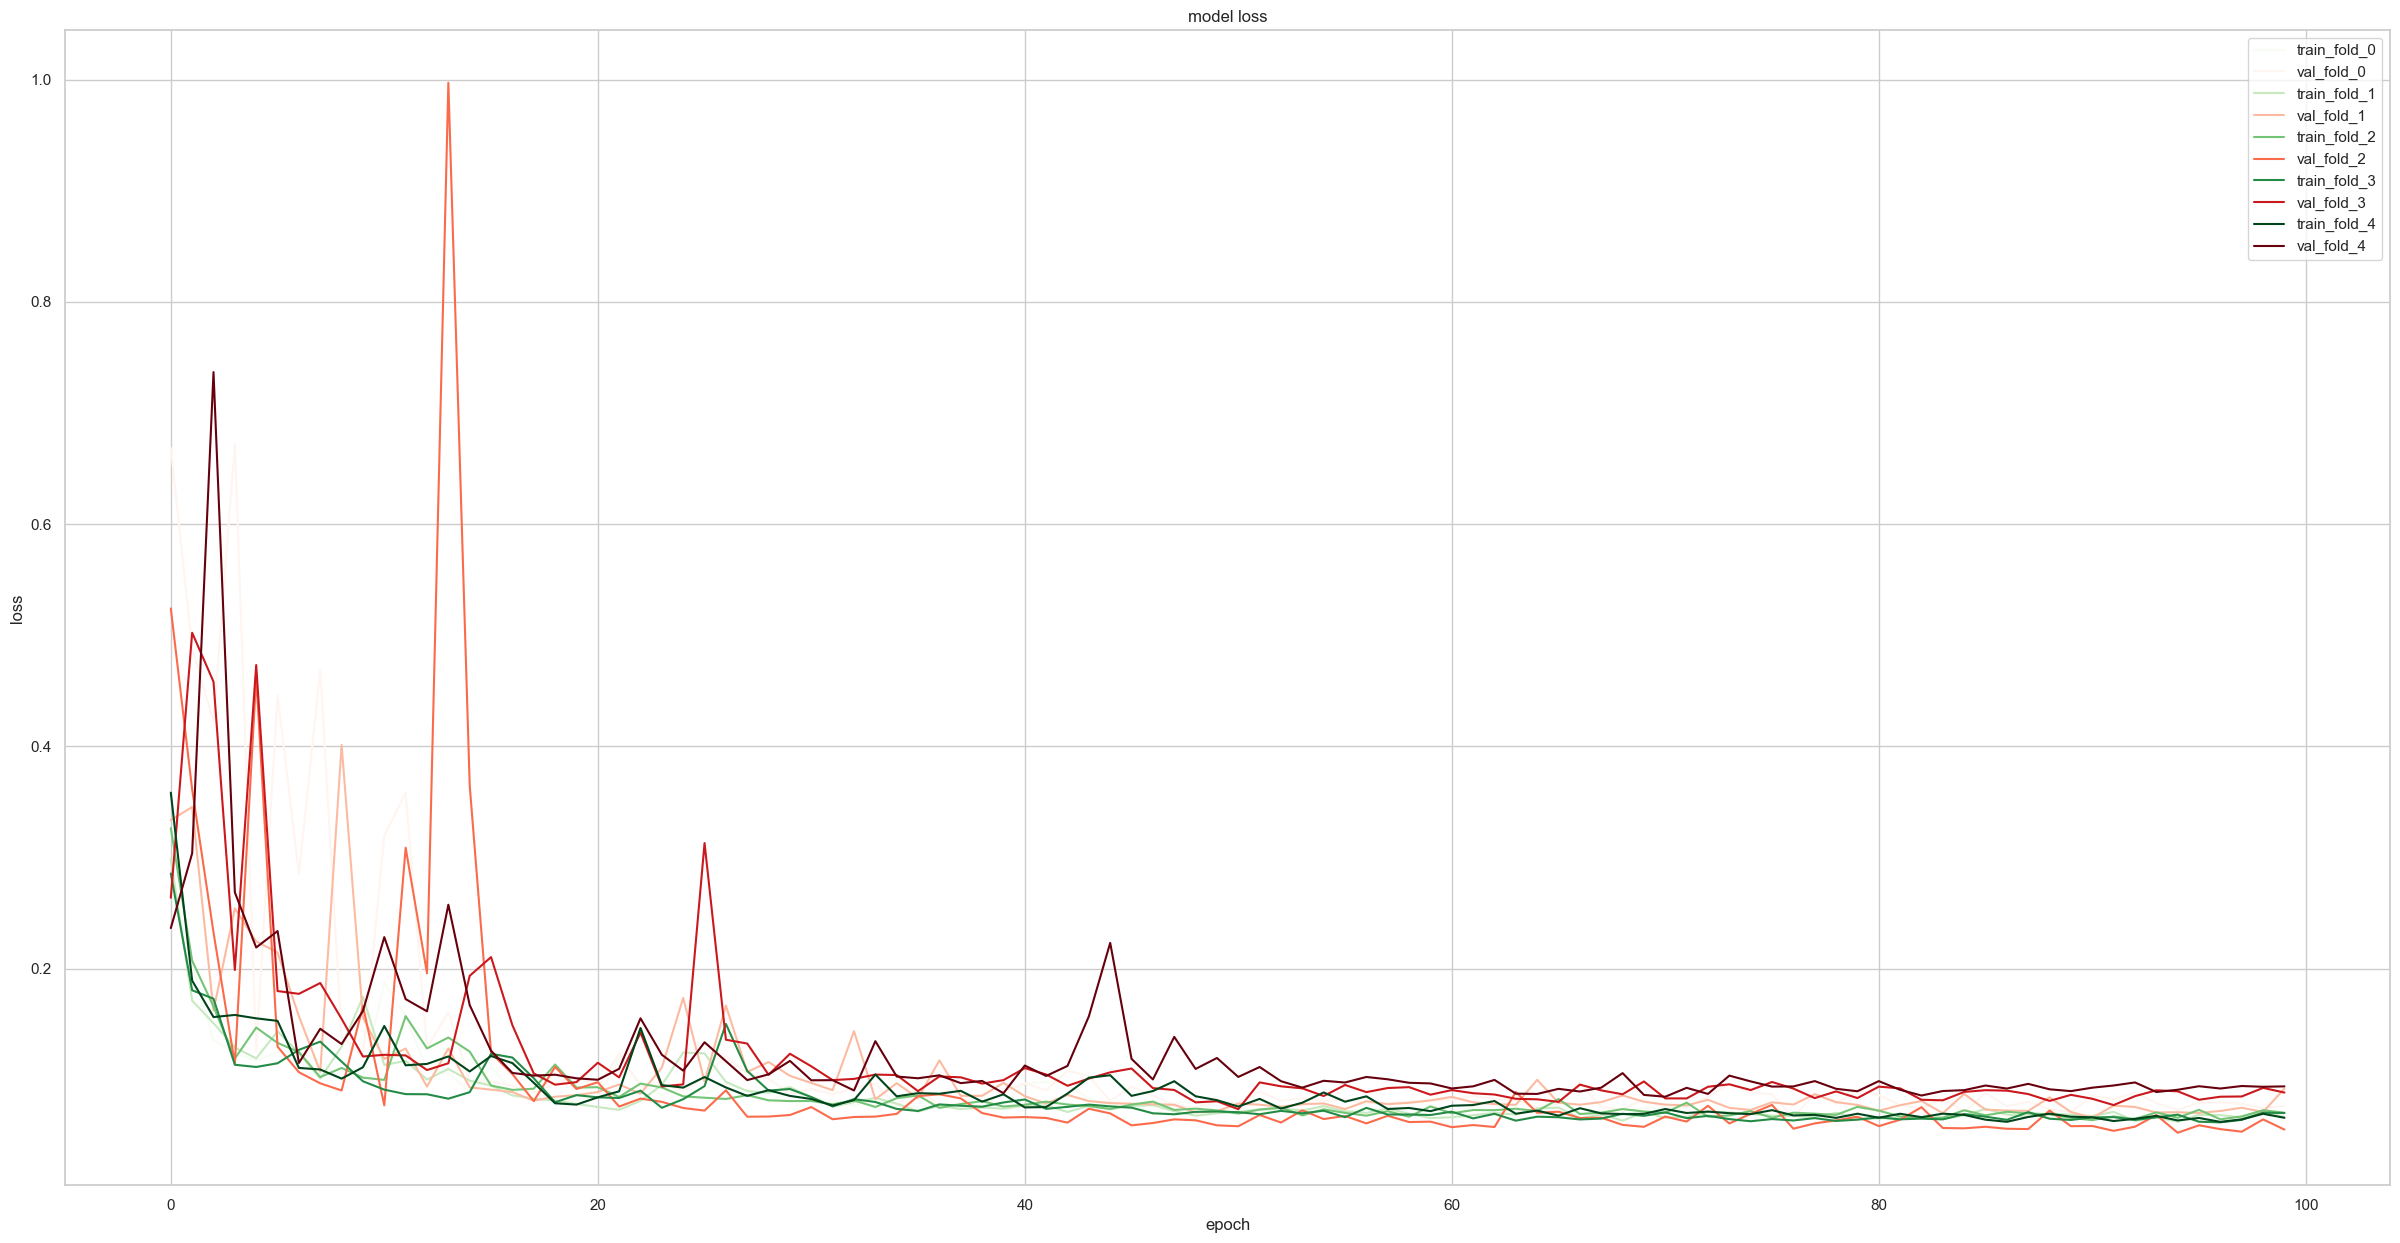

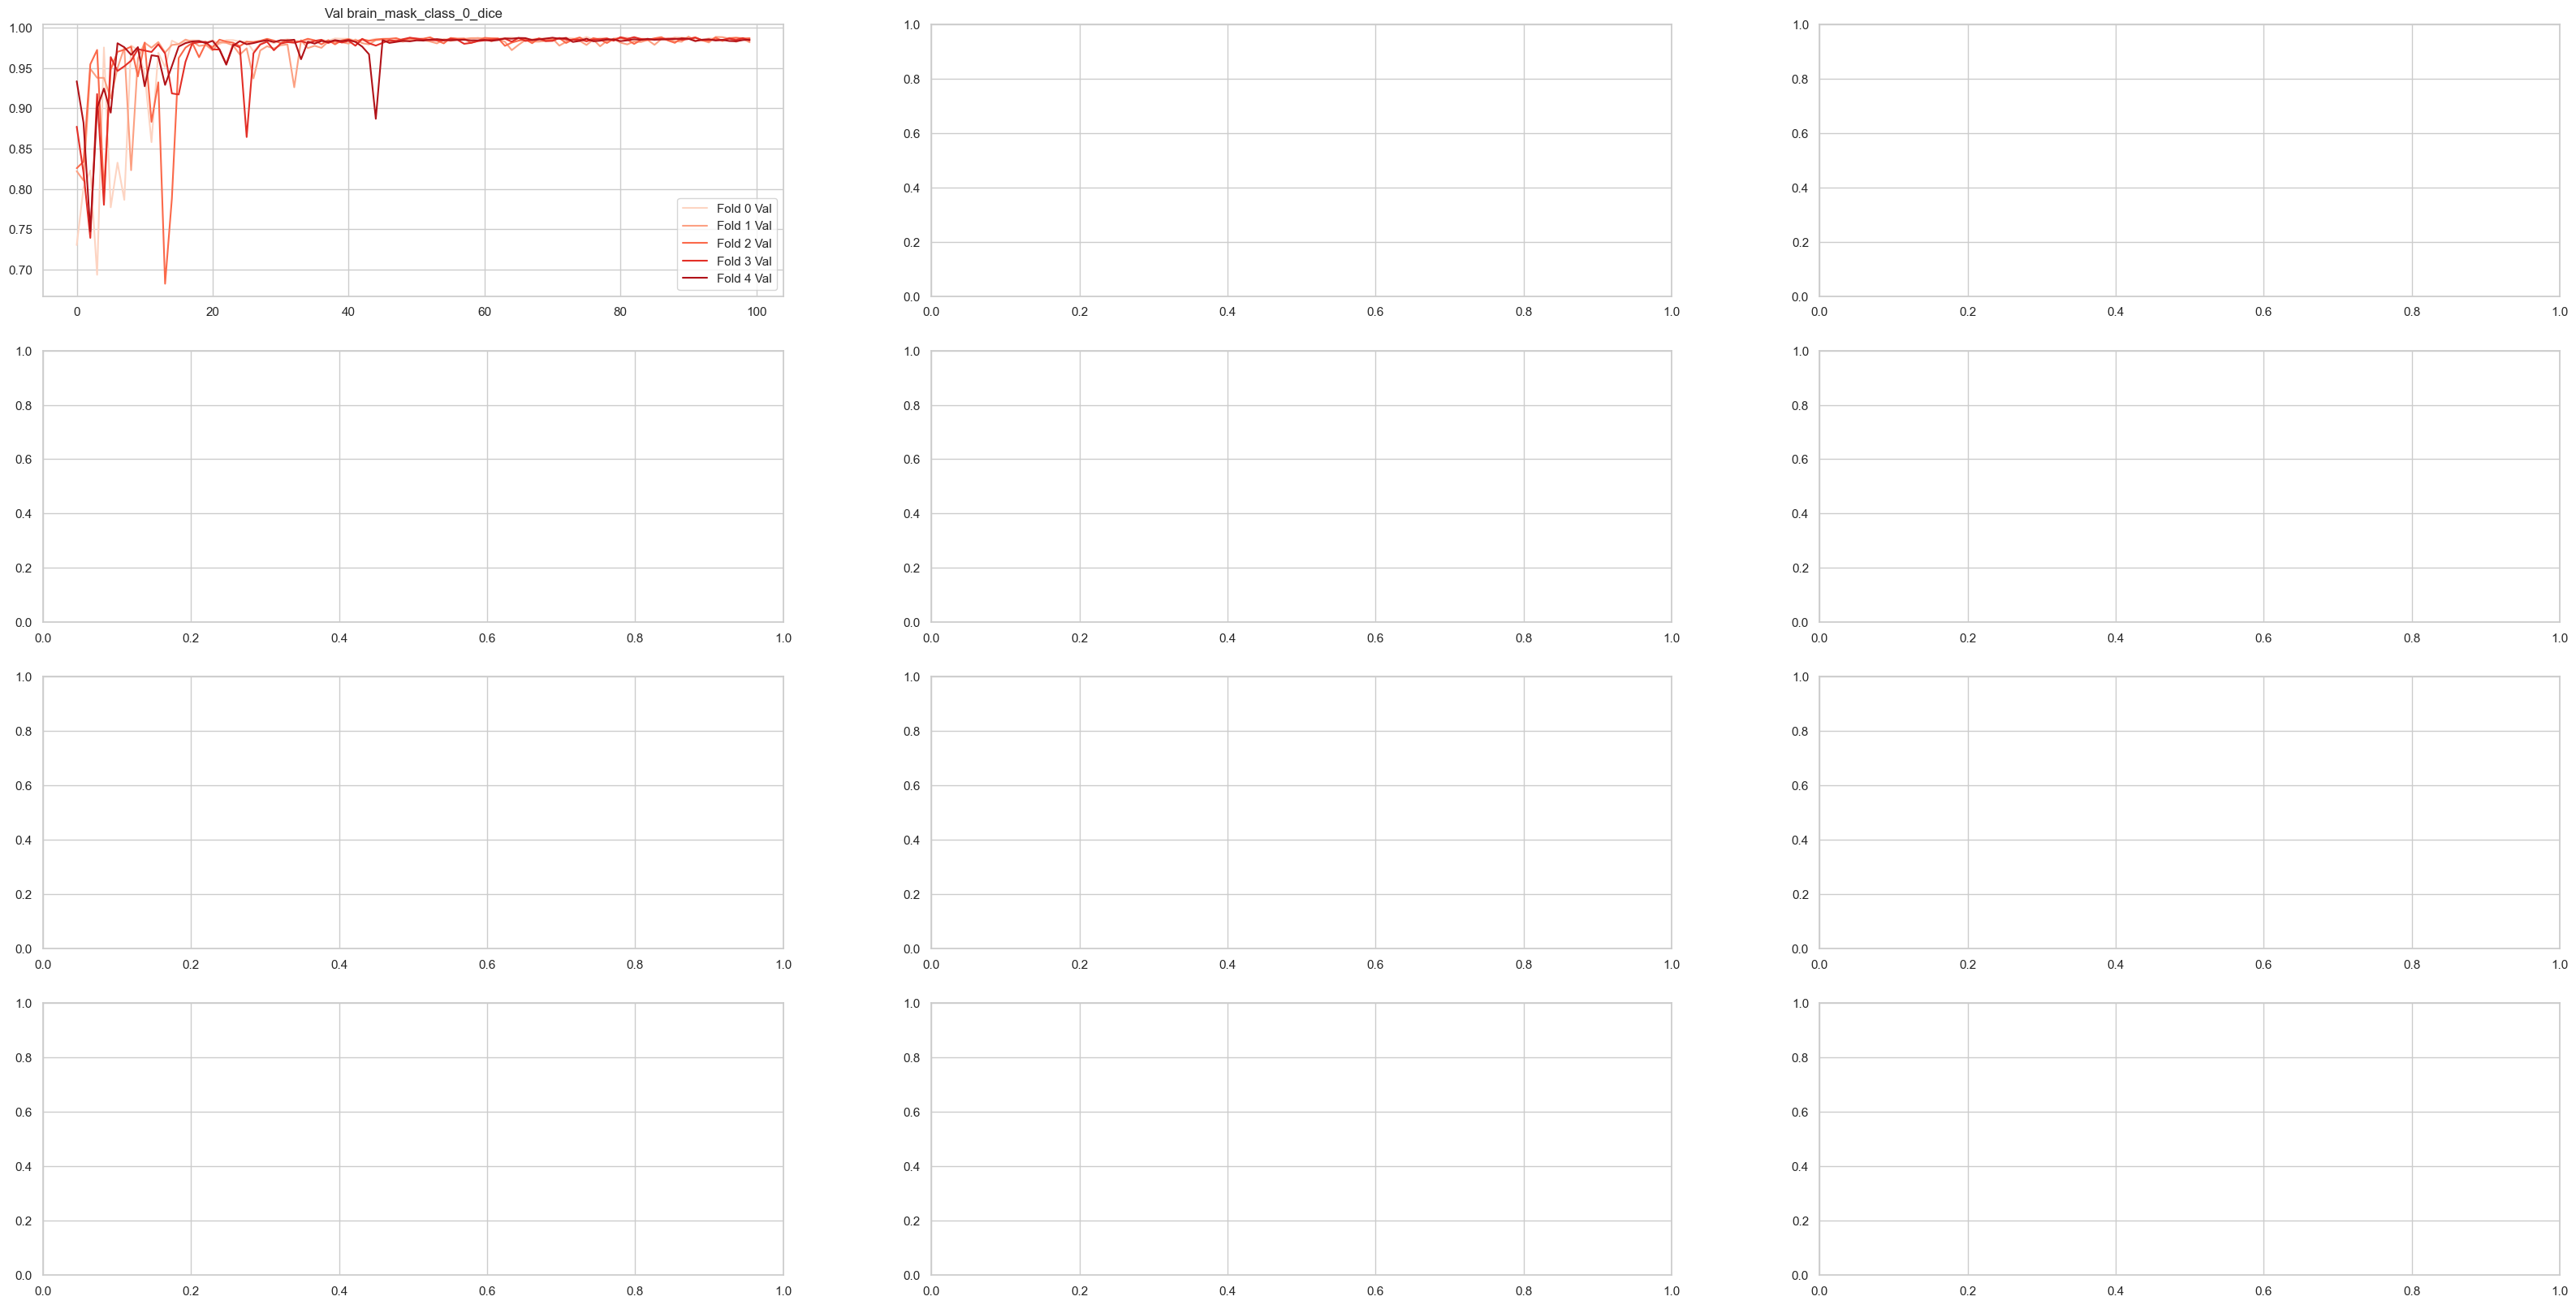

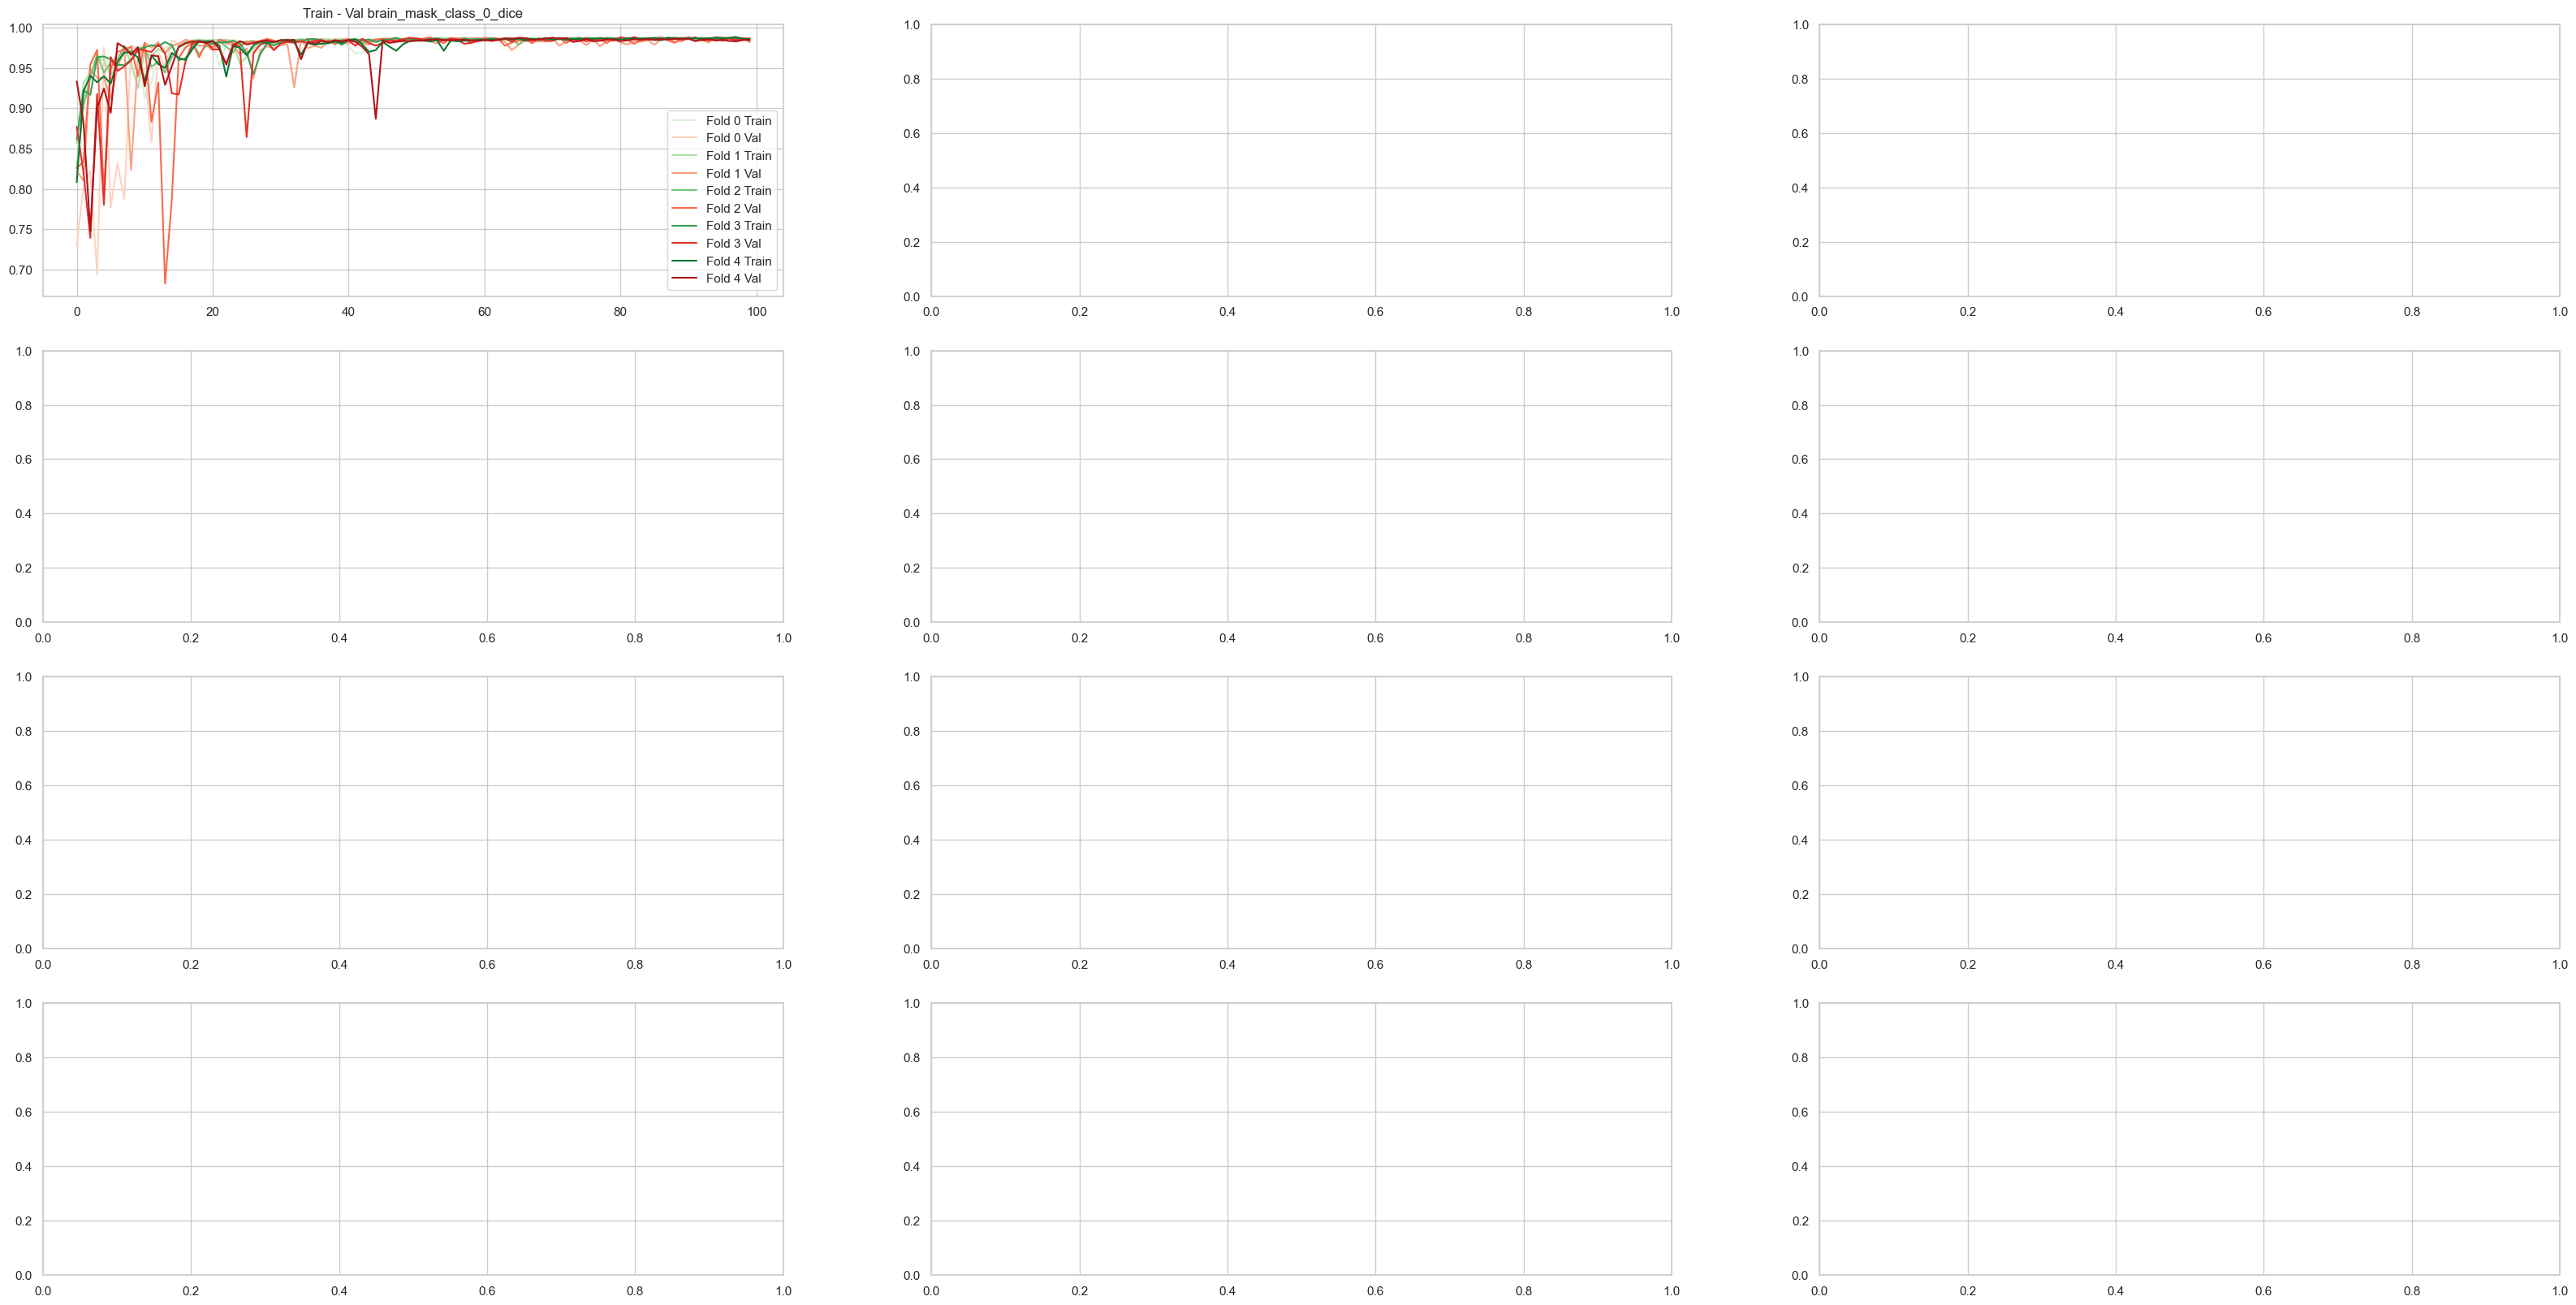

c:\Users\fmoro\SegmentationProject\SegmentationThesis\src\evaluation\k_fold.py:351: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




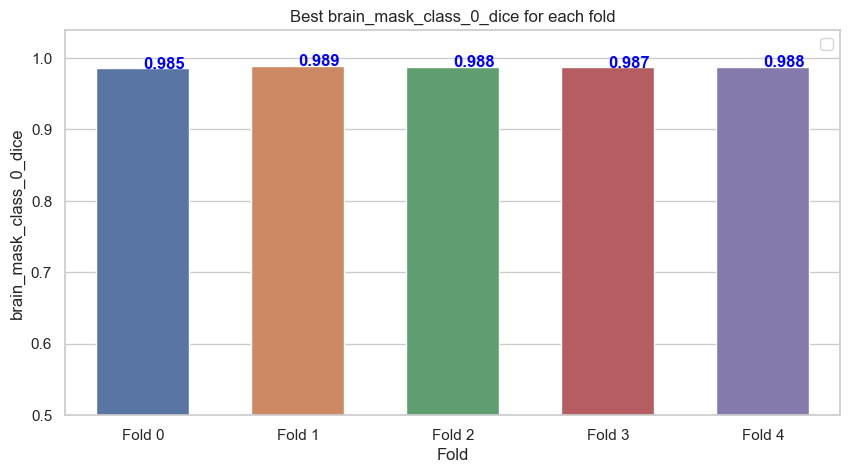

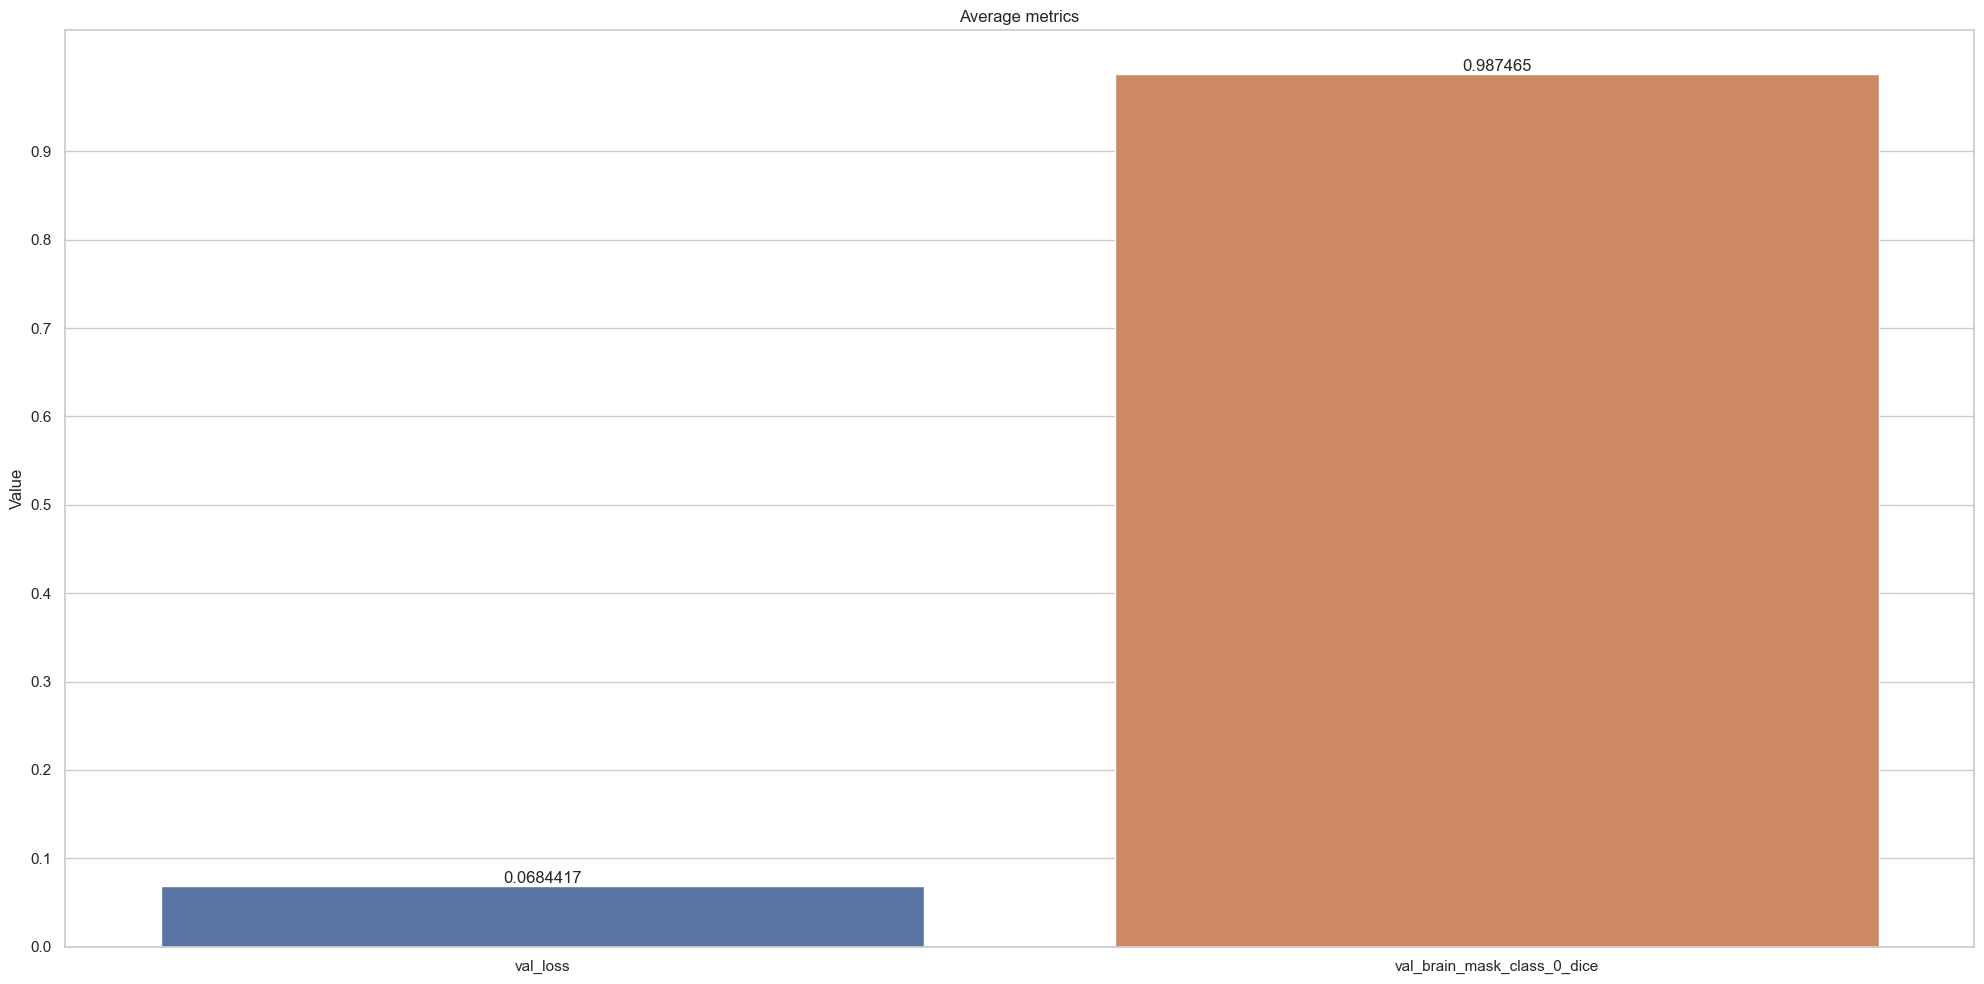

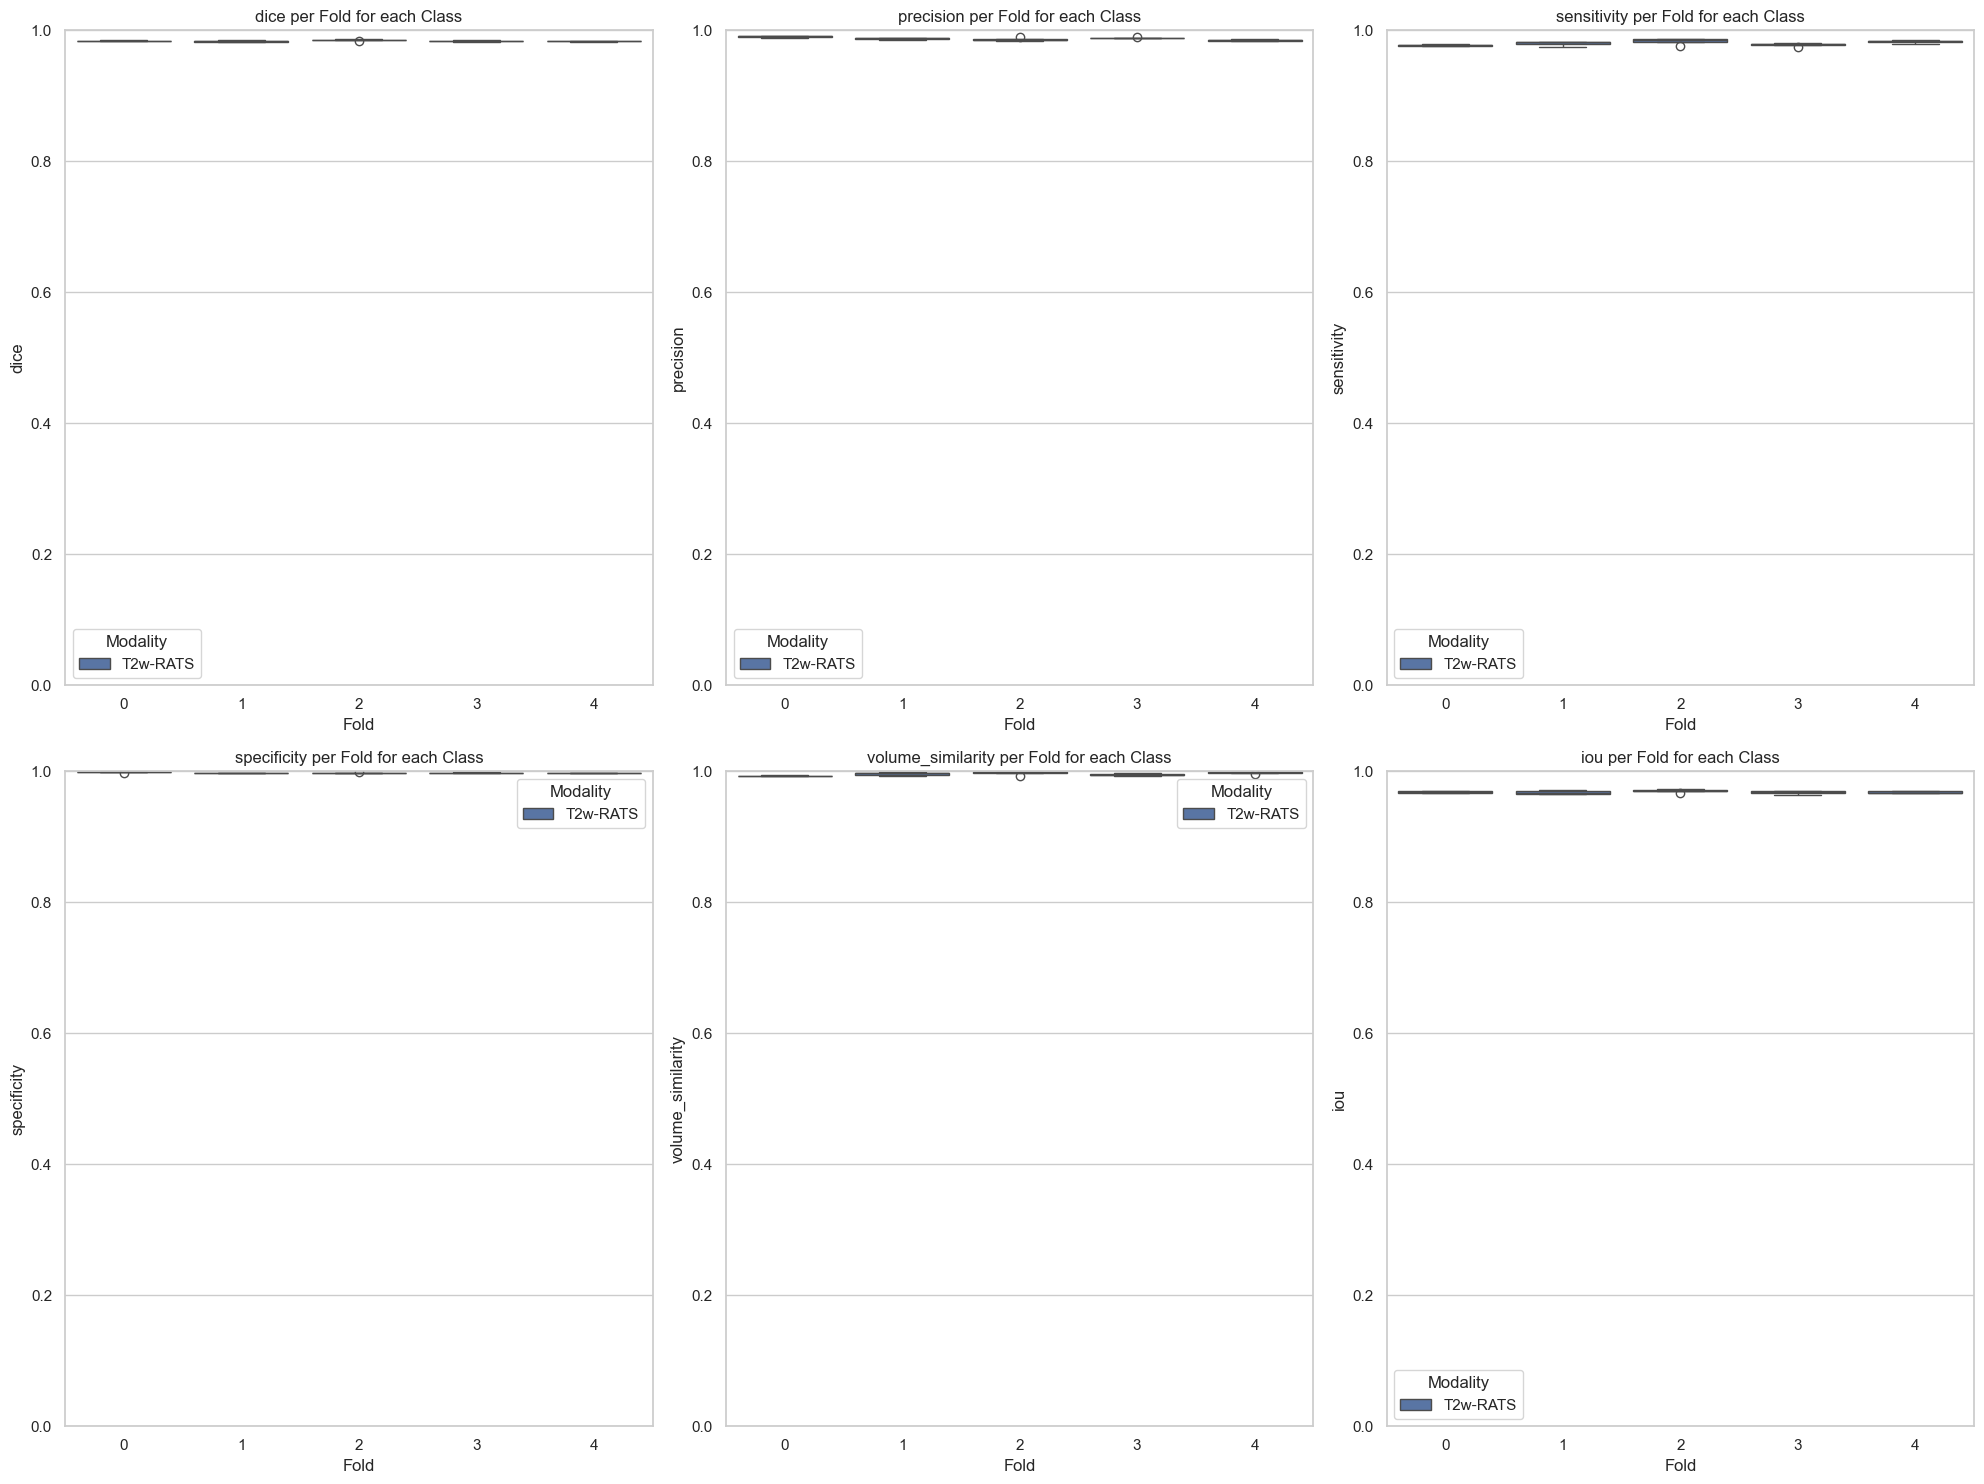

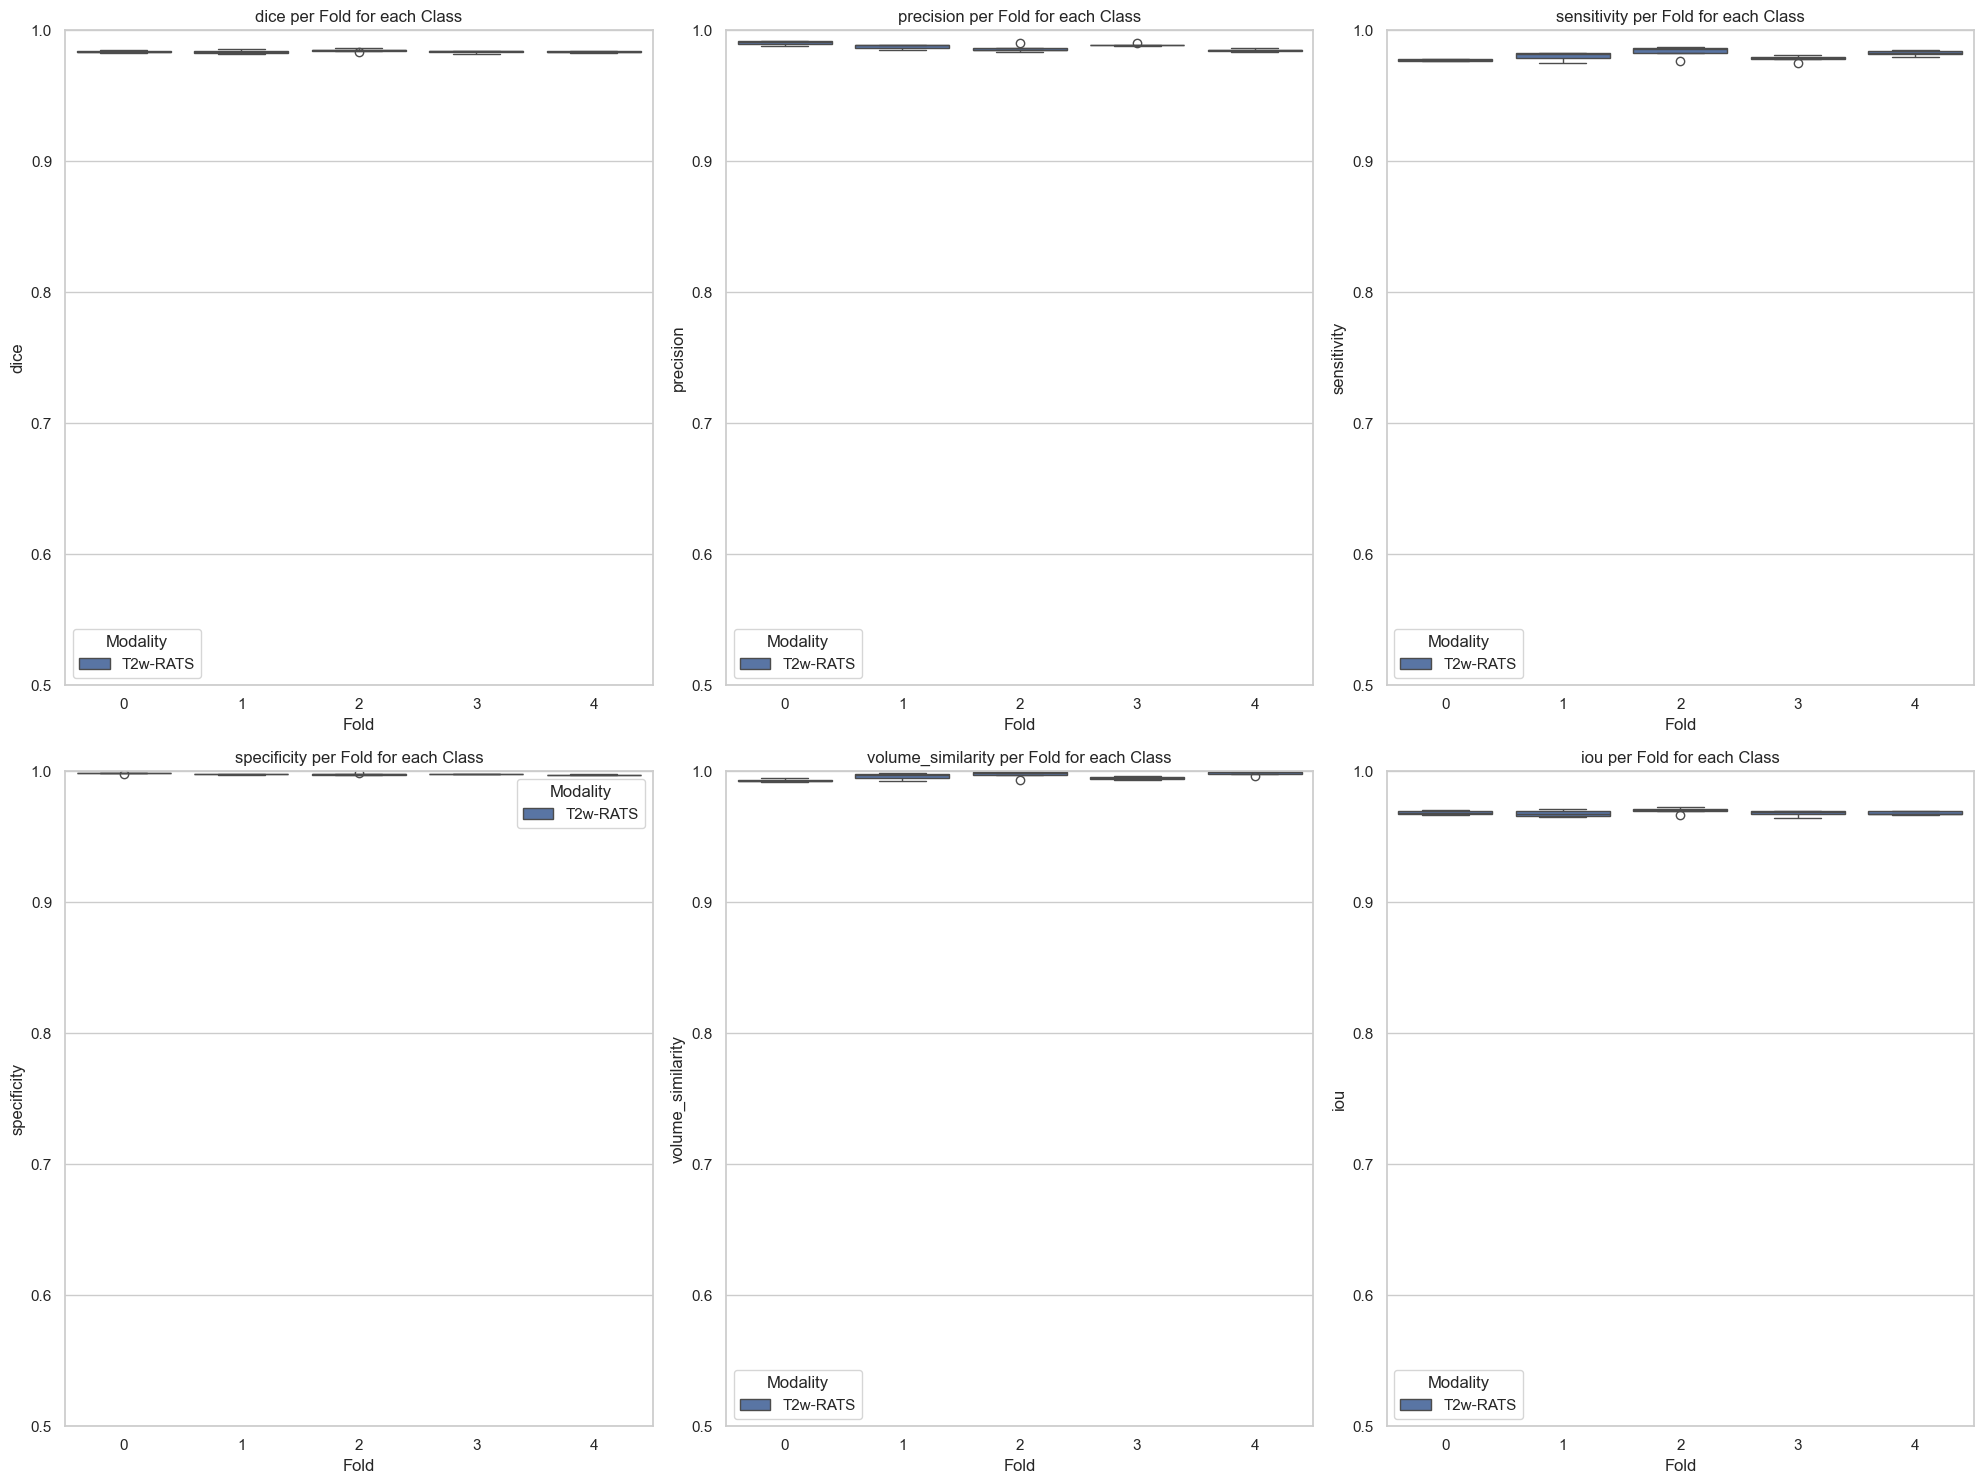

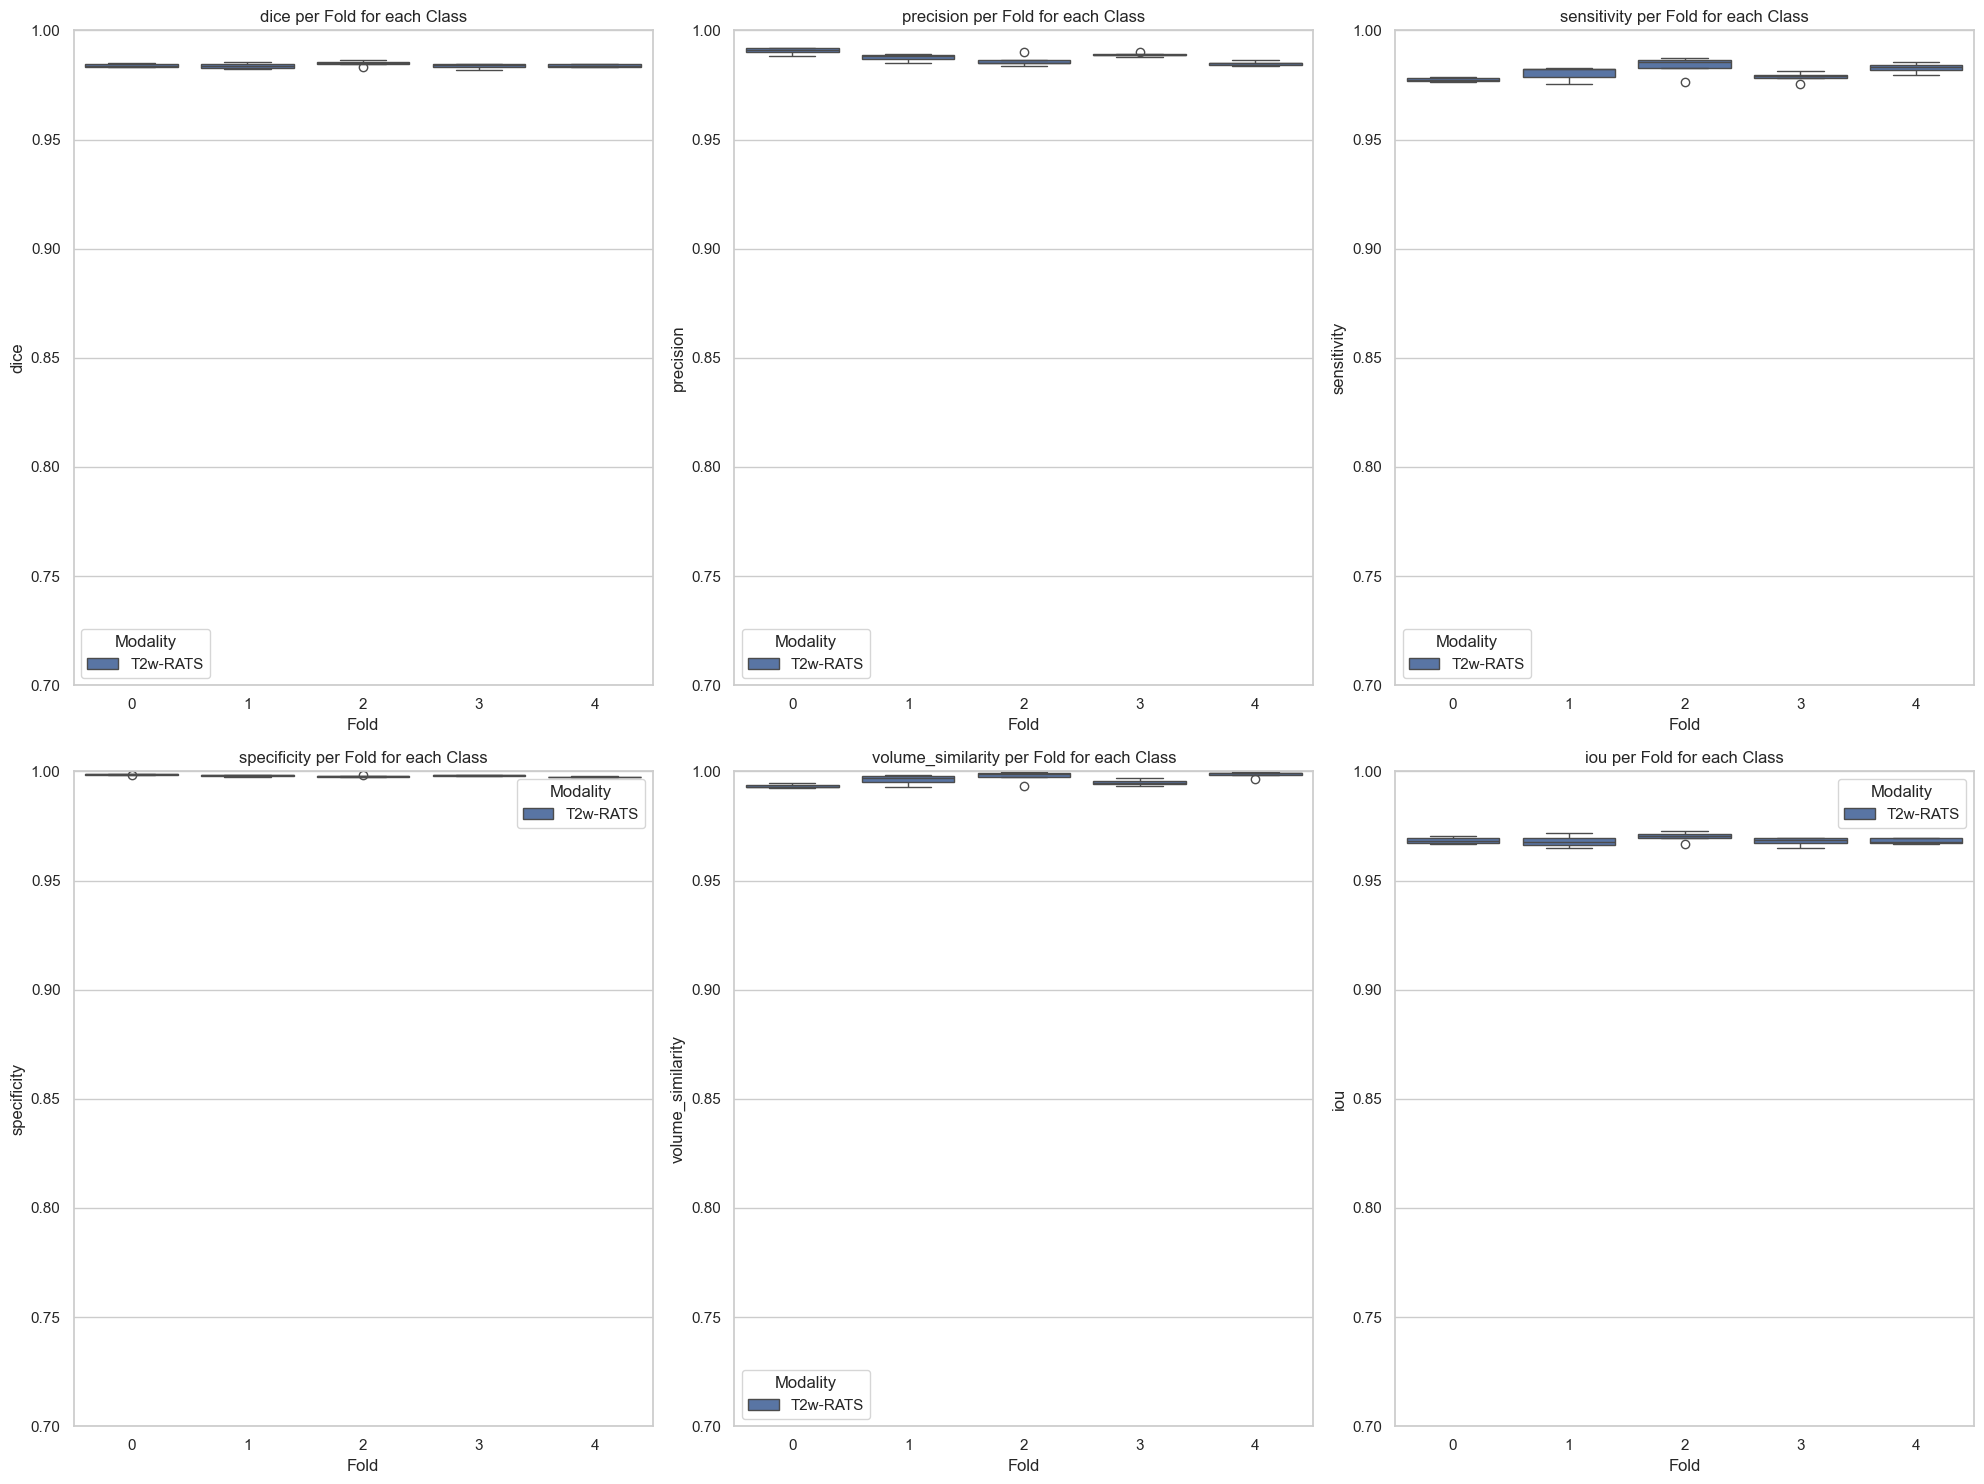

In [ ]:
# Create a dictionary to store the results
import evaluation.k_fold
importlib.reload(evaluation.k_fold)
from evaluation.k_fold import summarize_and_plot_results, save_config

metrics_regions_dic = {'regions_'+metric.__name__: [] for metric in metrics['regions']}
metrics_brain_mask_dic = {'brain_mask_class_0_dice': []}
metrics_dicts = [metrics_regions_dic, metrics_brain_mask_dic]
names = ['regions', 'brain_mask']

for i, fve_callback in enumerate(fve_callbacks):
    summarize_and_plot_results(history_k, fve_evaluations[i], config, metrics_dicts[i], names[i])
    
save_config(config)